In [1]:
import sys #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。
sys.path.insert(0, '../..') #在 Python的sys.path列表中插入一个新的路径。sys.path是一个 Python 在导入模块时会查找的路径列表。新的路径'../../Utilities/'相对于当前脚本的路径。当你尝试导入一个模块时，Python 会在 sys.path 列表中的路径下查找这个模块。通过在列表开始位置插入一个路径，你可以让 Python 优先在这个路径下查找模块。这在你需要导入自定义模块或者不在 Python 标准库中的模块时非常有用。
import scipy.io
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS
from tqdm import tqdm

from util import *
from model.pinn import PINNs
from model.pinnsformer import PINNsformer

import scipy.io

In [2]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [3]:
device = 'cuda:1'

In [4]:
# Train PINNsformer
res, b_left, b_right, b_upper, b_lower = get_data([-1,1], [0,1], 101, 101) #获取训练数据，第一个参数是x的取值范围，第二个参数是t的取值范围，第三个和第四个参数分别是x和t的采样点数
#这样，res是一个形状为(51*51,2)的数组，其中每一行代表一个(x,t)点的坐标，代表配位点/训练数据。b_left、b_right、b_upper和b_lower分别是边界条件的训练点，这些点用于训练PINNsformer模型。
res_test, _, _, _, _ = get_data([-1,1], [0,1], 256, 100) #生成测试数据，采样点数为101x101
#这样，res_test是一个形状为(101*101,2)的数组，代表测试数据

#将数据转换为时间序列，输入的数据形状为(N, 2)，第一列x第二列t。最后返回的是一个伪时间序列数据，形状为(N, num_step, 2)，step则代表Δt，是伪时间序列的递增量。相当于把N个[x,t]转换为{[x,t],[x,t+Δt],[x,t+2Δt],...,[x,t+(num_step-1)Δt]}，即每个空间位置都有一个时间序列。
res = make_time_sequence(res, num_step=5, step=1e-4) #配位点的时间序列数据，res形状变为(51*51, 5, 2)，即每个(x,t)点都有5个时间步的序列数据
b_left = make_time_sequence(b_left, num_step=5, step=1e-4) #左边界条件的时间序列数据，b_left形状变为(51, 5, 2)
b_right = make_time_sequence(b_right, num_step=5, step=1e-4) #右边界条件的时间序列数据，b_right形状变为(51, 5, 2)
b_upper = make_time_sequence(b_upper, num_step=5, step=1e-4) #上边界条件的时间序列数据，b_upper形状变为(51, 5, 2)
b_lower = make_time_sequence(b_lower, num_step=5, step=1e-4) #下边界条件的时间序列数据，b_lower形状变为(51, 5, 2)

#将数据转移到显卡上
res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)

#将数据分离为x和t的部分
x_res, t_res = res[:,:,0:1], res[:,:,1:2] #将res的第一列作为x，第二列作为t,这样x_res和t_res的形状都是(51*51, 5, 1)，即51*51个时间序列，每个(x,t)点都有5个时间步的序列数据
x_left, t_left = b_left[:,:,0:1], b_left[:,:,1:2] #将b_left的第一列作为x，第二列作为t,这样x_left和t_left的形状都是(51, 5, 1)，即每个左边界点都有5个时间步的序列数据
x_right, t_right = b_right[:,:,0:1], b_right[:,:,1:2] #将b_right的第一列作为x，第二列作为t,这样x_right和t_right的形状都是(51, 5, 1)，即每个右边界点都有5个时间步的序列数据
x_upper, t_upper = b_upper[:,:,0:1], b_upper[:,:,1:2] #将b_upper的第一列作为x，第二列作为t,这样x_upper和t_upper的形状都是(51, 5, 1)，即每个上边界点都有5个时间步的序列数据
x_lower, t_lower = b_lower[:,:,0:1], b_lower[:,:,1:2] #将b_lower的第一列作为x，第二列作为t,这样x_lower和t_lower的形状都是(51, 5, 1)，即每个下边界点都有5个时间步的序列数据

#初始化神经网络的线性层权重参数，使用Xavier初始化权重，偏置则初始化为0.01
def init_weights(m):
    if isinstance(m, nn.Linear): #判断是否是线性层
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

res_test = make_time_sequence(res_test, num_step=5, step=1e-4) 
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,:,0:1], res_test[:,:,1:2]

In [5]:
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子

L1error = []
L2error = []

for seed in seeds:
    set_seed(seed) #设置随机数种子

    model = PINNsformer(d_out=1, d_hidden=512, d_model=32, N=1, heads=2).to(device) #创建PINNsformer模型，模型输出维度为1，outputlayer模块的隐藏层维度为512，数据的特征嵌入维度为32，编码器和解码器的层数为1，注意力机制的头数为2

    model.apply(init_weights) #初始化模型中线性层的权重和偏置
    optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe') #使用LBFGS优化器，line_search_fn='strong_wolfe'表示使用强Wolfe线搜索方法

    loss_track = [] #记录loss


    for i in tqdm(range(500)): #训练500次
        def closure():
            pred_res = model(x_res, t_res) #得到配位点的预测结果
            pred_left = model(x_left, t_left) #得到左边界点的预测结果
            pred_right = model(x_right, t_right) #得到右边界点的预测结果
            pred_upper = model(x_upper, t_upper) #得到上边界点的预测结果
            pred_lower = model(x_lower, t_lower) #得到下边界点的预测结果

            #计算配位点的时间导数u_t和空间导数u_x
            u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
            u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
            u_xx = torch.autograd.grad(u_x, x_res, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]

            pred_x_upper = torch.autograd.grad(pred_upper, x_upper, grad_outputs=torch.ones_like(pred_upper), retain_graph=True, create_graph=True)[0]
            pred_x_lower = torch.autograd.grad(pred_lower, x_lower, grad_outputs=torch.ones_like(pred_lower), retain_graph=True, create_graph=True)[0]

            #计算损失，共三项损失
            loss_res = torch.mean((u_t + pred_res * u_x - 0.01/torch.pi * u_xx) ** 2)
            # loss_res = torch.mean((u_t - 5 * pred_res * (1-pred_res)) ** 2)
            # loss_bc = torch.mean((pred_upper - pred_lower) ** 2)
            loss_bc = torch.mean((pred_upper - pred_lower)**2)
            # loss_ic = torch.mean((pred_left[:,0] - torch.exp(- (x_left[:,0] - torch.pi)**2 / (2*(torch.pi/4)**2))) ** 2)
            loss_ic = torch.mean((pred_left[:,0] + torch.sin(torch.pi*x_left[:,0])) ** 2)

            loss_track.append([loss_res.item(), loss_bc.item(), loss_ic.item()])

            loss = loss_res + loss_bc + loss_ic
            optim.zero_grad()
            loss.backward()
            return loss

        optim.step(closure)

    

    # Visualize PINNsformer
    

    with torch.no_grad():
        pred = model(x_test, t_test)[:,0:1]
        pred = pred.cpu().detach().numpy()

    pred = pred.reshape(100,256).T

    mat = scipy.io.loadmat('./burgers_shock.mat')
    u = mat['usol'].reshape(256,100)

    rl1 = np.sum(np.abs(u-pred)) / np.sum(np.abs(u))
    rl2 = np.sqrt(np.sum((u-pred)**2) / np.sum(u**2))

    print('relative L1 error: {:4f}'.format(rl1))
    print('relative L2 error: {:4f}'.format(rl2))

    L1error.append(rl1)
    L2error.append(rl2)

/tmp/ipykernel_1360577/2080305586.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:04<39:28,  4.75s/it]

  0%|          | 2/500 [00:09<38:03,  4.59s/it]

  1%|          | 3/500 [00:14<40:57,  4.94s/it]

  1%|          | 4/500 [00:19<40:52,  4.95s/it]

  1%|          | 5/500 [00:24<41:30,  5.03s/it]

  1%|          | 6/500 [00:30<42:28,  5.16s/it]

  1%|▏         | 7/500 [00:34<40:47,  4.96s/it]

  2%|▏         | 8/500 [00:39<40:44,  4.97s/it]

  2%|▏         | 9/500 [00:45<41:46,  5.11s/it]

  2%|▏         | 10/500 [00:50<41:55,  5.13s/it]

  2%|▏         | 11/500 [00:55<42:00,  5.15s/it]

  2%|▏         | 12/500 [01:00<40:59,  5.04s/it]

  3%|▎         | 13/500 [01:05<40:47,  5.03s/it]

  3%|▎         | 14/500 [01:10<40:06,  4.95s/it]

  3%|▎         | 15/500 [01:14<39:04,  4.83s/it]

  3%|▎         | 16/500 [01:19<39:22,  4.88s/it]

  3%|▎         | 17/500 [01:24<39:04,  4.85s/it]

  4%|▎         | 18/500 [01:28<38:18,  4.77s/it]

  4%|▍         | 19/500 [01:33<37:44,  4.71s/it]

  4%|▍         | 20/500 [01:38<37:20,  4.67s/it]

  4%|▍         | 21/500 [01:42<37:30,  4.70s/it]

  4%|▍         | 22/500 [01:48<39:13,  4.92s/it]

  5%|▍         | 23/500 [01:53<38:48,  4.88s/it]

  5%|▍         | 24/500 [01:57<37:59,  4.79s/it]

  5%|▌         | 25/500 [02:02<37:23,  4.72s/it]

  5%|▌         | 26/500 [02:06<36:55,  4.67s/it]

  5%|▌         | 27/500 [02:11<36:34,  4.64s/it]

  6%|▌         | 28/500 [02:16<36:49,  4.68s/it]

  6%|▌         | 29/500 [02:21<38:57,  4.96s/it]

  6%|▌         | 30/500 [02:27<39:57,  5.10s/it]

  6%|▌         | 31/500 [02:32<40:36,  5.20s/it]

  6%|▋         | 32/500 [02:37<39:01,  5.00s/it]

  7%|▋         | 33/500 [02:41<37:53,  4.87s/it]

  7%|▋         | 34/500 [02:46<37:35,  4.84s/it]

  7%|▋         | 35/500 [02:51<37:24,  4.83s/it]

  7%|▋         | 36/500 [02:56<37:13,  4.81s/it]

  7%|▋         | 37/500 [03:00<36:34,  4.74s/it]

  8%|▊         | 38/500 [03:05<36:05,  4.69s/it]

  8%|▊         | 39/500 [03:09<35:42,  4.65s/it]

  8%|▊         | 40/500 [03:14<35:26,  4.62s/it]

  8%|▊         | 41/500 [03:19<35:43,  4.67s/it]

  8%|▊         | 42/500 [03:23<35:55,  4.71s/it]

  9%|▊         | 43/500 [03:28<35:34,  4.67s/it]

  9%|▉         | 44/500 [03:33<36:12,  4.76s/it]

  9%|▉         | 45/500 [03:38<36:40,  4.84s/it]

  9%|▉         | 46/500 [03:43<36:28,  4.82s/it]

  9%|▉         | 47/500 [03:48<36:48,  4.88s/it]

 10%|▉         | 48/500 [03:53<36:29,  4.84s/it]

 10%|▉         | 49/500 [03:58<37:42,  5.02s/it]

 10%|█         | 50/500 [04:03<37:05,  4.95s/it]

 10%|█         | 51/500 [04:08<37:36,  5.03s/it]

 10%|█         | 52/500 [04:13<37:56,  5.08s/it]

 11%|█         | 53/500 [04:18<37:38,  5.05s/it]

 11%|█         | 54/500 [04:24<38:22,  5.16s/it]

 11%|█         | 55/500 [04:29<37:58,  5.12s/it]

 11%|█         | 56/500 [04:34<38:32,  5.21s/it]

 11%|█▏        | 57/500 [04:39<37:59,  5.15s/it]

 12%|█▏        | 58/500 [04:44<38:04,  5.17s/it]

 12%|█▏        | 59/500 [04:49<38:02,  5.18s/it]

 12%|█▏        | 60/500 [04:54<37:34,  5.12s/it]

 12%|█▏        | 61/500 [04:59<37:12,  5.09s/it]

 12%|█▏        | 62/500 [05:04<36:56,  5.06s/it]

 13%|█▎        | 63/500 [05:10<37:14,  5.11s/it]

 13%|█▎        | 64/500 [05:15<36:52,  5.08s/it]

 13%|█▎        | 65/500 [05:20<37:33,  5.18s/it]

 13%|█▎        | 66/500 [05:25<36:36,  5.06s/it]

 13%|█▎        | 67/500 [05:30<35:56,  4.98s/it]

 14%|█▎        | 68/500 [05:35<35:53,  4.98s/it]

 14%|█▍        | 69/500 [05:40<36:47,  5.12s/it]

 14%|█▍        | 70/500 [05:45<36:24,  5.08s/it]

 14%|█▍        | 71/500 [05:50<36:07,  5.05s/it]

 14%|█▍        | 72/500 [05:56<37:17,  5.23s/it]

 15%|█▍        | 73/500 [06:01<38:06,  5.35s/it]

 15%|█▍        | 74/500 [06:06<37:14,  5.24s/it]

 15%|█▌        | 75/500 [06:11<36:11,  5.11s/it]

 15%|█▌        | 76/500 [06:16<36:18,  5.14s/it]

 15%|█▌        | 77/500 [06:22<36:48,  5.22s/it]

 16%|█▌        | 78/500 [06:26<35:21,  5.03s/it]

 16%|█▌        | 79/500 [06:32<36:07,  5.15s/it]

 16%|█▌        | 80/500 [06:37<36:35,  5.23s/it]

 16%|█▌        | 81/500 [06:42<36:01,  5.16s/it]

 16%|█▋        | 82/500 [06:47<35:09,  5.05s/it]

 17%|█▋        | 83/500 [06:52<35:49,  5.16s/it]

 17%|█▋        | 84/500 [06:57<34:59,  5.05s/it]

 17%|█▋        | 85/500 [07:02<34:47,  5.03s/it]

 17%|█▋        | 86/500 [07:07<35:07,  5.09s/it]

 17%|█▋        | 87/500 [07:12<34:50,  5.06s/it]

 18%|█▊        | 88/500 [07:18<35:03,  5.10s/it]

 18%|█▊        | 89/500 [07:23<35:39,  5.21s/it]

 18%|█▊        | 90/500 [07:28<35:59,  5.27s/it]

 18%|█▊        | 91/500 [07:34<35:48,  5.25s/it]

 18%|█▊        | 92/500 [07:39<35:10,  5.17s/it]

 19%|█▊        | 93/500 [07:44<34:45,  5.12s/it]

 19%|█▉        | 94/500 [07:49<34:24,  5.08s/it]

 19%|█▉        | 95/500 [07:54<34:10,  5.06s/it]

 19%|█▉        | 96/500 [07:58<33:31,  4.98s/it]

 19%|█▉        | 97/500 [08:03<33:28,  4.98s/it]

 20%|█▉        | 98/500 [08:08<33:27,  4.99s/it]

 20%|█▉        | 99/500 [08:14<33:47,  5.06s/it]

 20%|██        | 100/500 [08:18<33:10,  4.98s/it]

 20%|██        | 101/500 [08:24<33:33,  5.05s/it]

 20%|██        | 102/500 [08:28<32:55,  4.96s/it]

 21%|██        | 103/500 [08:34<33:46,  5.10s/it]

 21%|██        | 104/500 [08:39<33:30,  5.08s/it]

 21%|██        | 105/500 [08:44<33:15,  5.05s/it]

 21%|██        | 106/500 [08:49<32:37,  4.97s/it]

 21%|██▏       | 107/500 [08:54<33:51,  5.17s/it]

 22%|██▏       | 108/500 [08:59<33:49,  5.18s/it]

 22%|██▏       | 109/500 [09:05<33:48,  5.19s/it]

 22%|██▏       | 110/500 [09:09<32:56,  5.07s/it]

 22%|██▏       | 111/500 [09:15<33:07,  5.11s/it]

 22%|██▏       | 112/500 [09:20<33:12,  5.13s/it]

 23%|██▎       | 113/500 [09:25<32:27,  5.03s/it]

 23%|██▎       | 114/500 [09:30<32:17,  5.02s/it]

 23%|██▎       | 115/500 [09:35<32:10,  5.01s/it]

 23%|██▎       | 116/500 [09:40<32:54,  5.14s/it]

 23%|██▎       | 117/500 [09:45<32:09,  5.04s/it]

 24%|██▎       | 118/500 [09:50<31:58,  5.02s/it]

 24%|██▍       | 119/500 [09:55<32:13,  5.08s/it]

 24%|██▍       | 120/500 [10:00<31:58,  5.05s/it]

 24%|██▍       | 121/500 [10:05<31:45,  5.03s/it]

 24%|██▍       | 122/500 [10:10<32:24,  5.14s/it]

 25%|██▍       | 123/500 [10:16<32:25,  5.16s/it]

 25%|██▍       | 124/500 [10:21<32:01,  5.11s/it]

 25%|██▌       | 125/500 [10:25<31:18,  5.01s/it]

 25%|██▌       | 126/500 [10:31<31:34,  5.07s/it]

 25%|██▌       | 127/500 [10:35<30:56,  4.98s/it]

 26%|██▌       | 128/500 [10:40<30:29,  4.92s/it]

 26%|██▌       | 129/500 [10:46<31:19,  5.07s/it]

 26%|██▌       | 130/500 [10:50<30:42,  4.98s/it]

 26%|██▌       | 131/500 [10:55<30:38,  4.98s/it]

 26%|██▋       | 132/500 [11:00<30:33,  4.98s/it]

 27%|██▋       | 133/500 [11:05<30:29,  4.98s/it]

 27%|██▋       | 134/500 [11:10<30:24,  4.98s/it]

 27%|██▋       | 135/500 [11:15<30:43,  5.05s/it]

 27%|██▋       | 136/500 [11:21<31:17,  5.16s/it]

 27%|██▋       | 137/500 [11:26<31:39,  5.23s/it]

 28%|██▊       | 138/500 [11:31<31:08,  5.16s/it]

 28%|██▊       | 139/500 [11:37<31:29,  5.24s/it]

 28%|██▊       | 140/500 [11:42<31:21,  5.23s/it]

 28%|██▊       | 141/500 [11:47<30:50,  5.15s/it]

 28%|██▊       | 142/500 [11:52<30:27,  5.10s/it]

 29%|██▊       | 143/500 [11:57<30:32,  5.13s/it]

 29%|██▉       | 144/500 [12:02<30:34,  5.15s/it]

 29%|██▉       | 145/500 [12:07<30:12,  5.10s/it]

 29%|██▉       | 146/500 [12:12<29:54,  5.07s/it]

 29%|██▉       | 147/500 [12:18<30:25,  5.17s/it]

 30%|██▉       | 148/500 [12:23<30:46,  5.25s/it]

 30%|██▉       | 149/500 [12:28<29:51,  5.10s/it]

 30%|███       | 150/500 [12:33<29:34,  5.07s/it]

 30%|███       | 151/500 [12:38<29:42,  5.11s/it]

 30%|███       | 152/500 [12:43<29:46,  5.13s/it]

 31%|███       | 153/500 [12:48<29:27,  5.09s/it]

 31%|███       | 154/500 [12:53<28:49,  5.00s/it]

 31%|███       | 155/500 [12:58<29:27,  5.12s/it]

 31%|███       | 156/500 [13:04<29:30,  5.15s/it]

 31%|███▏      | 157/500 [13:09<29:54,  5.23s/it]

 32%|███▏      | 158/500 [13:14<29:23,  5.16s/it]

 32%|███▏      | 159/500 [13:19<29:23,  5.17s/it]

 32%|███▏      | 160/500 [13:24<29:21,  5.18s/it]

 32%|███▏      | 161/500 [13:29<28:56,  5.12s/it]

 32%|███▏      | 162/500 [13:35<29:21,  5.21s/it]

 33%|███▎      | 163/500 [13:40<28:53,  5.14s/it]

 33%|███▎      | 164/500 [13:45<28:11,  5.03s/it]

 33%|███▎      | 165/500 [13:50<28:23,  5.09s/it]

 33%|███▎      | 166/500 [13:55<27:49,  5.00s/it]

 33%|███▎      | 167/500 [14:00<27:43,  4.99s/it]

 34%|███▎      | 168/500 [14:05<27:58,  5.05s/it]

 34%|███▍      | 169/500 [14:10<28:28,  5.16s/it]

 34%|███▍      | 170/500 [14:16<28:50,  5.24s/it]

 34%|███▍      | 171/500 [14:21<28:19,  5.17s/it]

 34%|███▍      | 172/500 [14:26<28:17,  5.17s/it]

 35%|███▍      | 173/500 [14:31<27:53,  5.12s/it]

 35%|███▍      | 174/500 [14:36<27:56,  5.14s/it]

 35%|███▌      | 175/500 [14:41<27:15,  5.03s/it]

 35%|███▌      | 176/500 [14:46<27:06,  5.02s/it]

 35%|███▌      | 177/500 [14:51<27:18,  5.07s/it]

 36%|███▌      | 178/500 [14:56<27:05,  5.05s/it]

 36%|███▌      | 179/500 [15:01<26:54,  5.03s/it]

 36%|███▌      | 180/500 [15:06<27:05,  5.08s/it]

 36%|███▌      | 181/500 [15:11<26:52,  5.05s/it]

 36%|███▋      | 182/500 [15:16<26:40,  5.03s/it]

 37%|███▋      | 183/500 [15:21<26:30,  5.02s/it]

 37%|███▋      | 184/500 [15:26<26:22,  5.01s/it]

 37%|███▋      | 185/500 [15:31<26:35,  5.07s/it]

 37%|███▋      | 186/500 [15:37<27:03,  5.17s/it]

 37%|███▋      | 187/500 [15:42<27:01,  5.18s/it]

 38%|███▊      | 188/500 [15:47<27:17,  5.25s/it]

 38%|███▊      | 189/500 [15:52<26:48,  5.17s/it]

 38%|███▊      | 190/500 [15:57<26:45,  5.18s/it]

 38%|███▊      | 191/500 [16:03<26:42,  5.19s/it]

 38%|███▊      | 192/500 [16:07<25:59,  5.06s/it]

 39%|███▊      | 193/500 [16:12<25:27,  4.98s/it]

 39%|███▉      | 194/500 [16:17<25:04,  4.92s/it]

 39%|███▉      | 195/500 [16:22<25:06,  4.94s/it]

 39%|███▉      | 196/500 [16:27<25:05,  4.95s/it]

 39%|███▉      | 197/500 [16:32<25:04,  4.96s/it]

 40%|███▉      | 198/500 [16:37<24:41,  4.91s/it]

 40%|███▉      | 199/500 [16:42<24:43,  4.93s/it]

 40%|████      | 200/500 [16:47<25:23,  5.08s/it]

 40%|████      | 201/500 [16:52<25:09,  5.05s/it]

 40%|████      | 202/500 [16:57<25:18,  5.09s/it]

 41%|████      | 203/500 [17:02<25:03,  5.06s/it]

 41%|████      | 204/500 [17:08<25:29,  5.17s/it]

 41%|████      | 205/500 [17:13<24:49,  5.05s/it]

 41%|████      | 206/500 [17:18<25:17,  5.16s/it]

 41%|████▏     | 207/500 [17:23<25:34,  5.24s/it]

 42%|████▏     | 208/500 [17:28<25:08,  5.16s/it]

 42%|████▏     | 209/500 [17:34<25:24,  5.24s/it]

 42%|████▏     | 210/500 [17:39<24:57,  5.16s/it]

 42%|████▏     | 211/500 [17:44<24:55,  5.17s/it]

 42%|████▏     | 212/500 [17:49<24:15,  5.05s/it]

 43%|████▎     | 213/500 [17:54<24:41,  5.16s/it]

 43%|████▎     | 214/500 [18:00<25:17,  5.31s/it]

 43%|████▎     | 215/500 [18:05<24:45,  5.21s/it]

 43%|████▎     | 216/500 [18:10<24:57,  5.27s/it]

 43%|████▎     | 217/500 [18:15<24:46,  5.25s/it]

 44%|████▎     | 218/500 [18:21<24:36,  5.24s/it]

 44%|████▍     | 219/500 [18:25<23:53,  5.10s/it]

 44%|████▍     | 220/500 [18:31<24:13,  5.19s/it]

 44%|████▍     | 221/500 [18:36<23:34,  5.07s/it]

 44%|████▍     | 222/500 [18:41<23:23,  5.05s/it]

 45%|████▍     | 223/500 [18:46<23:48,  5.16s/it]

 45%|████▍     | 224/500 [18:51<23:46,  5.17s/it]

 45%|████▌     | 225/500 [18:56<23:09,  5.05s/it]

 45%|████▌     | 226/500 [19:01<23:16,  5.10s/it]

 45%|████▌     | 227/500 [19:06<23:19,  5.13s/it]

 46%|████▌     | 228/500 [19:12<23:21,  5.15s/it]

 46%|████▌     | 229/500 [19:16<22:45,  5.04s/it]

 46%|████▌     | 230/500 [19:21<22:36,  5.02s/it]

 46%|████▌     | 231/500 [19:26<22:11,  4.95s/it]

 46%|████▋     | 232/500 [19:31<22:09,  4.96s/it]

 47%|████▋     | 233/500 [19:36<22:23,  5.03s/it]

 47%|████▋     | 234/500 [19:41<22:32,  5.08s/it]

 47%|████▋     | 235/500 [19:47<22:53,  5.18s/it]

 47%|████▋     | 236/500 [19:52<23:06,  5.25s/it]

 47%|████▋     | 237/500 [19:58<22:57,  5.24s/it]

 48%|████▊     | 238/500 [20:02<21:59,  5.04s/it]

 48%|████▊     | 239/500 [20:08<22:24,  5.15s/it]

 48%|████▊     | 240/500 [20:13<22:23,  5.17s/it]

 48%|████▊     | 241/500 [20:18<22:22,  5.18s/it]

 48%|████▊     | 242/500 [20:23<22:03,  5.13s/it]

 49%|████▊     | 243/500 [20:28<22:04,  5.15s/it]

 49%|████▉     | 244/500 [20:33<21:47,  5.11s/it]

 49%|████▉     | 245/500 [20:38<21:51,  5.14s/it]

 49%|████▉     | 246/500 [20:43<21:19,  5.04s/it]

 49%|████▉     | 247/500 [20:49<22:00,  5.22s/it]

 50%|████▉     | 248/500 [20:54<22:10,  5.28s/it]

 50%|████▉     | 249/500 [20:59<21:44,  5.20s/it]

 50%|█████     | 250/500 [21:04<21:08,  5.08s/it]

 50%|█████     | 251/500 [21:09<21:15,  5.12s/it]

 50%|█████     | 252/500 [21:14<21:01,  5.09s/it]

 51%|█████     | 253/500 [21:20<21:21,  5.19s/it]

 51%|█████     | 254/500 [21:25<21:18,  5.20s/it]

 51%|█████     | 255/500 [21:30<21:13,  5.20s/it]

 51%|█████     | 256/500 [21:36<21:25,  5.27s/it]

 51%|█████▏    | 257/500 [21:41<21:31,  5.31s/it]

 52%|█████▏    | 258/500 [21:46<21:03,  5.22s/it]

 52%|█████▏    | 259/500 [21:51<21:11,  5.28s/it]

 52%|█████▏    | 260/500 [21:57<21:01,  5.26s/it]

 52%|█████▏    | 261/500 [22:02<20:53,  5.24s/it]

 52%|█████▏    | 262/500 [22:07<21:01,  5.30s/it]

 53%|█████▎    | 263/500 [22:12<20:20,  5.15s/it]

 53%|█████▎    | 264/500 [22:17<20:19,  5.17s/it]

 53%|█████▎    | 265/500 [22:22<20:16,  5.18s/it]

 53%|█████▎    | 266/500 [22:28<20:28,  5.25s/it]

 53%|█████▎    | 267/500 [22:33<19:49,  5.11s/it]

 54%|█████▎    | 268/500 [22:38<19:37,  5.08s/it]

 54%|█████▍    | 269/500 [22:43<19:56,  5.18s/it]

 54%|█████▍    | 270/500 [22:48<20:08,  5.26s/it]

 54%|█████▍    | 271/500 [22:54<19:59,  5.24s/it]

 54%|█████▍    | 272/500 [22:59<20:08,  5.30s/it]

 55%|█████▍    | 273/500 [23:04<19:57,  5.27s/it]

 55%|█████▍    | 274/500 [23:09<19:33,  5.19s/it]

 55%|█████▌    | 275/500 [23:14<19:15,  5.14s/it]

 55%|█████▌    | 276/500 [23:20<19:15,  5.16s/it]

 55%|█████▌    | 277/500 [23:25<19:27,  5.24s/it]

 56%|█████▌    | 278/500 [23:30<19:34,  5.29s/it]

 56%|█████▌    | 279/500 [23:36<19:24,  5.27s/it]

 56%|█████▌    | 280/500 [23:41<19:29,  5.32s/it]

 56%|█████▌    | 281/500 [23:46<19:16,  5.28s/it]

 56%|█████▋    | 282/500 [23:51<18:54,  5.20s/it]

 57%|█████▋    | 283/500 [23:56<18:49,  5.21s/it]

 57%|█████▋    | 284/500 [24:01<18:31,  5.14s/it]

 57%|█████▋    | 285/500 [24:06<18:16,  5.10s/it]

 57%|█████▋    | 286/500 [24:11<18:06,  5.08s/it]

 57%|█████▋    | 287/500 [24:17<18:36,  5.24s/it]

 58%|█████▊    | 288/500 [24:23<18:43,  5.30s/it]

 58%|█████▊    | 289/500 [24:28<18:19,  5.21s/it]

 58%|█████▊    | 290/500 [24:33<18:00,  5.15s/it]

 58%|█████▊    | 291/500 [24:37<17:33,  5.04s/it]

 58%|█████▊    | 292/500 [24:42<17:11,  4.96s/it]

 59%|█████▊    | 293/500 [24:48<17:37,  5.11s/it]

 59%|█████▉    | 294/500 [24:52<17:12,  5.01s/it]

 59%|█████▉    | 295/500 [24:58<17:32,  5.14s/it]

 59%|█████▉    | 296/500 [25:03<17:19,  5.09s/it]

 59%|█████▉    | 297/500 [25:08<17:08,  5.07s/it]

 60%|█████▉    | 298/500 [25:13<16:59,  5.04s/it]

 60%|█████▉    | 299/500 [25:18<17:04,  5.10s/it]

 60%|██████    | 300/500 [25:23<16:53,  5.07s/it]

 60%|██████    | 301/500 [25:28<16:19,  4.92s/it]

 60%|██████    | 302/500 [25:33<16:44,  5.07s/it]

 61%|██████    | 303/500 [25:38<16:48,  5.12s/it]

 61%|██████    | 304/500 [25:43<16:24,  5.02s/it]

 61%|██████    | 305/500 [25:45<13:08,  4.04s/it]

 61%|██████    | 306/500 [25:50<13:47,  4.26s/it]

 61%|██████▏   | 307/500 [25:55<14:37,  4.55s/it]

 62%|██████▏   | 308/500 [26:00<14:46,  4.62s/it]

 62%|██████▏   | 309/500 [26:05<15:04,  4.74s/it]

 62%|██████▏   | 310/500 [26:10<15:39,  4.94s/it]

 62%|██████▏   | 311/500 [26:15<15:37,  4.96s/it]

 62%|██████▏   | 312/500 [26:20<15:58,  5.10s/it]

 63%|██████▎   | 313/500 [26:25<15:36,  5.01s/it]

 63%|██████▎   | 314/500 [26:30<15:42,  5.07s/it]

 63%|██████▎   | 315/500 [26:35<15:21,  4.98s/it]

 63%|██████▎   | 316/500 [26:40<15:17,  4.99s/it]

 63%|██████▎   | 317/500 [26:45<15:02,  4.93s/it]

 64%|██████▎   | 318/500 [26:50<15:01,  4.95s/it]

 64%|██████▍   | 319/500 [26:55<15:11,  5.04s/it]

 64%|██████▍   | 320/500 [27:00<15:16,  5.09s/it]

 64%|██████▍   | 321/500 [27:05<15:07,  5.07s/it]

 64%|██████▍   | 322/500 [27:11<15:20,  5.17s/it]

 65%|██████▍   | 323/500 [27:16<15:28,  5.25s/it]

 65%|██████▍   | 324/500 [27:22<15:33,  5.31s/it]

 65%|██████▌   | 325/500 [27:27<15:23,  5.28s/it]

 65%|██████▌   | 326/500 [27:32<15:15,  5.26s/it]

 65%|██████▌   | 327/500 [27:37<14:56,  5.18s/it]

 66%|██████▌   | 328/500 [27:42<14:41,  5.12s/it]

 66%|██████▌   | 329/500 [27:47<14:40,  5.15s/it]

 66%|██████▌   | 330/500 [27:53<14:49,  5.23s/it]

 66%|██████▌   | 331/500 [27:58<14:23,  5.11s/it]

 66%|██████▋   | 332/500 [28:03<14:35,  5.21s/it]

 67%|██████▋   | 333/500 [28:08<14:19,  5.14s/it]

 67%|██████▋   | 334/500 [28:13<14:17,  5.17s/it]

 67%|██████▋   | 335/500 [28:18<14:04,  5.12s/it]

 67%|██████▋   | 336/500 [28:23<14:03,  5.14s/it]

 67%|██████▋   | 337/500 [28:28<13:40,  5.03s/it]

 68%|██████▊   | 338/500 [28:33<13:24,  4.97s/it]

 68%|██████▊   | 339/500 [28:38<13:31,  5.04s/it]

 68%|██████▊   | 340/500 [28:44<13:45,  5.16s/it]

 68%|██████▊   | 341/500 [28:49<13:24,  5.06s/it]

 68%|██████▊   | 342/500 [28:54<13:46,  5.23s/it]

 69%|██████▊   | 343/500 [29:00<13:51,  5.29s/it]

 69%|██████▉   | 344/500 [29:05<13:41,  5.27s/it]

 69%|██████▉   | 345/500 [29:10<13:14,  5.12s/it]

 69%|██████▉   | 346/500 [29:15<13:13,  5.15s/it]

 69%|██████▉   | 347/500 [29:20<12:50,  5.04s/it]

 70%|██████▉   | 348/500 [29:25<12:44,  5.03s/it]

 70%|██████▉   | 349/500 [29:30<12:48,  5.09s/it]

 70%|███████   | 350/500 [29:35<12:58,  5.19s/it]

 70%|███████   | 351/500 [29:40<12:45,  5.14s/it]

 70%|███████   | 352/500 [29:45<12:43,  5.16s/it]

 71%|███████   | 353/500 [29:51<12:49,  5.24s/it]

 71%|███████   | 354/500 [29:56<12:24,  5.10s/it]

 71%|███████   | 355/500 [30:01<12:24,  5.13s/it]

 71%|███████   | 356/500 [30:06<12:32,  5.23s/it]

 71%|███████▏  | 357/500 [30:12<12:35,  5.28s/it]

 72%|███████▏  | 358/500 [30:17<12:09,  5.14s/it]

 72%|███████▏  | 359/500 [30:22<11:58,  5.10s/it]

 72%|███████▏  | 360/500 [30:27<12:07,  5.20s/it]

 72%|███████▏  | 361/500 [30:32<12:03,  5.20s/it]

 72%|███████▏  | 362/500 [30:38<12:07,  5.27s/it]

 73%|███████▎  | 363/500 [30:42<11:42,  5.13s/it]

 73%|███████▎  | 364/500 [30:47<11:32,  5.09s/it]

 73%|███████▎  | 365/500 [30:53<11:40,  5.19s/it]

 73%|███████▎  | 366/500 [30:58<11:36,  5.20s/it]

 73%|███████▎  | 367/500 [31:04<11:48,  5.33s/it]

 74%|███████▎  | 368/500 [31:09<11:30,  5.23s/it]

 74%|███████▍  | 369/500 [31:13<11:07,  5.09s/it]

 74%|███████▍  | 370/500 [31:18<10:49,  5.00s/it]

 74%|███████▍  | 371/500 [31:23<10:36,  4.94s/it]

 74%|███████▍  | 372/500 [31:28<10:51,  5.09s/it]

 75%|███████▍  | 373/500 [31:34<10:50,  5.13s/it]

 75%|███████▍  | 374/500 [31:39<10:48,  5.15s/it]

 75%|███████▌  | 375/500 [31:44<10:54,  5.23s/it]

 75%|███████▌  | 376/500 [31:50<10:47,  5.22s/it]

 75%|███████▌  | 377/500 [31:53<09:29,  4.63s/it]

 76%|███████▌  | 378/500 [31:58<09:38,  4.74s/it]

 76%|███████▌  | 379/500 [32:03<09:42,  4.82s/it]

 76%|███████▌  | 380/500 [32:08<09:37,  4.81s/it]

 76%|███████▌  | 381/500 [32:13<09:39,  4.87s/it]

 76%|███████▋  | 382/500 [32:18<09:47,  4.97s/it]

 77%|███████▋  | 383/500 [32:23<09:57,  5.11s/it]

 77%|███████▋  | 384/500 [32:28<09:48,  5.07s/it]

 77%|███████▋  | 385/500 [32:33<09:33,  4.98s/it]

 77%|███████▋  | 386/500 [32:38<09:35,  5.05s/it]

 77%|███████▋  | 387/500 [32:44<09:43,  5.16s/it]

 78%|███████▊  | 388/500 [32:49<09:39,  5.18s/it]

 78%|███████▊  | 389/500 [32:54<09:21,  5.06s/it]

 78%|███████▊  | 390/500 [32:59<09:14,  5.04s/it]

 78%|███████▊  | 391/500 [33:04<09:08,  5.03s/it]

 78%|███████▊  | 392/500 [33:09<09:16,  5.15s/it]

 79%|███████▊  | 393/500 [33:14<09:07,  5.12s/it]

 79%|███████▉  | 394/500 [33:19<09:05,  5.15s/it]

 79%|███████▉  | 395/500 [33:24<08:42,  4.97s/it]

 79%|███████▉  | 396/500 [33:29<08:31,  4.92s/it]

 79%|███████▉  | 397/500 [33:34<08:35,  5.00s/it]

 80%|███████▉  | 398/500 [33:39<08:43,  5.13s/it]

 80%|███████▉  | 399/500 [33:44<08:40,  5.16s/it]

 80%|████████  | 400/500 [33:49<08:31,  5.11s/it]

 80%|████████  | 401/500 [33:55<08:34,  5.20s/it]

 80%|████████  | 402/500 [34:00<08:29,  5.20s/it]

 81%|████████  | 403/500 [34:06<08:30,  5.27s/it]

 81%|████████  | 404/500 [34:11<08:17,  5.18s/it]

 81%|████████  | 405/500 [34:16<08:18,  5.25s/it]

 81%|████████  | 406/500 [34:21<08:18,  5.30s/it]

 81%|████████▏ | 407/500 [34:26<07:58,  5.14s/it]

 82%|████████▏ | 408/500 [34:32<08:00,  5.22s/it]

 82%|████████▏ | 409/500 [34:37<08:00,  5.28s/it]

 82%|████████▏ | 410/500 [34:42<07:58,  5.32s/it]

 82%|████████▏ | 411/500 [34:47<07:44,  5.22s/it]

 82%|████████▏ | 412/500 [34:53<07:39,  5.22s/it]

 83%|████████▎ | 413/500 [34:58<07:39,  5.28s/it]

 83%|████████▎ | 414/500 [35:03<07:26,  5.19s/it]

 83%|████████▎ | 415/500 [35:08<07:15,  5.13s/it]

 83%|████████▎ | 416/500 [35:13<07:17,  5.21s/it]

 83%|████████▎ | 417/500 [35:19<07:17,  5.27s/it]

 84%|████████▎ | 418/500 [35:21<05:50,  4.27s/it]

 84%|████████▍ | 419/500 [35:22<04:33,  3.38s/it]

 84%|████████▍ | 420/500 [35:23<03:40,  2.75s/it]

 84%|████████▍ | 421/500 [35:25<03:02,  2.31s/it]

 84%|████████▍ | 422/500 [35:26<02:36,  2.01s/it]

 85%|████████▍ | 423/500 [35:27<02:17,  1.79s/it]

 85%|████████▍ | 424/500 [35:28<02:04,  1.64s/it]

 85%|████████▌ | 425/500 [35:30<01:54,  1.53s/it]

 85%|████████▌ | 426/500 [35:31<01:47,  1.46s/it]

 85%|████████▌ | 427/500 [35:32<01:42,  1.40s/it]

 86%|████████▌ | 428/500 [35:34<01:38,  1.37s/it]

 86%|████████▌ | 429/500 [35:35<01:35,  1.34s/it]

 86%|████████▌ | 430/500 [35:36<01:32,  1.32s/it]

 86%|████████▌ | 431/500 [35:37<01:30,  1.31s/it]

 86%|████████▋ | 432/500 [35:39<01:28,  1.30s/it]

 87%|████████▋ | 433/500 [35:40<01:26,  1.30s/it]

 87%|████████▋ | 434/500 [35:41<01:25,  1.29s/it]

 87%|████████▋ | 435/500 [35:43<01:23,  1.29s/it]

 87%|████████▋ | 436/500 [35:44<01:22,  1.29s/it]

 87%|████████▋ | 437/500 [35:45<01:21,  1.29s/it]

 88%|████████▊ | 438/500 [35:46<01:19,  1.29s/it]

 88%|████████▊ | 439/500 [35:48<01:18,  1.28s/it]

 88%|████████▊ | 440/500 [35:49<01:16,  1.28s/it]

 88%|████████▊ | 441/500 [35:50<01:15,  1.28s/it]

 88%|████████▊ | 442/500 [35:51<01:14,  1.28s/it]

 89%|████████▊ | 443/500 [35:53<01:13,  1.28s/it]

 89%|████████▉ | 444/500 [35:54<01:11,  1.28s/it]

 89%|████████▉ | 445/500 [35:55<01:10,  1.28s/it]

 89%|████████▉ | 446/500 [35:57<01:09,  1.28s/it]

 89%|████████▉ | 447/500 [35:58<01:07,  1.28s/it]

 90%|████████▉ | 448/500 [35:59<01:06,  1.29s/it]

 90%|████████▉ | 449/500 [36:00<01:05,  1.28s/it]

 90%|█████████ | 450/500 [36:02<01:04,  1.29s/it]

 90%|█████████ | 451/500 [36:03<01:02,  1.29s/it]

 90%|█████████ | 452/500 [36:04<01:01,  1.29s/it]

 91%|█████████ | 453/500 [36:06<01:00,  1.29s/it]

 91%|█████████ | 454/500 [36:07<00:59,  1.29s/it]

 91%|█████████ | 455/500 [36:08<00:57,  1.28s/it]

 91%|█████████ | 456/500 [36:09<00:56,  1.28s/it]

 91%|█████████▏| 457/500 [36:11<00:55,  1.28s/it]

 92%|█████████▏| 458/500 [36:12<00:53,  1.28s/it]

 92%|█████████▏| 459/500 [36:13<00:52,  1.28s/it]

 92%|█████████▏| 460/500 [36:15<00:51,  1.28s/it]

 92%|█████████▏| 461/500 [36:16<00:49,  1.28s/it]

 92%|█████████▏| 462/500 [36:17<00:48,  1.28s/it]

 93%|█████████▎| 463/500 [36:18<00:47,  1.28s/it]

 93%|█████████▎| 464/500 [36:20<00:46,  1.28s/it]

 93%|█████████▎| 465/500 [36:21<00:44,  1.28s/it]

 93%|█████████▎| 466/500 [36:22<00:43,  1.28s/it]

 93%|█████████▎| 467/500 [36:24<00:42,  1.28s/it]

 94%|█████████▎| 468/500 [36:25<00:41,  1.28s/it]

 94%|█████████▍| 469/500 [36:26<00:39,  1.28s/it]

 94%|█████████▍| 470/500 [36:27<00:38,  1.28s/it]

 94%|█████████▍| 471/500 [36:29<00:37,  1.28s/it]

 94%|█████████▍| 472/500 [36:30<00:35,  1.29s/it]

 95%|█████████▍| 473/500 [36:31<00:34,  1.29s/it]

 95%|█████████▍| 474/500 [36:33<00:33,  1.28s/it]

 95%|█████████▌| 475/500 [36:34<00:32,  1.28s/it]

 95%|█████████▌| 476/500 [36:35<00:30,  1.28s/it]

 95%|█████████▌| 477/500 [36:36<00:29,  1.28s/it]

 96%|█████████▌| 478/500 [36:38<00:28,  1.28s/it]

 96%|█████████▌| 479/500 [36:39<00:26,  1.28s/it]

 96%|█████████▌| 480/500 [36:40<00:25,  1.28s/it]

 96%|█████████▌| 481/500 [36:42<00:24,  1.29s/it]

 96%|█████████▋| 482/500 [36:43<00:23,  1.28s/it]

 97%|█████████▋| 483/500 [36:44<00:21,  1.29s/it]

 97%|█████████▋| 484/500 [36:45<00:20,  1.28s/it]

 97%|█████████▋| 485/500 [36:47<00:19,  1.29s/it]

 97%|█████████▋| 486/500 [36:48<00:17,  1.29s/it]

 97%|█████████▋| 487/500 [36:49<00:16,  1.29s/it]

 98%|█████████▊| 488/500 [36:51<00:15,  1.28s/it]

 98%|█████████▊| 489/500 [36:52<00:14,  1.29s/it]

 98%|█████████▊| 490/500 [36:53<00:12,  1.28s/it]

 98%|█████████▊| 491/500 [36:54<00:11,  1.29s/it]

 98%|█████████▊| 492/500 [36:56<00:10,  1.28s/it]

 99%|█████████▊| 493/500 [36:57<00:08,  1.29s/it]

 99%|█████████▉| 494/500 [36:58<00:07,  1.28s/it]

 99%|█████████▉| 495/500 [37:00<00:06,  1.28s/it]

 99%|█████████▉| 496/500 [37:01<00:05,  1.28s/it]

 99%|█████████▉| 497/500 [37:02<00:03,  1.28s/it]

100%|█████████▉| 498/500 [37:03<00:02,  1.28s/it]

100%|█████████▉| 499/500 [37:05<00:01,  1.28s/it]

100%|██████████| 500/500 [37:06<00:00,  1.28s/it]

100%|██████████| 500/500 [37:06<00:00,  4.45s/it]


/tmp/ipykernel_1360577/2080305586.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


relative L1 error: 0.007847
relative L2 error: 0.023319


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:05<42:38,  5.13s/it]

  0%|          | 2/500 [00:09<39:25,  4.75s/it]

  1%|          | 3/500 [00:14<41:43,  5.04s/it]

  1%|          | 4/500 [00:19<41:26,  5.01s/it]

  1%|          | 5/500 [00:24<41:18,  5.01s/it]

  1%|          | 6/500 [00:29<41:10,  5.00s/it]

  1%|▏         | 7/500 [00:34<41:03,  5.00s/it]

  2%|▏         | 8/500 [00:39<40:56,  4.99s/it]

  2%|▏         | 9/500 [00:44<40:17,  4.92s/it]

  2%|▏         | 10/500 [00:49<40:54,  5.01s/it]

  2%|▏         | 11/500 [00:54<40:13,  4.94s/it]

  2%|▏         | 12/500 [00:59<40:15,  4.95s/it]

  3%|▎         | 13/500 [01:04<39:44,  4.90s/it]

  3%|▎         | 14/500 [01:08<38:50,  4.79s/it]

  3%|▎         | 15/500 [01:14<39:44,  4.92s/it]

  3%|▎         | 16/500 [01:18<39:18,  4.87s/it]

  3%|▎         | 17/500 [01:24<40:32,  5.04s/it]

  4%|▎         | 18/500 [01:29<40:51,  5.09s/it]

  4%|▍         | 19/500 [01:34<40:31,  5.06s/it]

  4%|▍         | 20/500 [01:39<40:47,  5.10s/it]

  4%|▍         | 21/500 [01:44<40:57,  5.13s/it]

  4%|▍         | 22/500 [01:49<40:01,  5.02s/it]

  5%|▍         | 23/500 [01:54<38:51,  4.89s/it]

  5%|▍         | 24/500 [01:58<37:59,  4.79s/it]

  5%|▌         | 25/500 [02:03<38:22,  4.85s/it]

  5%|▌         | 26/500 [02:08<37:38,  4.76s/it]

  5%|▌         | 27/500 [02:13<37:34,  4.77s/it]

  6%|▌         | 28/500 [02:17<37:00,  4.70s/it]

  6%|▌         | 29/500 [02:22<36:35,  4.66s/it]

  6%|▌         | 30/500 [02:27<36:46,  4.69s/it]

  6%|▌         | 31/500 [02:31<36:23,  4.66s/it]

  6%|▋         | 32/500 [02:37<38:06,  4.89s/it]

  7%|▋         | 33/500 [02:41<37:15,  4.79s/it]

  7%|▋         | 34/500 [02:46<36:39,  4.72s/it]

  7%|▋         | 35/500 [02:50<36:12,  4.67s/it]

  7%|▋         | 36/500 [02:55<36:23,  4.71s/it]

  7%|▋         | 37/500 [03:00<37:30,  4.86s/it]

  8%|▊         | 38/500 [03:06<38:44,  5.03s/it]

  8%|▊         | 39/500 [03:10<37:33,  4.89s/it]

  8%|▊         | 40/500 [03:15<37:13,  4.86s/it]

  8%|▊         | 41/500 [03:20<36:27,  4.77s/it]

  8%|▊         | 42/500 [03:24<35:55,  4.71s/it]

  9%|▊         | 43/500 [03:29<35:59,  4.73s/it]

  9%|▉         | 44/500 [03:33<35:32,  4.68s/it]

  9%|▉         | 45/500 [03:38<35:42,  4.71s/it]

  9%|▉         | 46/500 [03:43<35:46,  4.73s/it]

  9%|▉         | 47/500 [03:48<35:48,  4.74s/it]

 10%|▉         | 48/500 [03:53<36:45,  4.88s/it]

 10%|▉         | 49/500 [03:58<36:55,  4.91s/it]

 10%|█         | 50/500 [04:03<36:32,  4.87s/it]

 10%|█         | 51/500 [04:08<36:14,  4.84s/it]

 10%|█         | 52/500 [04:13<36:28,  4.89s/it]

 11%|█         | 53/500 [04:18<37:05,  4.98s/it]

 11%|█         | 54/500 [04:23<37:30,  5.05s/it]

 11%|█         | 55/500 [04:28<36:48,  4.96s/it]

 11%|█         | 56/500 [04:33<38:11,  5.16s/it]

 11%|█▏        | 57/500 [04:39<38:12,  5.17s/it]

 12%|█▏        | 58/500 [04:44<38:39,  5.25s/it]

 12%|█▏        | 59/500 [04:49<37:31,  5.11s/it]

 12%|█▏        | 60/500 [04:54<37:10,  5.07s/it]

 12%|█▏        | 61/500 [04:59<37:50,  5.17s/it]

 12%|█▏        | 62/500 [05:05<38:15,  5.24s/it]

 13%|█▎        | 63/500 [05:10<38:36,  5.30s/it]

 13%|█▎        | 64/500 [05:15<38:17,  5.27s/it]

 13%|█▎        | 65/500 [05:21<38:30,  5.31s/it]

 13%|█▎        | 66/500 [05:26<37:42,  5.21s/it]

 13%|█▎        | 67/500 [05:31<37:08,  5.15s/it]

 14%|█▎        | 68/500 [05:36<37:10,  5.16s/it]

 14%|█▍        | 69/500 [05:41<37:41,  5.25s/it]

 14%|█▍        | 70/500 [05:46<37:29,  5.23s/it]

 14%|█▍        | 71/500 [05:52<37:20,  5.22s/it]

 14%|█▍        | 72/500 [05:56<36:19,  5.09s/it]

 15%|█▍        | 73/500 [06:02<36:57,  5.19s/it]

 15%|█▍        | 74/500 [06:07<36:26,  5.13s/it]

 15%|█▌        | 75/500 [06:12<36:32,  5.16s/it]

 15%|█▌        | 76/500 [06:17<36:05,  5.11s/it]

 15%|█▌        | 77/500 [06:22<36:39,  5.20s/it]

 16%|█▌        | 78/500 [06:27<35:43,  5.08s/it]

 16%|█▌        | 79/500 [06:32<35:55,  5.12s/it]

 16%|█▌        | 80/500 [06:37<35:36,  5.09s/it]

 16%|█▌        | 81/500 [06:42<35:22,  5.07s/it]

 16%|█▋        | 82/500 [06:48<35:34,  5.11s/it]

 17%|█▋        | 83/500 [06:53<36:08,  5.20s/it]

 17%|█▋        | 84/500 [06:59<36:59,  5.34s/it]

 17%|█▋        | 85/500 [07:04<36:39,  5.30s/it]

 17%|█▋        | 86/500 [07:09<36:23,  5.27s/it]

 17%|█▋        | 87/500 [07:15<36:35,  5.32s/it]

 18%|█▊        | 88/500 [07:19<35:23,  5.15s/it]

 18%|█▊        | 89/500 [07:25<35:51,  5.24s/it]

 18%|█▊        | 90/500 [07:30<35:17,  5.16s/it]

 18%|█▊        | 91/500 [07:35<35:45,  5.25s/it]

 18%|█▊        | 92/500 [07:40<35:11,  5.18s/it]

 19%|█▊        | 93/500 [07:45<35:11,  5.19s/it]

 19%|█▉        | 94/500 [07:51<35:07,  5.19s/it]

 19%|█▉        | 95/500 [07:56<35:30,  5.26s/it]

 19%|█▉        | 96/500 [08:01<35:20,  5.25s/it]

 19%|█▉        | 97/500 [08:07<35:35,  5.30s/it]

 20%|█▉        | 98/500 [08:12<35:19,  5.27s/it]

 20%|█▉        | 99/500 [08:17<35:06,  5.25s/it]

 20%|██        | 100/500 [08:23<35:22,  5.31s/it]

 20%|██        | 101/500 [08:28<35:30,  5.34s/it]

 20%|██        | 102/500 [08:33<34:18,  5.17s/it]

 21%|██        | 103/500 [08:38<34:42,  5.25s/it]

 21%|██        | 104/500 [08:44<35:00,  5.30s/it]

 21%|██        | 105/500 [08:49<35:12,  5.35s/it]

 21%|██        | 106/500 [08:54<35:15,  5.37s/it]

 21%|██▏       | 107/500 [08:59<34:02,  5.20s/it]

 22%|██▏       | 108/500 [09:05<34:23,  5.26s/it]

 22%|██▏       | 109/500 [09:10<33:46,  5.18s/it]

 22%|██▏       | 110/500 [09:15<33:48,  5.20s/it]

 22%|██▏       | 111/500 [09:20<33:43,  5.20s/it]

 22%|██▏       | 112/500 [09:25<32:52,  5.08s/it]

 23%|██▎       | 113/500 [09:30<33:24,  5.18s/it]

 23%|██▎       | 114/500 [09:36<33:22,  5.19s/it]

 23%|██▎       | 115/500 [09:41<32:55,  5.13s/it]

 23%|██▎       | 116/500 [09:46<32:35,  5.09s/it]

 23%|██▎       | 117/500 [09:51<32:44,  5.13s/it]

 24%|██▎       | 118/500 [09:56<32:22,  5.09s/it]

 24%|██▍       | 119/500 [10:01<32:55,  5.19s/it]

 24%|██▍       | 120/500 [10:06<32:56,  5.20s/it]

 24%|██▍       | 121/500 [10:12<32:51,  5.20s/it]

 24%|██▍       | 122/500 [10:16<31:59,  5.08s/it]

 25%|██▍       | 123/500 [10:21<31:46,  5.06s/it]

 25%|██▍       | 124/500 [10:27<32:21,  5.16s/it]

 25%|██▌       | 125/500 [10:32<32:43,  5.24s/it]

 25%|██▌       | 126/500 [10:37<32:37,  5.23s/it]

 25%|██▌       | 127/500 [10:42<32:05,  5.16s/it]

 26%|██▌       | 128/500 [10:47<31:42,  5.11s/it]

 26%|██▌       | 129/500 [10:52<30:59,  5.01s/it]

 26%|██▌       | 130/500 [10:57<30:52,  5.01s/it]

 26%|██▌       | 131/500 [11:03<31:34,  5.13s/it]

 26%|██▋       | 132/500 [11:08<31:40,  5.16s/it]

 27%|██▋       | 133/500 [11:13<31:39,  5.18s/it]

 27%|██▋       | 134/500 [11:19<32:02,  5.25s/it]

 27%|██▋       | 135/500 [11:24<31:30,  5.18s/it]

 27%|██▋       | 136/500 [11:28<30:42,  5.06s/it]

 27%|██▋       | 137/500 [11:33<30:31,  5.04s/it]

 28%|██▊       | 138/500 [11:38<30:20,  5.03s/it]

 28%|██▊       | 139/500 [11:44<30:58,  5.15s/it]

 28%|██▊       | 140/500 [11:49<30:35,  5.10s/it]

 28%|██▊       | 141/500 [11:54<31:07,  5.20s/it]

 28%|██▊       | 142/500 [11:59<30:41,  5.14s/it]

 29%|██▊       | 143/500 [12:04<30:19,  5.10s/it]

 29%|██▉       | 144/500 [12:10<30:51,  5.20s/it]

 29%|██▉       | 145/500 [12:15<31:10,  5.27s/it]

 29%|██▉       | 146/500 [12:20<31:21,  5.32s/it]

 29%|██▉       | 147/500 [12:26<31:27,  5.35s/it]

 30%|██▉       | 148/500 [12:31<31:07,  5.31s/it]

 30%|██▉       | 149/500 [12:36<30:06,  5.15s/it]

 30%|███       | 150/500 [12:41<30:29,  5.23s/it]

 30%|███       | 151/500 [12:47<30:46,  5.29s/it]

 30%|███       | 152/500 [12:52<29:50,  5.14s/it]

 31%|███       | 153/500 [12:57<29:30,  5.10s/it]

 31%|███       | 154/500 [13:02<29:36,  5.14s/it]

 31%|███       | 155/500 [13:07<29:38,  5.16s/it]

 31%|███       | 156/500 [13:12<29:39,  5.17s/it]

 31%|███▏      | 157/500 [13:17<29:39,  5.19s/it]

 32%|███▏      | 158/500 [13:22<29:15,  5.13s/it]

 32%|███▏      | 159/500 [13:28<29:41,  5.22s/it]

 32%|███▏      | 160/500 [13:33<28:53,  5.10s/it]

 32%|███▏      | 161/500 [13:38<29:21,  5.20s/it]

 32%|███▏      | 162/500 [13:43<29:39,  5.27s/it]

 33%|███▎      | 163/500 [13:49<29:29,  5.25s/it]

 33%|███▎      | 164/500 [13:54<29:01,  5.18s/it]

 33%|███▎      | 165/500 [13:58<28:15,  5.06s/it]

 33%|███▎      | 166/500 [14:04<28:27,  5.11s/it]

 33%|███▎      | 167/500 [14:08<27:48,  5.01s/it]

 34%|███▎      | 168/500 [14:14<28:24,  5.13s/it]

 34%|███▍      | 169/500 [14:19<28:48,  5.22s/it]

 34%|███▍      | 170/500 [14:24<28:20,  5.15s/it]

 34%|███▍      | 171/500 [14:30<28:22,  5.18s/it]

 34%|███▍      | 172/500 [14:35<28:45,  5.26s/it]

 35%|███▍      | 173/500 [14:40<28:17,  5.19s/it]

 35%|███▍      | 174/500 [14:45<27:56,  5.14s/it]

 35%|███▌      | 175/500 [14:50<27:35,  5.10s/it]

 35%|███▌      | 176/500 [14:55<27:42,  5.13s/it]

 35%|███▌      | 177/500 [15:00<27:24,  5.09s/it]

 36%|███▌      | 178/500 [15:06<28:12,  5.26s/it]

 36%|███▌      | 179/500 [15:11<27:45,  5.19s/it]

 36%|███▌      | 180/500 [15:16<28:03,  5.26s/it]

 36%|███▌      | 181/500 [15:22<27:53,  5.25s/it]

 36%|███▋      | 182/500 [15:27<28:06,  5.30s/it]

 37%|███▋      | 183/500 [15:32<28:12,  5.34s/it]

 37%|███▋      | 184/500 [15:37<27:34,  5.24s/it]

 37%|███▋      | 185/500 [15:43<27:47,  5.29s/it]

 37%|███▋      | 186/500 [15:48<27:33,  5.26s/it]

 37%|███▋      | 187/500 [15:53<27:21,  5.25s/it]

 38%|███▊      | 188/500 [15:59<27:32,  5.30s/it]

 38%|███▊      | 189/500 [16:04<27:40,  5.34s/it]

 38%|███▊      | 190/500 [16:09<27:23,  5.30s/it]

 38%|███▊      | 191/500 [16:14<26:31,  5.15s/it]

 38%|███▊      | 192/500 [16:19<26:13,  5.11s/it]

 39%|███▊      | 193/500 [16:25<26:36,  5.20s/it]

 39%|███▉      | 194/500 [16:30<26:32,  5.20s/it]

 39%|███▉      | 195/500 [16:35<26:27,  5.21s/it]

 39%|███▉      | 196/500 [16:40<26:03,  5.14s/it]

 39%|███▉      | 197/500 [16:45<26:23,  5.23s/it]

 40%|███▉      | 198/500 [16:51<26:16,  5.22s/it]

 40%|███▉      | 199/500 [16:56<26:11,  5.22s/it]

 40%|████      | 200/500 [17:01<26:26,  5.29s/it]

 40%|████      | 201/500 [17:06<25:56,  5.20s/it]

 40%|████      | 202/500 [17:12<25:52,  5.21s/it]

 41%|████      | 203/500 [17:17<25:48,  5.21s/it]

 41%|████      | 204/500 [17:22<26:20,  5.34s/it]

 41%|████      | 205/500 [17:27<25:44,  5.24s/it]

 41%|████      | 206/500 [17:33<25:36,  5.23s/it]

 41%|████▏     | 207/500 [17:38<25:29,  5.22s/it]

 42%|████▏     | 208/500 [17:43<25:41,  5.28s/it]

 42%|████▏     | 209/500 [17:48<25:12,  5.20s/it]

 42%|████▏     | 210/500 [17:53<25:08,  5.20s/it]

 42%|████▏     | 211/500 [17:58<24:47,  5.15s/it]

 42%|████▏     | 212/500 [18:04<25:06,  5.23s/it]

 43%|████▎     | 213/500 [18:09<25:15,  5.28s/it]

 43%|████▎     | 214/500 [18:11<20:42,  4.35s/it]

 43%|████▎     | 215/500 [18:16<21:35,  4.55s/it]

 43%|████▎     | 216/500 [18:21<21:51,  4.62s/it]

 43%|████▎     | 217/500 [18:27<22:58,  4.87s/it]

 44%|████▎     | 218/500 [18:32<23:03,  4.90s/it]

 44%|████▍     | 219/500 [18:37<23:05,  4.93s/it]

 44%|████▍     | 220/500 [18:42<23:24,  5.02s/it]

 44%|████▍     | 221/500 [18:47<23:17,  5.01s/it]

 44%|████▍     | 222/500 [18:52<23:30,  5.07s/it]

 45%|████▍     | 223/500 [18:57<22:43,  4.92s/it]

 45%|████▍     | 224/500 [19:02<23:03,  5.01s/it]

 45%|████▌     | 225/500 [19:07<22:40,  4.95s/it]

 45%|████▌     | 226/500 [19:12<22:59,  5.03s/it]

 45%|████▌     | 227/500 [19:17<23:25,  5.15s/it]

 46%|████▌     | 228/500 [19:22<22:50,  5.04s/it]

 46%|████▌     | 229/500 [19:27<22:42,  5.03s/it]

 46%|████▌     | 230/500 [19:32<22:35,  5.02s/it]

 46%|████▌     | 231/500 [19:38<23:03,  5.14s/it]

 46%|████▋     | 232/500 [19:42<22:14,  4.98s/it]

 47%|████▋     | 233/500 [19:47<22:11,  4.99s/it]

 47%|████▋     | 234/500 [19:53<22:43,  5.13s/it]

 47%|████▋     | 235/500 [19:58<22:43,  5.15s/it]

 47%|████▋     | 236/500 [20:03<23:00,  5.23s/it]

 47%|████▋     | 237/500 [20:09<23:11,  5.29s/it]

 48%|████▊     | 238/500 [20:14<23:01,  5.27s/it]

 48%|████▊     | 239/500 [20:19<22:18,  5.13s/it]

 48%|████▊     | 240/500 [20:24<22:02,  5.09s/it]

 48%|████▊     | 241/500 [20:29<22:06,  5.12s/it]

 48%|████▊     | 242/500 [20:34<21:51,  5.08s/it]

 49%|████▊     | 243/500 [20:39<21:56,  5.12s/it]

 49%|████▉     | 244/500 [20:44<21:42,  5.09s/it]

 49%|████▉     | 245/500 [20:49<22:03,  5.19s/it]

 49%|████▉     | 246/500 [20:55<22:00,  5.20s/it]

 49%|████▉     | 247/500 [20:59<21:23,  5.07s/it]

 50%|████▉     | 248/500 [21:05<21:44,  5.18s/it]

 50%|████▉     | 249/500 [21:10<21:59,  5.26s/it]

 50%|█████     | 250/500 [21:15<21:34,  5.18s/it]

 50%|█████     | 251/500 [21:21<21:31,  5.19s/it]

 50%|█████     | 252/500 [21:26<21:43,  5.26s/it]

 51%|█████     | 253/500 [21:31<21:33,  5.24s/it]

 51%|█████     | 254/500 [21:36<20:54,  5.10s/it]

 51%|█████     | 255/500 [21:41<20:25,  5.00s/it]

 51%|█████     | 256/500 [21:46<20:34,  5.06s/it]

 51%|█████▏    | 257/500 [21:51<20:55,  5.17s/it]

 52%|█████▏    | 258/500 [21:56<20:37,  5.11s/it]

 52%|█████▏    | 259/500 [22:02<20:54,  5.20s/it]

 52%|█████▏    | 260/500 [22:07<20:33,  5.14s/it]

 52%|█████▏    | 261/500 [22:12<20:47,  5.22s/it]

 52%|█████▏    | 262/500 [22:18<20:56,  5.28s/it]

 53%|█████▎    | 263/500 [22:23<20:30,  5.19s/it]

 53%|█████▎    | 264/500 [22:27<19:55,  5.07s/it]

 53%|█████▎    | 265/500 [22:33<20:00,  5.11s/it]

 53%|█████▎    | 266/500 [22:38<20:01,  5.13s/it]

 53%|█████▎    | 267/500 [22:43<19:46,  5.09s/it]

 54%|█████▎    | 268/500 [22:48<19:48,  5.12s/it]

 54%|█████▍    | 269/500 [22:53<19:34,  5.09s/it]

 54%|█████▍    | 270/500 [22:58<19:38,  5.12s/it]

 54%|█████▍    | 271/500 [23:04<19:52,  5.21s/it]

 54%|█████▍    | 272/500 [23:09<19:32,  5.14s/it]

 55%|█████▍    | 273/500 [23:14<19:31,  5.16s/it]

 55%|█████▍    | 274/500 [23:18<18:45,  4.98s/it]

 55%|█████▌    | 275/500 [23:24<19:09,  5.11s/it]

 55%|█████▌    | 276/500 [23:29<19:24,  5.20s/it]

 55%|█████▌    | 277/500 [23:34<18:36,  5.01s/it]

 56%|█████▌    | 278/500 [23:39<18:44,  5.07s/it]

 56%|█████▌    | 279/500 [23:44<18:49,  5.11s/it]

 56%|█████▌    | 280/500 [23:49<18:19,  5.00s/it]

 56%|█████▌    | 281/500 [23:50<14:10,  3.89s/it]

 56%|█████▋    | 282/500 [23:51<11:17,  3.11s/it]

 57%|█████▋    | 283/500 [23:53<09:15,  2.56s/it]

 57%|█████▋    | 284/500 [23:54<07:49,  2.18s/it]

 57%|█████▋    | 285/500 [23:55<06:50,  1.91s/it]

 57%|█████▋    | 286/500 [23:57<06:08,  1.72s/it]

 57%|█████▋    | 287/500 [23:58<05:38,  1.59s/it]

 58%|█████▊    | 288/500 [23:59<05:17,  1.50s/it]

 58%|█████▊    | 289/500 [24:00<05:02,  1.43s/it]

 58%|█████▊    | 290/500 [24:02<04:51,  1.39s/it]

 58%|█████▊    | 291/500 [24:03<04:43,  1.36s/it]

 58%|█████▊    | 292/500 [24:04<04:37,  1.33s/it]

 59%|█████▊    | 293/500 [24:06<04:33,  1.32s/it]

 59%|█████▉    | 294/500 [24:07<04:29,  1.31s/it]

 59%|█████▉    | 295/500 [24:08<04:26,  1.30s/it]

 59%|█████▉    | 296/500 [24:09<04:24,  1.30s/it]

 59%|█████▉    | 297/500 [24:11<04:22,  1.29s/it]

 60%|█████▉    | 298/500 [24:12<04:20,  1.29s/it]

 60%|█████▉    | 299/500 [24:13<04:18,  1.29s/it]

 60%|██████    | 300/500 [24:14<04:17,  1.29s/it]

 60%|██████    | 301/500 [24:16<04:15,  1.28s/it]

 60%|██████    | 302/500 [24:17<04:14,  1.28s/it]

 61%|██████    | 303/500 [24:18<04:12,  1.28s/it]

 61%|██████    | 304/500 [24:20<04:11,  1.28s/it]

 61%|██████    | 305/500 [24:21<04:10,  1.28s/it]

 61%|██████    | 306/500 [24:22<04:09,  1.28s/it]

 61%|██████▏   | 307/500 [24:23<04:07,  1.28s/it]

 62%|██████▏   | 308/500 [24:25<04:06,  1.29s/it]

 62%|██████▏   | 309/500 [24:26<04:05,  1.28s/it]

 62%|██████▏   | 310/500 [24:27<04:03,  1.28s/it]

 62%|██████▏   | 311/500 [24:29<04:03,  1.29s/it]

 62%|██████▏   | 312/500 [24:30<04:01,  1.29s/it]

 63%|██████▎   | 313/500 [24:31<04:00,  1.28s/it]

 63%|██████▎   | 314/500 [24:32<03:58,  1.28s/it]

 63%|██████▎   | 315/500 [24:34<03:57,  1.28s/it]

 63%|██████▎   | 316/500 [24:35<03:55,  1.28s/it]

 63%|██████▎   | 317/500 [24:36<03:55,  1.28s/it]

 64%|██████▎   | 318/500 [24:38<03:53,  1.28s/it]

 64%|██████▍   | 319/500 [24:39<03:52,  1.29s/it]

 64%|██████▍   | 320/500 [24:40<03:50,  1.28s/it]

 64%|██████▍   | 321/500 [24:41<03:49,  1.28s/it]

 64%|██████▍   | 322/500 [24:43<03:48,  1.28s/it]

 65%|██████▍   | 323/500 [24:44<03:46,  1.28s/it]

 65%|██████▍   | 324/500 [24:45<03:46,  1.29s/it]

 65%|██████▌   | 325/500 [24:47<03:45,  1.29s/it]

 65%|██████▌   | 326/500 [24:48<03:43,  1.28s/it]

 65%|██████▌   | 327/500 [24:49<03:42,  1.28s/it]

 66%|██████▌   | 328/500 [24:50<03:40,  1.28s/it]

 66%|██████▌   | 329/500 [24:52<03:39,  1.28s/it]

 66%|██████▌   | 330/500 [24:53<03:38,  1.28s/it]

 66%|██████▌   | 331/500 [24:54<03:36,  1.28s/it]

 66%|██████▋   | 332/500 [24:56<03:35,  1.28s/it]

 67%|██████▋   | 333/500 [24:57<03:34,  1.28s/it]

 67%|██████▋   | 334/500 [24:58<03:32,  1.28s/it]

 67%|██████▋   | 335/500 [24:59<03:31,  1.28s/it]

 67%|██████▋   | 336/500 [25:01<03:30,  1.29s/it]

 67%|██████▋   | 337/500 [25:02<03:29,  1.28s/it]

 68%|██████▊   | 338/500 [25:03<03:27,  1.28s/it]

 68%|██████▊   | 339/500 [25:05<03:26,  1.28s/it]

 68%|██████▊   | 340/500 [25:06<03:24,  1.28s/it]

 68%|██████▊   | 341/500 [25:07<03:23,  1.28s/it]

 68%|██████▊   | 342/500 [25:08<03:22,  1.28s/it]

 69%|██████▊   | 343/500 [25:10<03:21,  1.28s/it]

 69%|██████▉   | 344/500 [25:11<03:20,  1.28s/it]

 69%|██████▉   | 345/500 [25:12<03:18,  1.28s/it]

 69%|██████▉   | 346/500 [25:14<03:17,  1.28s/it]

 69%|██████▉   | 347/500 [25:15<03:16,  1.28s/it]

 70%|██████▉   | 348/500 [25:16<03:14,  1.28s/it]

 70%|██████▉   | 349/500 [25:17<03:13,  1.28s/it]

 70%|███████   | 350/500 [25:19<03:12,  1.28s/it]

 70%|███████   | 351/500 [25:20<03:10,  1.28s/it]

 70%|███████   | 352/500 [25:21<03:09,  1.28s/it]

 71%|███████   | 353/500 [25:22<03:08,  1.28s/it]

 71%|███████   | 354/500 [25:24<03:07,  1.28s/it]

 71%|███████   | 355/500 [25:25<03:06,  1.28s/it]

 71%|███████   | 356/500 [25:26<03:04,  1.28s/it]

 71%|███████▏  | 357/500 [25:28<03:03,  1.28s/it]

 72%|███████▏  | 358/500 [25:29<03:02,  1.28s/it]

 72%|███████▏  | 359/500 [25:30<03:01,  1.28s/it]

 72%|███████▏  | 360/500 [25:31<02:59,  1.28s/it]

 72%|███████▏  | 361/500 [25:33<02:58,  1.28s/it]

 72%|███████▏  | 362/500 [25:34<02:57,  1.28s/it]

 73%|███████▎  | 363/500 [25:35<02:55,  1.28s/it]

 73%|███████▎  | 364/500 [25:37<02:54,  1.28s/it]

 73%|███████▎  | 365/500 [25:38<02:53,  1.28s/it]

 73%|███████▎  | 366/500 [25:39<02:51,  1.28s/it]

 73%|███████▎  | 367/500 [25:40<02:50,  1.28s/it]

 74%|███████▎  | 368/500 [25:42<02:49,  1.28s/it]

 74%|███████▍  | 369/500 [25:43<02:48,  1.28s/it]

 74%|███████▍  | 370/500 [25:44<02:46,  1.28s/it]

 74%|███████▍  | 371/500 [25:46<02:45,  1.28s/it]

 74%|███████▍  | 372/500 [25:47<02:44,  1.28s/it]

 75%|███████▍  | 373/500 [25:48<02:42,  1.28s/it]

 75%|███████▍  | 374/500 [25:49<02:41,  1.28s/it]

 75%|███████▌  | 375/500 [25:51<02:40,  1.28s/it]

 75%|███████▌  | 376/500 [25:52<02:39,  1.28s/it]

 75%|███████▌  | 377/500 [25:53<02:38,  1.29s/it]

 76%|███████▌  | 378/500 [25:55<02:36,  1.28s/it]

 76%|███████▌  | 379/500 [25:56<02:35,  1.29s/it]

 76%|███████▌  | 380/500 [25:57<02:34,  1.29s/it]

 76%|███████▌  | 381/500 [25:58<02:33,  1.29s/it]

 76%|███████▋  | 382/500 [26:00<02:31,  1.29s/it]

 77%|███████▋  | 383/500 [26:01<02:30,  1.28s/it]

 77%|███████▋  | 384/500 [26:02<02:28,  1.28s/it]

 77%|███████▋  | 385/500 [26:04<02:27,  1.29s/it]

 77%|███████▋  | 386/500 [26:05<02:26,  1.28s/it]

 77%|███████▋  | 387/500 [26:06<02:24,  1.28s/it]

 78%|███████▊  | 388/500 [26:07<02:23,  1.28s/it]

 78%|███████▊  | 389/500 [26:09<02:22,  1.28s/it]

 78%|███████▊  | 390/500 [26:10<02:20,  1.28s/it]

 78%|███████▊  | 391/500 [26:11<02:19,  1.28s/it]

 78%|███████▊  | 392/500 [26:13<02:18,  1.28s/it]

 79%|███████▊  | 393/500 [26:14<02:16,  1.28s/it]

 79%|███████▉  | 394/500 [26:15<02:15,  1.28s/it]

 79%|███████▉  | 395/500 [26:16<02:14,  1.28s/it]

 79%|███████▉  | 396/500 [26:18<02:13,  1.28s/it]

 79%|███████▉  | 397/500 [26:19<02:11,  1.28s/it]

 80%|███████▉  | 398/500 [26:20<02:10,  1.28s/it]

 80%|███████▉  | 399/500 [26:21<02:09,  1.28s/it]

 80%|████████  | 400/500 [26:23<02:08,  1.28s/it]

 80%|████████  | 401/500 [26:24<02:06,  1.28s/it]

 80%|████████  | 402/500 [26:25<02:05,  1.28s/it]

 81%|████████  | 403/500 [26:27<02:04,  1.28s/it]

 81%|████████  | 404/500 [26:28<02:03,  1.28s/it]

 81%|████████  | 405/500 [26:29<02:01,  1.28s/it]

 81%|████████  | 406/500 [26:30<02:00,  1.28s/it]

 81%|████████▏ | 407/500 [26:32<01:59,  1.28s/it]

 82%|████████▏ | 408/500 [26:33<01:57,  1.28s/it]

 82%|████████▏ | 409/500 [26:34<01:56,  1.28s/it]

 82%|████████▏ | 410/500 [26:36<01:55,  1.28s/it]

 82%|████████▏ | 411/500 [26:37<01:54,  1.28s/it]

 82%|████████▏ | 412/500 [26:38<01:52,  1.28s/it]

 83%|████████▎ | 413/500 [26:39<01:51,  1.28s/it]

 83%|████████▎ | 414/500 [26:41<01:50,  1.28s/it]

 83%|████████▎ | 415/500 [26:42<01:48,  1.28s/it]

 83%|████████▎ | 416/500 [26:43<01:47,  1.28s/it]

 83%|████████▎ | 417/500 [26:45<01:46,  1.28s/it]

 84%|████████▎ | 418/500 [26:46<01:45,  1.28s/it]

 84%|████████▍ | 419/500 [26:47<01:43,  1.28s/it]

 84%|████████▍ | 420/500 [26:48<01:42,  1.28s/it]

 84%|████████▍ | 421/500 [26:50<01:41,  1.28s/it]

 84%|████████▍ | 422/500 [26:51<01:40,  1.28s/it]

 85%|████████▍ | 423/500 [26:52<01:38,  1.28s/it]

 85%|████████▍ | 424/500 [26:54<01:37,  1.28s/it]

 85%|████████▌ | 425/500 [26:55<01:36,  1.28s/it]

 85%|████████▌ | 426/500 [26:56<01:34,  1.28s/it]

 85%|████████▌ | 427/500 [26:57<01:33,  1.28s/it]

 86%|████████▌ | 428/500 [26:59<01:32,  1.28s/it]

 86%|████████▌ | 429/500 [27:00<01:31,  1.28s/it]

 86%|████████▌ | 430/500 [27:01<01:30,  1.29s/it]

 86%|████████▌ | 431/500 [27:03<01:28,  1.28s/it]

 86%|████████▋ | 432/500 [27:04<01:27,  1.29s/it]

 87%|████████▋ | 433/500 [27:05<01:26,  1.28s/it]

 87%|████████▋ | 434/500 [27:06<01:24,  1.28s/it]

 87%|████████▋ | 435/500 [27:08<01:23,  1.29s/it]

 87%|████████▋ | 436/500 [27:09<01:22,  1.29s/it]

 87%|████████▋ | 437/500 [27:10<01:20,  1.28s/it]

 88%|████████▊ | 438/500 [27:12<01:19,  1.28s/it]

 88%|████████▊ | 439/500 [27:13<01:18,  1.28s/it]

 88%|████████▊ | 440/500 [27:14<01:16,  1.28s/it]

 88%|████████▊ | 441/500 [27:15<01:15,  1.28s/it]

 88%|████████▊ | 442/500 [27:17<01:14,  1.28s/it]

 89%|████████▊ | 443/500 [27:18<01:13,  1.28s/it]

 89%|████████▉ | 444/500 [27:19<01:11,  1.28s/it]

 89%|████████▉ | 445/500 [27:21<01:10,  1.29s/it]

 89%|████████▉ | 446/500 [27:22<01:09,  1.29s/it]

 89%|████████▉ | 447/500 [27:23<01:08,  1.29s/it]

 90%|████████▉ | 448/500 [27:24<01:06,  1.28s/it]

 90%|████████▉ | 449/500 [27:26<01:05,  1.28s/it]

 90%|█████████ | 450/500 [27:27<01:04,  1.28s/it]

 90%|█████████ | 451/500 [27:28<01:02,  1.28s/it]

 90%|█████████ | 452/500 [27:30<01:01,  1.28s/it]

 91%|█████████ | 453/500 [27:31<01:00,  1.28s/it]

 91%|█████████ | 454/500 [27:32<00:59,  1.29s/it]

 91%|█████████ | 455/500 [27:33<00:57,  1.29s/it]

 91%|█████████ | 456/500 [27:35<00:56,  1.28s/it]

 91%|█████████▏| 457/500 [27:36<00:55,  1.28s/it]

 92%|█████████▏| 458/500 [27:37<00:53,  1.28s/it]

 92%|█████████▏| 459/500 [27:39<00:52,  1.28s/it]

 92%|█████████▏| 460/500 [27:40<00:51,  1.28s/it]

 92%|█████████▏| 461/500 [27:41<00:49,  1.28s/it]

 92%|█████████▏| 462/500 [27:42<00:48,  1.28s/it]

 93%|█████████▎| 463/500 [27:44<00:47,  1.28s/it]

 93%|█████████▎| 464/500 [27:45<00:46,  1.28s/it]

 93%|█████████▎| 465/500 [27:46<00:44,  1.28s/it]

 93%|█████████▎| 466/500 [27:47<00:43,  1.28s/it]

 93%|█████████▎| 467/500 [27:49<00:42,  1.28s/it]

 94%|█████████▎| 468/500 [27:50<00:41,  1.28s/it]

 94%|█████████▍| 469/500 [27:51<00:39,  1.28s/it]

 94%|█████████▍| 470/500 [27:53<00:38,  1.28s/it]

 94%|█████████▍| 471/500 [27:54<00:37,  1.28s/it]

 94%|█████████▍| 472/500 [27:55<00:35,  1.28s/it]

 95%|█████████▍| 473/500 [27:56<00:34,  1.28s/it]

 95%|█████████▍| 474/500 [27:58<00:33,  1.28s/it]

 95%|█████████▌| 475/500 [27:59<00:32,  1.28s/it]

 95%|█████████▌| 476/500 [28:00<00:30,  1.28s/it]

 95%|█████████▌| 477/500 [28:02<00:29,  1.28s/it]

 96%|█████████▌| 478/500 [28:03<00:28,  1.28s/it]

 96%|█████████▌| 479/500 [28:04<00:26,  1.28s/it]

 96%|█████████▌| 480/500 [28:05<00:25,  1.29s/it]

 96%|█████████▌| 481/500 [28:07<00:24,  1.28s/it]

 96%|█████████▋| 482/500 [28:08<00:23,  1.28s/it]

 97%|█████████▋| 483/500 [28:09<00:21,  1.29s/it]

 97%|█████████▋| 484/500 [28:11<00:20,  1.28s/it]

 97%|█████████▋| 485/500 [28:12<00:19,  1.28s/it]

 97%|█████████▋| 486/500 [28:13<00:17,  1.28s/it]

 97%|█████████▋| 487/500 [28:14<00:16,  1.28s/it]

 98%|█████████▊| 488/500 [28:16<00:15,  1.28s/it]

 98%|█████████▊| 489/500 [28:17<00:14,  1.28s/it]

 98%|█████████▊| 490/500 [28:18<00:12,  1.28s/it]

 98%|█████████▊| 491/500 [28:20<00:11,  1.28s/it]

 98%|█████████▊| 492/500 [28:21<00:10,  1.28s/it]

 99%|█████████▊| 493/500 [28:22<00:08,  1.29s/it]

 99%|█████████▉| 494/500 [28:23<00:07,  1.28s/it]

 99%|█████████▉| 495/500 [28:25<00:06,  1.29s/it]

 99%|█████████▉| 496/500 [28:26<00:05,  1.28s/it]

 99%|█████████▉| 497/500 [28:27<00:03,  1.28s/it]

100%|█████████▉| 498/500 [28:29<00:02,  1.28s/it]

100%|█████████▉| 499/500 [28:30<00:01,  1.28s/it]

100%|██████████| 500/500 [28:31<00:00,  1.28s/it]

100%|██████████| 500/500 [28:31<00:00,  3.42s/it]

relative L1 error: 0.007997
relative L2 error: 0.020103


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:05<44:18,  5.33s/it]

  0%|          | 2/500 [00:10<43:15,  5.21s/it]

  1%|          | 3/500 [00:15<41:20,  4.99s/it]

  1%|          | 4/500 [00:20<41:52,  5.07s/it]

  1%|          | 5/500 [00:25<41:31,  5.03s/it]

  1%|          | 6/500 [00:30<41:16,  5.01s/it]

  1%|▏         | 7/500 [00:34<39:57,  4.86s/it]

  2%|▏         | 8/500 [00:40<41:19,  5.04s/it]

  2%|▏         | 9/500 [00:45<40:35,  4.96s/it]

  2%|▏         | 10/500 [00:50<40:33,  4.97s/it]

  2%|▏         | 11/500 [00:54<39:26,  4.84s/it]

  2%|▏         | 12/500 [00:59<39:10,  4.82s/it]

  3%|▎         | 13/500 [01:04<38:58,  4.80s/it]

  3%|▎         | 14/500 [01:09<39:50,  4.92s/it]

  3%|▎         | 15/500 [01:14<39:23,  4.87s/it]

  3%|▎         | 16/500 [01:19<39:34,  4.91s/it]

  3%|▎         | 17/500 [01:23<38:38,  4.80s/it]

  4%|▎         | 18/500 [01:29<40:00,  4.98s/it]

  4%|▍         | 19/500 [01:33<38:55,  4.85s/it]

  4%|▍         | 20/500 [01:38<39:44,  4.97s/it]

  4%|▍         | 21/500 [01:43<39:15,  4.92s/it]

  4%|▍         | 22/500 [01:48<39:19,  4.94s/it]

  5%|▍         | 23/500 [01:53<38:51,  4.89s/it]

  5%|▍         | 24/500 [01:59<40:35,  5.12s/it]

  5%|▌         | 25/500 [02:04<40:43,  5.14s/it]

  5%|▌         | 26/500 [02:08<39:17,  4.97s/it]

  5%|▌         | 27/500 [02:13<38:15,  4.85s/it]

  6%|▌         | 28/500 [02:18<37:58,  4.83s/it]

  6%|▌         | 29/500 [02:22<37:48,  4.82s/it]

  6%|▌         | 30/500 [02:27<37:39,  4.81s/it]

  6%|▌         | 31/500 [02:32<36:59,  4.73s/it]

  6%|▋         | 32/500 [02:36<36:31,  4.68s/it]

  7%|▋         | 33/500 [02:41<36:09,  4.65s/it]

  7%|▋         | 34/500 [02:46<36:24,  4.69s/it]

  7%|▋         | 35/500 [02:50<36:02,  4.65s/it]

  7%|▋         | 36/500 [02:55<36:17,  4.69s/it]

  7%|▋         | 37/500 [03:00<35:56,  4.66s/it]

  8%|▊         | 38/500 [03:05<36:39,  4.76s/it]

  8%|▊         | 39/500 [03:10<37:38,  4.90s/it]

  8%|▊         | 40/500 [03:15<37:18,  4.87s/it]

  8%|▊         | 41/500 [03:19<37:02,  4.84s/it]

  8%|▊         | 42/500 [03:25<37:46,  4.95s/it]

  9%|▊         | 43/500 [03:30<38:46,  5.09s/it]

  9%|▉         | 44/500 [03:35<38:29,  5.06s/it]

  9%|▉         | 45/500 [03:40<37:45,  4.98s/it]

  9%|▉         | 46/500 [03:44<36:44,  4.86s/it]

  9%|▉         | 47/500 [03:50<37:26,  4.96s/it]

 10%|▉         | 48/500 [03:55<38:25,  5.10s/it]

 10%|▉         | 49/500 [04:00<38:34,  5.13s/it]

 10%|█         | 50/500 [04:06<39:06,  5.21s/it]

 10%|█         | 51/500 [04:10<38:01,  5.08s/it]

 10%|█         | 52/500 [04:15<37:14,  4.99s/it]

 11%|█         | 53/500 [04:20<36:40,  4.92s/it]

 11%|█         | 54/500 [04:25<37:42,  5.07s/it]

 11%|█         | 55/500 [04:31<37:58,  5.12s/it]

 11%|█         | 56/500 [04:36<37:36,  5.08s/it]

 11%|█▏        | 57/500 [04:41<37:46,  5.12s/it]

 12%|█▏        | 58/500 [04:46<38:21,  5.21s/it]

 12%|█▏        | 59/500 [04:51<37:48,  5.14s/it]

 12%|█▏        | 60/500 [04:56<37:51,  5.16s/it]

 12%|█▏        | 61/500 [05:01<36:59,  5.06s/it]

 12%|█▏        | 62/500 [05:07<37:42,  5.17s/it]

 13%|█▎        | 63/500 [05:12<38:11,  5.24s/it]

 13%|█▎        | 64/500 [05:17<37:32,  5.17s/it]

 13%|█▎        | 65/500 [05:22<37:05,  5.12s/it]

 13%|█▎        | 66/500 [05:27<37:10,  5.14s/it]

 13%|█▎        | 67/500 [05:33<37:41,  5.22s/it]

 14%|█▎        | 68/500 [05:38<37:34,  5.22s/it]

 14%|█▍        | 69/500 [05:43<37:00,  5.15s/it]

 14%|█▍        | 70/500 [05:48<36:33,  5.10s/it]

 14%|█▍        | 71/500 [05:53<37:08,  5.20s/it]

 14%|█▍        | 72/500 [05:59<37:31,  5.26s/it]

 15%|█▍        | 73/500 [06:04<37:22,  5.25s/it]

 15%|█▍        | 74/500 [06:09<37:39,  5.30s/it]

 15%|█▌        | 75/500 [06:15<37:51,  5.35s/it]

 15%|█▌        | 76/500 [06:20<37:01,  5.24s/it]

 15%|█▌        | 77/500 [06:25<35:57,  5.10s/it]

 16%|█▌        | 78/500 [06:30<36:33,  5.20s/it]

 16%|█▌        | 79/500 [06:35<36:57,  5.27s/it]

 16%|█▌        | 80/500 [06:41<36:44,  5.25s/it]

 16%|█▌        | 81/500 [06:46<36:58,  5.30s/it]

 16%|█▋        | 82/500 [06:51<36:41,  5.27s/it]

 17%|█▋        | 83/500 [06:56<35:37,  5.13s/it]

 17%|█▋        | 84/500 [07:01<34:49,  5.02s/it]

 17%|█▋        | 85/500 [07:06<34:40,  5.01s/it]

 17%|█▋        | 86/500 [07:11<34:32,  5.01s/it]

 17%|█▋        | 87/500 [07:16<35:19,  5.13s/it]

 18%|█▊        | 88/500 [07:22<35:50,  5.22s/it]

 18%|█▊        | 89/500 [07:27<35:21,  5.16s/it]

 18%|█▊        | 90/500 [07:32<34:54,  5.11s/it]

 18%|█▊        | 91/500 [07:37<34:35,  5.08s/it]

 18%|█▊        | 92/500 [07:42<34:47,  5.12s/it]

 19%|█▊        | 93/500 [07:47<34:27,  5.08s/it]

 19%|█▉        | 94/500 [07:52<33:47,  4.99s/it]

 19%|█▉        | 95/500 [07:57<34:34,  5.12s/it]

 19%|█▉        | 96/500 [08:02<34:38,  5.15s/it]

 19%|█▉        | 97/500 [08:07<34:14,  5.10s/it]

 20%|█▉        | 98/500 [08:13<34:50,  5.20s/it]

 20%|█▉        | 99/500 [08:18<35:11,  5.26s/it]

 20%|██        | 100/500 [08:24<35:25,  5.31s/it]

 20%|██        | 101/500 [08:28<34:16,  5.16s/it]

 20%|██        | 102/500 [08:34<34:16,  5.17s/it]

 21%|██        | 103/500 [08:38<33:02,  4.99s/it]

 21%|██        | 104/500 [08:44<33:48,  5.12s/it]

 21%|██        | 105/500 [08:49<33:27,  5.08s/it]

 21%|██        | 106/500 [08:54<34:03,  5.19s/it]

 21%|██▏       | 107/500 [08:59<34:00,  5.19s/it]

 22%|██▏       | 108/500 [09:05<34:22,  5.26s/it]

 22%|██▏       | 109/500 [09:10<33:46,  5.18s/it]

 22%|██▏       | 110/500 [09:14<32:53,  5.06s/it]

 22%|██▏       | 111/500 [09:20<33:04,  5.10s/it]

 22%|██▏       | 112/500 [09:25<32:46,  5.07s/it]

 23%|██▎       | 113/500 [09:30<32:31,  5.04s/it]

 23%|██▎       | 114/500 [09:35<33:10,  5.16s/it]

 23%|██▎       | 115/500 [09:40<33:09,  5.17s/it]

 23%|██▎       | 116/500 [09:46<33:33,  5.24s/it]

 23%|██▎       | 117/500 [09:51<33:23,  5.23s/it]

 24%|██▎       | 118/500 [09:56<32:27,  5.10s/it]

 24%|██▍       | 119/500 [10:01<32:33,  5.13s/it]

 24%|██▍       | 120/500 [10:06<32:37,  5.15s/it]

 24%|██▍       | 121/500 [10:11<33:02,  5.23s/it]

 24%|██▍       | 122/500 [10:17<32:53,  5.22s/it]

 25%|██▍       | 123/500 [10:22<33:10,  5.28s/it]

 25%|██▍       | 124/500 [10:27<32:32,  5.19s/it]

 25%|██▌       | 125/500 [10:32<32:05,  5.13s/it]

 25%|██▌       | 126/500 [10:37<31:44,  5.09s/it]

 25%|██▌       | 127/500 [10:42<30:39,  4.93s/it]

 26%|██▌       | 128/500 [10:47<31:07,  5.02s/it]

 26%|██▌       | 129/500 [10:52<31:00,  5.01s/it]

 26%|██▌       | 130/500 [10:57<31:40,  5.14s/it]

 26%|██▌       | 131/500 [11:02<30:33,  4.97s/it]

 26%|██▋       | 132/500 [11:07<31:20,  5.11s/it]

 27%|██▋       | 133/500 [11:13<31:49,  5.20s/it]

 27%|██▋       | 134/500 [11:17<30:57,  5.07s/it]

 27%|██▋       | 135/500 [11:22<29:57,  4.92s/it]

 27%|██▋       | 136/500 [11:28<31:10,  5.14s/it]

 27%|██▋       | 137/500 [11:33<30:49,  5.09s/it]

 28%|██▊       | 138/500 [11:38<31:20,  5.20s/it]

 28%|██▊       | 139/500 [11:43<30:29,  5.07s/it]

 28%|██▊       | 140/500 [11:48<29:53,  4.98s/it]

 28%|██▊       | 141/500 [11:52<29:27,  4.92s/it]

 28%|██▊       | 142/500 [11:58<29:52,  5.01s/it]

 29%|██▊       | 143/500 [12:03<30:34,  5.14s/it]

 29%|██▉       | 144/500 [12:08<29:28,  4.97s/it]

 29%|██▉       | 145/500 [12:13<30:10,  5.10s/it]

 29%|██▉       | 146/500 [12:19<31:02,  5.26s/it]

 29%|██▉       | 147/500 [12:24<31:15,  5.31s/it]

 30%|██▉       | 148/500 [12:29<30:59,  5.28s/it]

 30%|██▉       | 149/500 [12:34<30:02,  5.13s/it]

 30%|███       | 150/500 [12:39<29:41,  5.09s/it]

 30%|███       | 151/500 [12:44<29:03,  5.00s/it]

 30%|███       | 152/500 [12:49<28:57,  4.99s/it]

 31%|███       | 153/500 [12:54<29:15,  5.06s/it]

 31%|███       | 154/500 [12:59<29:27,  5.11s/it]

 31%|███       | 155/500 [13:05<29:54,  5.20s/it]

 31%|███       | 156/500 [13:10<30:10,  5.26s/it]

 31%|███▏      | 157/500 [13:15<29:58,  5.24s/it]

 32%|███▏      | 158/500 [13:21<30:10,  5.29s/it]

 32%|███▏      | 159/500 [13:26<29:36,  5.21s/it]

 32%|███▏      | 160/500 [13:31<29:52,  5.27s/it]

 32%|███▏      | 161/500 [13:37<30:01,  5.31s/it]

 32%|███▏      | 162/500 [13:42<29:46,  5.28s/it]

 33%|███▎      | 163/500 [13:46<28:49,  5.13s/it]

 33%|███▎      | 164/500 [13:51<28:31,  5.09s/it]

 33%|███▎      | 165/500 [13:56<28:15,  5.06s/it]

 33%|███▎      | 166/500 [14:01<28:02,  5.04s/it]

 33%|███▎      | 167/500 [14:06<27:52,  5.02s/it]

 34%|███▎      | 168/500 [14:12<28:07,  5.08s/it]

 34%|███▍      | 169/500 [14:17<28:13,  5.12s/it]

 34%|███▍      | 170/500 [14:22<28:17,  5.14s/it]

 34%|███▍      | 171/500 [14:27<27:57,  5.10s/it]

 34%|███▍      | 172/500 [14:32<28:23,  5.19s/it]

 35%|███▍      | 173/500 [14:37<27:36,  5.07s/it]

 35%|███▍      | 174/500 [14:42<27:45,  5.11s/it]

 35%|███▌      | 175/500 [14:48<27:50,  5.14s/it]

 35%|███▌      | 176/500 [14:53<27:30,  5.09s/it]

 35%|███▌      | 177/500 [14:58<27:16,  5.07s/it]

 36%|███▌      | 178/500 [15:03<27:25,  5.11s/it]

 36%|███▌      | 179/500 [15:08<27:51,  5.21s/it]

 36%|███▌      | 180/500 [15:13<27:07,  5.08s/it]

 36%|███▌      | 181/500 [15:18<26:53,  5.06s/it]

 36%|███▋      | 182/500 [15:23<27:01,  5.10s/it]

 37%|███▋      | 183/500 [15:28<26:47,  5.07s/it]

 37%|███▋      | 184/500 [15:34<27:15,  5.18s/it]

 37%|███▋      | 185/500 [15:39<27:53,  5.31s/it]

 37%|███▋      | 186/500 [15:45<27:57,  5.34s/it]

 37%|███▋      | 187/500 [15:50<27:59,  5.37s/it]

 38%|███▊      | 188/500 [15:55<27:39,  5.32s/it]

 38%|███▊      | 189/500 [16:00<26:45,  5.16s/it]

 38%|███▊      | 190/500 [16:05<26:43,  5.17s/it]

 38%|███▊      | 191/500 [16:11<26:43,  5.19s/it]

 38%|███▊      | 192/500 [16:16<26:39,  5.19s/it]

 39%|███▊      | 193/500 [16:21<26:56,  5.27s/it]

 39%|███▉      | 194/500 [16:26<26:27,  5.19s/it]

 39%|███▉      | 195/500 [16:31<26:23,  5.19s/it]

 39%|███▉      | 196/500 [16:37<26:20,  5.20s/it]

 39%|███▉      | 197/500 [16:42<26:17,  5.21s/it]

 40%|███▉      | 198/500 [16:47<25:52,  5.14s/it]

 40%|███▉      | 199/500 [16:52<25:34,  5.10s/it]

 40%|████      | 200/500 [16:57<25:58,  5.19s/it]

 40%|████      | 201/500 [17:02<25:35,  5.13s/it]

 40%|████      | 202/500 [17:08<25:55,  5.22s/it]

 41%|████      | 203/500 [17:13<26:08,  5.28s/it]

 41%|████      | 204/500 [17:18<25:37,  5.19s/it]

 41%|████      | 205/500 [17:23<24:56,  5.07s/it]

 41%|████      | 206/500 [17:28<25:23,  5.18s/it]

 41%|████▏     | 207/500 [17:33<25:02,  5.13s/it]

 42%|████▏     | 208/500 [17:39<25:21,  5.21s/it]

 42%|████▏     | 209/500 [17:44<24:40,  5.09s/it]

 42%|████▏     | 210/500 [17:49<25:03,  5.19s/it]

 42%|████▏     | 211/500 [17:54<24:23,  5.07s/it]

 42%|████▏     | 212/500 [17:59<24:12,  5.04s/it]

 43%|████▎     | 213/500 [18:04<23:45,  4.97s/it]

 43%|████▎     | 214/500 [18:09<24:38,  5.17s/it]

 43%|████▎     | 215/500 [18:14<24:37,  5.19s/it]

 43%|████▎     | 216/500 [18:19<24:17,  5.13s/it]

 43%|████▎     | 217/500 [18:25<24:36,  5.22s/it]

 44%|████▎     | 218/500 [18:30<23:53,  5.08s/it]

 44%|████▍     | 219/500 [18:35<23:40,  5.06s/it]

 44%|████▍     | 220/500 [18:40<23:29,  5.03s/it]

 44%|████▍     | 221/500 [18:44<23:04,  4.96s/it]

 44%|████▍     | 222/500 [18:50<23:19,  5.03s/it]

 45%|████▍     | 223/500 [18:55<23:47,  5.15s/it]

 45%|████▍     | 224/500 [19:00<23:48,  5.18s/it]

 45%|████▌     | 225/500 [19:05<23:29,  5.12s/it]

 45%|████▌     | 226/500 [19:11<23:49,  5.22s/it]

 45%|████▌     | 227/500 [19:16<23:44,  5.22s/it]

 46%|████▌     | 228/500 [19:21<23:54,  5.27s/it]

 46%|████▌     | 229/500 [19:26<23:29,  5.20s/it]

 46%|████▌     | 230/500 [19:32<23:24,  5.20s/it]

 46%|████▌     | 231/500 [19:37<23:20,  5.21s/it]

 46%|████▋     | 232/500 [19:42<22:58,  5.14s/it]

 47%|████▋     | 233/500 [19:47<22:57,  5.16s/it]

 47%|████▋     | 234/500 [19:52<22:56,  5.17s/it]

 47%|████▋     | 235/500 [19:57<22:03,  4.99s/it]

 47%|████▋     | 236/500 [20:02<22:00,  5.00s/it]

 47%|████▋     | 237/500 [20:07<21:55,  5.00s/it]

 48%|████▊     | 238/500 [20:12<22:23,  5.13s/it]

 48%|████▊     | 239/500 [20:17<21:52,  5.03s/it]

 48%|████▊     | 240/500 [20:22<22:17,  5.14s/it]

 48%|████▊     | 241/500 [20:27<21:43,  5.03s/it]

 48%|████▊     | 242/500 [20:32<21:19,  4.96s/it]

 49%|████▊     | 243/500 [20:37<21:32,  5.03s/it]

 49%|████▉     | 244/500 [20:42<21:24,  5.02s/it]

 49%|████▉     | 245/500 [20:47<21:18,  5.01s/it]

 49%|████▉     | 246/500 [20:52<21:12,  5.01s/it]

 49%|████▉     | 247/500 [20:58<21:39,  5.13s/it]

 50%|████▉     | 248/500 [21:02<21:07,  5.03s/it]

 50%|████▉     | 249/500 [21:08<21:16,  5.09s/it]

 50%|█████     | 250/500 [21:13<21:21,  5.12s/it]

 50%|█████     | 251/500 [21:18<21:21,  5.15s/it]

 50%|█████     | 252/500 [21:23<21:04,  5.10s/it]

 51%|█████     | 253/500 [21:28<20:51,  5.07s/it]

 51%|█████     | 254/500 [21:33<20:25,  4.98s/it]

 51%|█████     | 255/500 [21:38<20:22,  4.99s/it]

 51%|█████     | 256/500 [21:43<21:04,  5.18s/it]

 51%|█████▏    | 257/500 [21:48<20:31,  5.07s/it]

 52%|█████▏    | 258/500 [21:54<20:52,  5.17s/it]

 52%|█████▏    | 259/500 [21:59<21:04,  5.25s/it]

 52%|█████▏    | 260/500 [22:04<20:25,  5.11s/it]

 52%|█████▏    | 261/500 [22:09<20:27,  5.14s/it]

 52%|█████▏    | 262/500 [22:14<20:28,  5.16s/it]

 53%|█████▎    | 263/500 [22:19<19:56,  5.05s/it]

 53%|█████▎    | 264/500 [22:24<20:02,  5.10s/it]

 53%|█████▎    | 265/500 [22:29<20:05,  5.13s/it]

 53%|█████▎    | 266/500 [22:35<20:20,  5.22s/it]

 53%|█████▎    | 267/500 [22:40<20:14,  5.21s/it]

 54%|█████▎    | 268/500 [22:45<19:54,  5.15s/it]

 54%|█████▍    | 269/500 [22:50<19:53,  5.17s/it]

 54%|█████▍    | 270/500 [22:55<19:36,  5.12s/it]

 54%|█████▍    | 271/500 [23:00<19:38,  5.15s/it]

 54%|█████▍    | 272/500 [23:05<19:23,  5.10s/it]

 55%|█████▍    | 273/500 [23:10<18:56,  5.00s/it]

 55%|█████▍    | 274/500 [23:15<19:04,  5.07s/it]

 55%|█████▌    | 275/500 [23:21<19:24,  5.17s/it]

 55%|█████▌    | 276/500 [23:26<19:22,  5.19s/it]

 55%|█████▌    | 277/500 [23:31<19:04,  5.13s/it]

 56%|█████▌    | 278/500 [23:36<19:04,  5.15s/it]

 56%|█████▌    | 279/500 [23:41<18:34,  5.04s/it]

 56%|█████▌    | 280/500 [23:46<18:11,  4.96s/it]

 56%|█████▌    | 281/500 [23:51<18:22,  5.04s/it]

 56%|█████▋    | 282/500 [23:56<18:15,  5.03s/it]

 57%|█████▋    | 283/500 [24:02<18:36,  5.15s/it]

 57%|█████▋    | 284/500 [24:06<18:21,  5.10s/it]

 57%|█████▋    | 285/500 [24:11<17:55,  5.00s/it]

 57%|█████▋    | 286/500 [24:16<17:49,  5.00s/it]

 57%|█████▋    | 287/500 [24:21<17:58,  5.06s/it]

 58%|█████▊    | 288/500 [24:27<18:02,  5.11s/it]

 58%|█████▊    | 289/500 [24:32<18:17,  5.20s/it]

 58%|█████▊    | 290/500 [24:38<18:25,  5.27s/it]

 58%|█████▊    | 291/500 [24:43<18:03,  5.18s/it]

 58%|█████▊    | 292/500 [24:48<17:46,  5.13s/it]

 59%|█████▊    | 293/500 [24:53<17:59,  5.22s/it]

 59%|█████▉    | 294/500 [24:58<17:54,  5.22s/it]

 59%|█████▉    | 295/500 [25:03<17:49,  5.22s/it]

 59%|█████▉    | 296/500 [25:09<17:43,  5.21s/it]

 59%|█████▉    | 297/500 [25:14<17:51,  5.28s/it]

 60%|█████▉    | 298/500 [25:19<17:42,  5.26s/it]

 60%|█████▉    | 299/500 [25:24<17:33,  5.24s/it]

 60%|██████    | 300/500 [25:27<14:35,  4.38s/it]

 60%|██████    | 301/500 [25:32<15:21,  4.63s/it]

 60%|██████    | 302/500 [25:37<16:03,  4.87s/it]

 61%|██████    | 303/500 [25:42<15:54,  4.84s/it]

 61%|██████    | 304/500 [25:47<16:11,  4.96s/it]

 61%|██████    | 305/500 [25:52<16:09,  4.97s/it]

 61%|██████    | 306/500 [25:58<16:18,  5.05s/it]

 61%|██████▏   | 307/500 [26:03<16:35,  5.16s/it]

 62%|██████▏   | 308/500 [26:08<16:46,  5.24s/it]

 62%|██████▏   | 309/500 [26:14<16:38,  5.23s/it]

 62%|██████▏   | 310/500 [26:19<16:19,  5.16s/it]

 62%|██████▏   | 311/500 [26:24<16:29,  5.24s/it]

 62%|██████▏   | 312/500 [26:29<16:10,  5.16s/it]

 63%|██████▎   | 313/500 [26:34<15:55,  5.11s/it]

 63%|██████▎   | 314/500 [26:39<15:44,  5.08s/it]

 63%|██████▎   | 315/500 [26:44<15:46,  5.12s/it]

 63%|██████▎   | 316/500 [26:49<15:22,  5.01s/it]

 63%|██████▎   | 317/500 [26:54<15:05,  4.95s/it]

 64%|██████▎   | 318/500 [26:59<15:02,  4.96s/it]

 64%|██████▍   | 319/500 [27:02<13:11,  4.38s/it]

 64%|██████▍   | 320/500 [27:03<10:31,  3.51s/it]

 64%|██████▍   | 321/500 [27:05<08:39,  2.90s/it]

 64%|██████▍   | 322/500 [27:06<07:21,  2.48s/it]

 65%|██████▍   | 323/500 [27:08<06:26,  2.18s/it]

 65%|██████▍   | 324/500 [27:09<05:48,  1.98s/it]

 65%|██████▌   | 325/500 [27:11<05:20,  1.83s/it]

 65%|██████▌   | 326/500 [27:12<05:00,  1.73s/it]

 65%|██████▌   | 327/500 [27:14<04:47,  1.66s/it]

 66%|██████▌   | 328/500 [27:15<04:36,  1.61s/it]

 66%|██████▌   | 329/500 [27:17<04:29,  1.58s/it]

 66%|██████▌   | 330/500 [27:18<04:23,  1.55s/it]

 66%|██████▌   | 331/500 [27:20<04:19,  1.53s/it]

 66%|██████▋   | 332/500 [27:21<04:15,  1.52s/it]

 67%|██████▋   | 333/500 [27:23<04:12,  1.51s/it]

 67%|██████▋   | 334/500 [27:24<04:10,  1.51s/it]

 67%|██████▋   | 335/500 [27:26<04:08,  1.50s/it]

 67%|██████▋   | 336/500 [27:27<04:06,  1.50s/it]

 67%|██████▋   | 337/500 [27:29<04:04,  1.50s/it]

 68%|██████▊   | 338/500 [27:30<04:02,  1.50s/it]

 68%|██████▊   | 339/500 [27:32<04:01,  1.50s/it]

 68%|██████▊   | 340/500 [27:33<04:00,  1.50s/it]

 68%|██████▊   | 341/500 [27:35<03:58,  1.50s/it]

 68%|██████▊   | 342/500 [27:36<03:56,  1.50s/it]

 69%|██████▊   | 343/500 [27:38<03:55,  1.50s/it]

 69%|██████▉   | 344/500 [27:39<03:53,  1.50s/it]

 69%|██████▉   | 345/500 [27:41<03:51,  1.49s/it]

 69%|██████▉   | 346/500 [27:42<03:49,  1.49s/it]

 69%|██████▉   | 347/500 [27:44<03:48,  1.49s/it]

 70%|██████▉   | 348/500 [27:45<03:46,  1.49s/it]

 70%|██████▉   | 349/500 [27:47<03:45,  1.49s/it]

 70%|███████   | 350/500 [27:48<03:44,  1.50s/it]

 70%|███████   | 351/500 [27:50<03:42,  1.49s/it]

 70%|███████   | 352/500 [27:51<03:41,  1.49s/it]

 71%|███████   | 353/500 [27:53<03:39,  1.49s/it]

 71%|███████   | 354/500 [27:54<03:38,  1.50s/it]

 71%|███████   | 355/500 [27:56<03:36,  1.49s/it]

 71%|███████   | 356/500 [27:57<03:35,  1.50s/it]

 71%|███████▏  | 357/500 [27:59<03:34,  1.50s/it]

 72%|███████▏  | 358/500 [28:00<03:32,  1.50s/it]

 72%|███████▏  | 359/500 [28:02<03:30,  1.50s/it]

 72%|███████▏  | 360/500 [28:03<03:29,  1.49s/it]

 72%|███████▏  | 361/500 [28:05<03:27,  1.49s/it]

 72%|███████▏  | 362/500 [28:06<03:26,  1.49s/it]

 73%|███████▎  | 363/500 [28:08<03:24,  1.49s/it]

 73%|███████▎  | 364/500 [28:09<03:22,  1.49s/it]

 73%|███████▎  | 365/500 [28:11<03:21,  1.49s/it]

 73%|███████▎  | 366/500 [28:12<03:19,  1.49s/it]

 73%|███████▎  | 367/500 [28:14<03:19,  1.50s/it]

 74%|███████▎  | 368/500 [28:15<03:17,  1.50s/it]

 74%|███████▍  | 369/500 [28:17<03:15,  1.50s/it]

 74%|███████▍  | 370/500 [28:18<03:14,  1.50s/it]

 74%|███████▍  | 371/500 [28:20<03:12,  1.50s/it]

 74%|███████▍  | 372/500 [28:21<03:11,  1.50s/it]

 75%|███████▍  | 373/500 [28:23<03:10,  1.50s/it]

 75%|███████▍  | 374/500 [28:24<03:08,  1.50s/it]

 75%|███████▌  | 375/500 [28:26<03:06,  1.50s/it]

 75%|███████▌  | 376/500 [28:27<03:05,  1.50s/it]

 75%|███████▌  | 377/500 [28:29<03:04,  1.50s/it]

 76%|███████▌  | 378/500 [28:30<03:02,  1.50s/it]

 76%|███████▌  | 379/500 [28:32<03:01,  1.50s/it]

 76%|███████▌  | 380/500 [28:33<02:59,  1.50s/it]

 76%|███████▌  | 381/500 [28:35<02:57,  1.50s/it]

 76%|███████▋  | 382/500 [28:36<02:56,  1.50s/it]

 77%|███████▋  | 383/500 [28:38<02:55,  1.50s/it]

 77%|███████▋  | 384/500 [28:39<02:53,  1.50s/it]

 77%|███████▋  | 385/500 [28:41<02:51,  1.49s/it]

 77%|███████▋  | 386/500 [28:42<02:50,  1.50s/it]

 77%|███████▋  | 387/500 [28:44<02:48,  1.49s/it]

 78%|███████▊  | 388/500 [28:45<02:47,  1.49s/it]

 78%|███████▊  | 389/500 [28:46<02:45,  1.49s/it]

 78%|███████▊  | 390/500 [28:48<02:44,  1.49s/it]

 78%|███████▊  | 391/500 [28:49<02:42,  1.49s/it]

 78%|███████▊  | 392/500 [28:51<02:41,  1.49s/it]

 79%|███████▊  | 393/500 [28:52<02:39,  1.49s/it]

 79%|███████▉  | 394/500 [28:54<02:38,  1.50s/it]

 79%|███████▉  | 395/500 [28:55<02:36,  1.50s/it]

 79%|███████▉  | 396/500 [28:57<02:35,  1.49s/it]

 79%|███████▉  | 397/500 [28:58<02:34,  1.50s/it]

 80%|███████▉  | 398/500 [29:00<02:32,  1.49s/it]

 80%|███████▉  | 399/500 [29:01<02:30,  1.49s/it]

 80%|████████  | 400/500 [29:03<02:29,  1.50s/it]

 80%|████████  | 401/500 [29:04<02:28,  1.50s/it]

 80%|████████  | 402/500 [29:06<02:26,  1.49s/it]

 81%|████████  | 403/500 [29:07<02:24,  1.49s/it]

 81%|████████  | 404/500 [29:09<02:23,  1.50s/it]

 81%|████████  | 405/500 [29:10<02:21,  1.49s/it]

 81%|████████  | 406/500 [29:12<02:20,  1.50s/it]

 81%|████████▏ | 407/500 [29:13<02:19,  1.49s/it]

 82%|████████▏ | 408/500 [29:15<02:17,  1.50s/it]

 82%|████████▏ | 409/500 [29:16<02:16,  1.50s/it]

 82%|████████▏ | 410/500 [29:18<02:14,  1.50s/it]

 82%|████████▏ | 411/500 [29:19<02:13,  1.50s/it]

 82%|████████▏ | 412/500 [29:21<02:11,  1.50s/it]

 83%|████████▎ | 413/500 [29:22<02:10,  1.49s/it]

 83%|████████▎ | 414/500 [29:24<02:08,  1.49s/it]

 83%|████████▎ | 415/500 [29:25<02:07,  1.50s/it]

 83%|████████▎ | 416/500 [29:27<02:05,  1.49s/it]

 83%|████████▎ | 417/500 [29:28<02:04,  1.50s/it]

 84%|████████▎ | 418/500 [29:30<02:02,  1.49s/it]

 84%|████████▍ | 419/500 [29:31<02:00,  1.49s/it]

 84%|████████▍ | 420/500 [29:33<01:59,  1.49s/it]

 84%|████████▍ | 421/500 [29:34<01:57,  1.49s/it]

 84%|████████▍ | 422/500 [29:36<01:56,  1.49s/it]

 85%|████████▍ | 423/500 [29:37<01:55,  1.49s/it]

 85%|████████▍ | 424/500 [29:39<01:53,  1.49s/it]

 85%|████████▌ | 425/500 [29:40<01:52,  1.50s/it]

 85%|████████▌ | 426/500 [29:42<01:50,  1.49s/it]

 85%|████████▌ | 427/500 [29:43<01:49,  1.50s/it]

 86%|████████▌ | 428/500 [29:45<01:47,  1.50s/it]

 86%|████████▌ | 429/500 [29:46<01:46,  1.50s/it]

 86%|████████▌ | 430/500 [29:48<01:44,  1.50s/it]

 86%|████████▌ | 431/500 [29:49<01:43,  1.49s/it]

 86%|████████▋ | 432/500 [29:51<01:41,  1.49s/it]

 87%|████████▋ | 433/500 [29:52<01:40,  1.49s/it]

 87%|████████▋ | 434/500 [29:54<01:38,  1.49s/it]

 87%|████████▋ | 435/500 [29:55<01:37,  1.50s/it]

 87%|████████▋ | 436/500 [29:57<01:35,  1.50s/it]

 87%|████████▋ | 437/500 [29:58<01:34,  1.50s/it]

 88%|████████▊ | 438/500 [30:00<01:32,  1.50s/it]

 88%|████████▊ | 439/500 [30:01<01:31,  1.50s/it]

 88%|████████▊ | 440/500 [30:03<01:29,  1.50s/it]

 88%|████████▊ | 441/500 [30:04<01:28,  1.50s/it]

 88%|████████▊ | 442/500 [30:06<01:26,  1.50s/it]

 89%|████████▊ | 443/500 [30:07<01:25,  1.50s/it]

 89%|████████▉ | 444/500 [30:09<01:23,  1.50s/it]

 89%|████████▉ | 445/500 [30:10<01:22,  1.49s/it]

 89%|████████▉ | 446/500 [30:12<01:20,  1.49s/it]

 89%|████████▉ | 447/500 [30:13<01:19,  1.50s/it]

 90%|████████▉ | 448/500 [30:15<01:17,  1.50s/it]

 90%|████████▉ | 449/500 [30:16<01:16,  1.49s/it]

 90%|█████████ | 450/500 [30:18<01:14,  1.50s/it]

 90%|█████████ | 451/500 [30:19<01:13,  1.50s/it]

 90%|█████████ | 452/500 [30:21<01:11,  1.49s/it]

 91%|█████████ | 453/500 [30:22<01:10,  1.50s/it]

 91%|█████████ | 454/500 [30:24<01:08,  1.50s/it]

 91%|█████████ | 455/500 [30:25<01:07,  1.49s/it]

 91%|█████████ | 456/500 [30:27<01:05,  1.49s/it]

 91%|█████████▏| 457/500 [30:28<01:04,  1.49s/it]

 92%|█████████▏| 458/500 [30:30<01:02,  1.49s/it]

 92%|█████████▏| 459/500 [30:31<01:01,  1.49s/it]

 92%|█████████▏| 460/500 [30:33<00:59,  1.49s/it]

 92%|█████████▏| 461/500 [30:34<00:58,  1.49s/it]

 92%|█████████▏| 462/500 [30:36<00:56,  1.49s/it]

 93%|█████████▎| 463/500 [30:37<00:55,  1.50s/it]

 93%|█████████▎| 464/500 [30:39<00:53,  1.49s/it]

 93%|█████████▎| 465/500 [30:40<00:52,  1.50s/it]

 93%|█████████▎| 466/500 [30:42<00:50,  1.50s/it]

 93%|█████████▎| 467/500 [30:43<00:49,  1.49s/it]

 94%|█████████▎| 468/500 [30:45<00:47,  1.50s/it]

 94%|█████████▍| 469/500 [30:46<00:46,  1.49s/it]

 94%|█████████▍| 470/500 [30:48<00:44,  1.50s/it]

 94%|█████████▍| 471/500 [30:49<00:43,  1.50s/it]

 94%|█████████▍| 472/500 [30:51<00:41,  1.50s/it]

 95%|█████████▍| 473/500 [30:52<00:40,  1.50s/it]

 95%|█████████▍| 474/500 [30:54<00:38,  1.50s/it]

 95%|█████████▌| 475/500 [30:55<00:37,  1.50s/it]

 95%|█████████▌| 476/500 [30:57<00:35,  1.50s/it]

 95%|█████████▌| 477/500 [30:58<00:34,  1.49s/it]

 96%|█████████▌| 478/500 [31:00<00:32,  1.50s/it]

 96%|█████████▌| 479/500 [31:01<00:31,  1.49s/it]

 96%|█████████▌| 480/500 [31:03<00:29,  1.50s/it]

 96%|█████████▌| 481/500 [31:04<00:28,  1.49s/it]

 96%|█████████▋| 482/500 [31:06<00:26,  1.49s/it]

 97%|█████████▋| 483/500 [31:07<00:25,  1.49s/it]

 97%|█████████▋| 484/500 [31:09<00:23,  1.50s/it]

 97%|█████████▋| 485/500 [31:10<00:22,  1.50s/it]

 97%|█████████▋| 486/500 [31:12<00:20,  1.49s/it]

 97%|█████████▋| 487/500 [31:13<00:19,  1.50s/it]

 98%|█████████▊| 488/500 [31:15<00:17,  1.50s/it]

 98%|█████████▊| 489/500 [31:16<00:16,  1.50s/it]

 98%|█████████▊| 490/500 [31:18<00:14,  1.50s/it]

 98%|█████████▊| 491/500 [31:19<00:13,  1.50s/it]

 98%|█████████▊| 492/500 [31:21<00:11,  1.49s/it]

 99%|█████████▊| 493/500 [31:22<00:10,  1.50s/it]

 99%|█████████▉| 494/500 [31:24<00:08,  1.49s/it]

 99%|█████████▉| 495/500 [31:25<00:07,  1.50s/it]

 99%|█████████▉| 496/500 [31:26<00:05,  1.49s/it]

 99%|█████████▉| 497/500 [31:28<00:04,  1.49s/it]

100%|█████████▉| 498/500 [31:29<00:02,  1.49s/it]

100%|█████████▉| 499/500 [31:31<00:01,  1.50s/it]

100%|██████████| 500/500 [31:32<00:00,  1.50s/it]

100%|██████████| 500/500 [31:32<00:00,  3.79s/it]

relative L1 error: 0.007111
relative L2 error: 0.020038


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:04<40:48,  4.91s/it]

  0%|          | 2/500 [00:10<41:46,  5.03s/it]

  1%|          | 3/500 [00:14<39:42,  4.79s/it]

  1%|          | 4/500 [00:19<39:29,  4.78s/it]

  1%|          | 5/500 [00:24<41:19,  5.01s/it]

  1%|          | 6/500 [00:29<41:11,  5.00s/it]

  1%|▏         | 7/500 [00:35<42:47,  5.21s/it]

  2%|▏         | 8/500 [00:40<42:42,  5.21s/it]

  2%|▏         | 9/500 [00:45<42:36,  5.21s/it]

  2%|▏         | 10/500 [00:50<41:56,  5.14s/it]

  2%|▏         | 11/500 [00:55<40:56,  5.02s/it]

  2%|▏         | 12/500 [01:00<40:14,  4.95s/it]

  3%|▎         | 13/500 [01:05<41:17,  5.09s/it]

  3%|▎         | 14/500 [01:10<40:56,  5.06s/it]

  3%|▎         | 15/500 [01:15<39:38,  4.91s/it]

  3%|▎         | 16/500 [01:20<39:45,  4.93s/it]

  3%|▎         | 17/500 [01:25<40:50,  5.07s/it]

  4%|▎         | 18/500 [01:30<40:01,  4.98s/it]

  4%|▍         | 19/500 [01:34<38:54,  4.85s/it]

  4%|▍         | 20/500 [01:39<38:06,  4.76s/it]

  4%|▍         | 21/500 [01:44<37:31,  4.70s/it]

  4%|▍         | 22/500 [01:48<37:06,  4.66s/it]

  5%|▍         | 23/500 [01:53<37:18,  4.69s/it]

  5%|▍         | 24/500 [01:58<37:55,  4.78s/it]

  5%|▌         | 25/500 [02:02<37:18,  4.71s/it]

  5%|▌         | 26/500 [02:07<37:21,  4.73s/it]

  5%|▌         | 27/500 [02:12<37:52,  4.80s/it]

  6%|▌         | 28/500 [02:17<37:12,  4.73s/it]

  6%|▌         | 29/500 [02:22<37:44,  4.81s/it]

  6%|▌         | 30/500 [02:26<37:04,  4.73s/it]

  6%|▌         | 31/500 [02:31<37:04,  4.74s/it]

  6%|▋         | 32/500 [02:36<37:03,  4.75s/it]

  7%|▋         | 33/500 [02:40<36:32,  4.69s/it]

  7%|▋         | 34/500 [02:46<37:38,  4.85s/it]

  7%|▋         | 35/500 [02:51<38:53,  5.02s/it]

  7%|▋         | 36/500 [02:56<39:44,  5.14s/it]

  7%|▋         | 37/500 [03:01<39:20,  5.10s/it]

  8%|▊         | 38/500 [03:06<38:29,  5.00s/it]

  8%|▊         | 39/500 [03:11<37:23,  4.87s/it]

  8%|▊         | 40/500 [03:15<36:37,  4.78s/it]

  8%|▊         | 41/500 [03:20<37:05,  4.85s/it]

  8%|▊         | 42/500 [03:25<36:52,  4.83s/it]

  9%|▊         | 43/500 [03:30<37:11,  4.88s/it]

  9%|▉         | 44/500 [03:35<36:51,  4.85s/it]

  9%|▉         | 45/500 [03:39<36:08,  4.77s/it]

  9%|▉         | 46/500 [03:44<35:35,  4.70s/it]

  9%|▉         | 47/500 [03:49<35:44,  4.73s/it]

 10%|▉         | 48/500 [03:53<35:15,  4.68s/it]

 10%|▉         | 49/500 [03:58<35:24,  4.71s/it]

 10%|█         | 50/500 [04:03<35:00,  4.67s/it]

 10%|█         | 51/500 [04:08<35:14,  4.71s/it]

 10%|█         | 52/500 [04:12<34:51,  4.67s/it]

 11%|█         | 53/500 [04:17<35:01,  4.70s/it]

 11%|█         | 54/500 [04:21<34:40,  4.67s/it]

 11%|█         | 55/500 [04:26<34:23,  4.64s/it]

 11%|█         | 56/500 [04:31<34:39,  4.68s/it]

 11%|█▏        | 57/500 [04:35<34:24,  4.66s/it]

 12%|█▏        | 58/500 [04:40<34:36,  4.70s/it]

 12%|█▏        | 59/500 [04:45<34:14,  4.66s/it]

 12%|█▏        | 60/500 [04:50<34:54,  4.76s/it]

 12%|█▏        | 61/500 [04:55<35:21,  4.83s/it]

 12%|█▏        | 62/500 [05:00<35:38,  4.88s/it]

 13%|█▎        | 63/500 [05:05<35:47,  4.91s/it]

 13%|█▎        | 64/500 [05:10<36:49,  5.07s/it]

 13%|█▎        | 65/500 [05:15<36:36,  5.05s/it]

 13%|█▎        | 66/500 [05:20<36:25,  5.04s/it]

 13%|█▎        | 67/500 [05:25<36:42,  5.09s/it]

 14%|█▎        | 68/500 [05:30<35:58,  5.00s/it]

 14%|█▍        | 69/500 [05:35<35:52,  4.99s/it]

 14%|█▍        | 70/500 [05:40<35:21,  4.93s/it]

 14%|█▍        | 71/500 [05:45<35:51,  5.02s/it]

 14%|█▍        | 72/500 [05:50<35:19,  4.95s/it]

 15%|█▍        | 73/500 [05:55<34:26,  4.84s/it]

 15%|█▍        | 74/500 [05:59<33:48,  4.76s/it]

 15%|█▌        | 75/500 [06:04<34:15,  4.84s/it]

 15%|█▌        | 76/500 [06:10<35:25,  5.01s/it]

 15%|█▌        | 77/500 [06:14<34:52,  4.95s/it]

 16%|█▌        | 78/500 [06:20<35:21,  5.03s/it]

 16%|█▌        | 79/500 [06:25<35:13,  5.02s/it]

 16%|█▌        | 80/500 [06:30<35:58,  5.14s/it]

 16%|█▌        | 81/500 [06:35<35:07,  5.03s/it]

 16%|█▋        | 82/500 [06:40<35:24,  5.08s/it]

 17%|█▋        | 83/500 [06:45<36:00,  5.18s/it]

 17%|█▋        | 84/500 [06:51<36:00,  5.19s/it]

 17%|█▋        | 85/500 [06:55<35:04,  5.07s/it]

 17%|█▋        | 86/500 [07:01<35:17,  5.11s/it]

 17%|█▋        | 87/500 [07:06<35:51,  5.21s/it]

 18%|█▊        | 88/500 [07:11<35:46,  5.21s/it]

 18%|█▊        | 89/500 [07:16<35:13,  5.14s/it]

 18%|█▊        | 90/500 [07:21<33:58,  4.97s/it]

 18%|█▊        | 91/500 [07:26<34:25,  5.05s/it]

 18%|█▊        | 92/500 [07:31<33:46,  4.97s/it]

 19%|█▊        | 93/500 [07:36<34:38,  5.11s/it]

 19%|█▉        | 94/500 [07:41<34:20,  5.08s/it]

 19%|█▉        | 95/500 [07:47<34:55,  5.18s/it]

 19%|█▉        | 96/500 [07:52<34:55,  5.19s/it]

 19%|█▉        | 97/500 [07:57<34:27,  5.13s/it]

 20%|█▉        | 98/500 [08:02<34:57,  5.22s/it]

 20%|█▉        | 99/500 [08:07<34:25,  5.15s/it]

 20%|██        | 100/500 [08:12<34:03,  5.11s/it]

 20%|██        | 101/500 [08:18<34:12,  5.14s/it]

 20%|██        | 102/500 [08:22<33:23,  5.03s/it]

 21%|██        | 103/500 [08:27<33:13,  5.02s/it]

 21%|██        | 104/500 [08:33<33:57,  5.14s/it]

 21%|██        | 105/500 [08:38<34:22,  5.22s/it]

 21%|██        | 106/500 [08:43<33:24,  5.09s/it]

 21%|██▏       | 107/500 [08:48<34:02,  5.20s/it]

 22%|██▏       | 108/500 [08:54<33:56,  5.19s/it]

 22%|██▏       | 109/500 [08:59<34:19,  5.27s/it]

 22%|██▏       | 110/500 [09:04<33:40,  5.18s/it]

 22%|██▏       | 111/500 [09:09<33:12,  5.12s/it]

 22%|██▏       | 112/500 [09:14<33:16,  5.14s/it]

 23%|██▎       | 113/500 [09:19<32:55,  5.11s/it]

 23%|██▎       | 114/500 [09:24<33:02,  5.14s/it]

 23%|██▎       | 115/500 [09:30<33:05,  5.16s/it]

 23%|██▎       | 116/500 [09:35<33:07,  5.17s/it]

 23%|██▎       | 117/500 [09:40<33:30,  5.25s/it]

 24%|██▎       | 118/500 [09:45<33:20,  5.24s/it]

 24%|██▍       | 119/500 [09:50<32:50,  5.17s/it]

 24%|██▍       | 120/500 [09:55<32:25,  5.12s/it]

 24%|██▍       | 121/500 [10:00<31:41,  5.02s/it]

 24%|██▍       | 122/500 [10:06<32:21,  5.14s/it]

 25%|██▍       | 123/500 [10:11<32:49,  5.22s/it]

 25%|██▍       | 124/500 [10:16<31:54,  5.09s/it]

 25%|██▌       | 125/500 [10:21<32:04,  5.13s/it]

 25%|██▌       | 126/500 [10:26<32:07,  5.15s/it]

 25%|██▌       | 127/500 [10:32<32:32,  5.23s/it]

 26%|██▌       | 128/500 [10:37<31:59,  5.16s/it]

 26%|██▌       | 129/500 [10:42<31:36,  5.11s/it]

 26%|██▌       | 130/500 [10:47<31:20,  5.08s/it]

 26%|██▌       | 131/500 [10:51<30:40,  4.99s/it]

 26%|██▋       | 132/500 [10:56<30:39,  5.00s/it]

 27%|██▋       | 133/500 [11:01<30:34,  5.00s/it]

 27%|██▋       | 134/500 [11:06<30:06,  4.93s/it]

 27%|██▋       | 135/500 [11:12<30:55,  5.08s/it]

 27%|██▋       | 136/500 [11:17<30:19,  5.00s/it]

 27%|██▋       | 137/500 [11:21<29:28,  4.87s/it]

 28%|██▊       | 138/500 [11:26<29:38,  4.91s/it]

 28%|██▊       | 139/500 [11:31<29:21,  4.88s/it]

 28%|██▊       | 140/500 [11:36<29:51,  4.98s/it]

 28%|██▊       | 141/500 [11:42<30:34,  5.11s/it]

 28%|██▊       | 142/500 [11:46<29:29,  4.94s/it]

 29%|██▊       | 143/500 [11:51<30:15,  5.09s/it]

 29%|██▉       | 144/500 [11:56<29:38,  5.00s/it]

 29%|██▉       | 145/500 [12:01<29:12,  4.94s/it]

 29%|██▉       | 146/500 [12:06<29:13,  4.95s/it]

 29%|██▉       | 147/500 [12:11<29:57,  5.09s/it]

 30%|██▉       | 148/500 [12:16<29:19,  5.00s/it]

 30%|██▉       | 149/500 [12:21<28:53,  4.94s/it]

 30%|███       | 150/500 [12:26<29:19,  5.03s/it]

 30%|███       | 151/500 [12:31<28:48,  4.95s/it]

 30%|███       | 152/500 [12:37<29:55,  5.16s/it]

 31%|███       | 153/500 [12:42<29:33,  5.11s/it]

 31%|███       | 154/500 [12:47<29:15,  5.07s/it]

 31%|███       | 155/500 [12:52<29:45,  5.18s/it]

 31%|███       | 156/500 [12:58<30:05,  5.25s/it]

 31%|███▏      | 157/500 [13:03<29:33,  5.17s/it]

 32%|███▏      | 158/500 [13:07<28:48,  5.05s/it]

 32%|███▏      | 159/500 [13:13<29:21,  5.17s/it]

 32%|███▏      | 160/500 [13:18<28:58,  5.11s/it]

 32%|███▏      | 161/500 [13:23<29:02,  5.14s/it]

 32%|███▏      | 162/500 [13:28<29:04,  5.16s/it]

 33%|███▎      | 163/500 [13:33<29:05,  5.18s/it]

 33%|███▎      | 164/500 [13:39<29:24,  5.25s/it]

 33%|███▎      | 165/500 [13:44<28:56,  5.18s/it]

 33%|███▎      | 166/500 [13:49<28:52,  5.19s/it]

 33%|███▎      | 167/500 [13:54<28:29,  5.13s/it]

 34%|███▎      | 168/500 [13:59<28:10,  5.09s/it]

 34%|███▍      | 169/500 [14:04<27:36,  5.00s/it]

 34%|███▍      | 170/500 [14:09<28:12,  5.13s/it]

 34%|███▍      | 171/500 [14:14<27:54,  5.09s/it]

 34%|███▍      | 172/500 [14:19<27:20,  5.00s/it]

 35%|███▍      | 173/500 [14:24<27:16,  5.00s/it]

 35%|███▍      | 174/500 [14:29<27:31,  5.07s/it]

 35%|███▌      | 175/500 [14:34<27:40,  5.11s/it]

 35%|███▌      | 176/500 [14:40<27:45,  5.14s/it]

 35%|███▌      | 177/500 [14:45<27:25,  5.10s/it]

 36%|███▌      | 178/500 [14:50<27:31,  5.13s/it]

 36%|███▌      | 179/500 [14:55<27:13,  5.09s/it]

 36%|███▌      | 180/500 [15:00<26:38,  4.99s/it]

 36%|███▌      | 181/500 [15:05<26:55,  5.06s/it]

 36%|███▋      | 182/500 [15:10<27:03,  5.10s/it]

 37%|███▋      | 183/500 [15:15<26:48,  5.07s/it]

 37%|███▋      | 184/500 [15:20<26:17,  4.99s/it]

 37%|███▋      | 185/500 [15:25<26:52,  5.12s/it]

 37%|███▋      | 186/500 [15:30<26:55,  5.15s/it]

 37%|███▋      | 187/500 [15:35<26:36,  5.10s/it]

 38%|███▊      | 188/500 [15:40<26:01,  5.00s/it]

 38%|███▊      | 189/500 [15:45<25:53,  5.00s/it]

 38%|███▊      | 190/500 [15:51<26:30,  5.13s/it]

 38%|███▊      | 191/500 [15:56<26:31,  5.15s/it]

 38%|███▊      | 192/500 [16:01<26:32,  5.17s/it]

 39%|███▊      | 193/500 [16:06<25:32,  4.99s/it]

 39%|███▉      | 194/500 [16:11<25:47,  5.06s/it]

 39%|███▉      | 195/500 [16:16<25:18,  4.98s/it]

 39%|███▉      | 196/500 [16:21<25:15,  4.98s/it]

 39%|███▉      | 197/500 [16:25<24:53,  4.93s/it]

 40%|███▉      | 198/500 [16:30<24:53,  4.95s/it]

 40%|███▉      | 199/500 [16:36<25:13,  5.03s/it]

 40%|████      | 200/500 [16:41<26:02,  5.21s/it]

 40%|████      | 201/500 [16:47<25:58,  5.21s/it]

 40%|████      | 202/500 [16:52<25:33,  5.15s/it]

 41%|████      | 203/500 [16:57<25:34,  5.17s/it]

 41%|████      | 204/500 [17:02<24:55,  5.05s/it]

 41%|████      | 205/500 [17:07<25:02,  5.09s/it]

 41%|████      | 206/500 [17:11<24:30,  5.00s/it]

 41%|████▏     | 207/500 [17:16<24:24,  5.00s/it]

 42%|████▏     | 208/500 [17:21<24:19,  5.00s/it]

 42%|████▏     | 209/500 [17:26<23:54,  4.93s/it]

 42%|████▏     | 210/500 [17:31<23:54,  4.95s/it]

 42%|████▏     | 211/500 [17:36<23:35,  4.90s/it]

 42%|████▏     | 212/500 [17:41<23:38,  4.93s/it]

 43%|████▎     | 213/500 [17:46<23:58,  5.01s/it]

 43%|████▎     | 214/500 [17:51<23:52,  5.01s/it]

 43%|████▎     | 215/500 [17:56<23:45,  5.00s/it]

 43%|████▎     | 216/500 [18:01<24:00,  5.07s/it]

 43%|████▎     | 217/500 [18:06<23:48,  5.05s/it]

 44%|████▎     | 218/500 [18:11<23:40,  5.04s/it]

 44%|████▍     | 219/500 [18:16<23:31,  5.02s/it]

 44%|████▍     | 220/500 [18:22<24:00,  5.14s/it]

 44%|████▍     | 221/500 [18:27<24:01,  5.17s/it]

 44%|████▍     | 222/500 [18:32<23:24,  5.05s/it]

 45%|████▍     | 223/500 [18:37<23:31,  5.09s/it]

 45%|████▍     | 224/500 [18:42<23:34,  5.12s/it]

 45%|████▌     | 225/500 [18:47<23:17,  5.08s/it]

 45%|████▌     | 226/500 [18:52<23:04,  5.05s/it]

 45%|████▌     | 227/500 [18:58<23:28,  5.16s/it]

 46%|████▌     | 228/500 [19:02<22:34,  4.98s/it]

 46%|████▌     | 229/500 [19:07<22:46,  5.04s/it]

 46%|████▌     | 230/500 [19:12<22:36,  5.03s/it]

 46%|████▌     | 231/500 [19:18<23:20,  5.21s/it]

 46%|████▋     | 232/500 [19:23<22:41,  5.08s/it]

 47%|████▋     | 233/500 [19:28<22:11,  4.99s/it]

 47%|████▋     | 234/500 [19:32<21:49,  4.92s/it]

 47%|████▋     | 235/500 [19:38<22:06,  5.00s/it]

 47%|████▋     | 236/500 [19:43<22:33,  5.13s/it]

 47%|████▋     | 237/500 [19:48<22:50,  5.21s/it]

 48%|████▊     | 238/500 [19:53<22:27,  5.14s/it]

 48%|████▊     | 239/500 [19:59<22:43,  5.22s/it]

 48%|████▊     | 240/500 [20:04<22:19,  5.15s/it]

 48%|████▊     | 241/500 [20:09<22:18,  5.17s/it]

 48%|████▊     | 242/500 [20:14<21:42,  5.05s/it]

 49%|████▊     | 243/500 [20:18<21:15,  4.96s/it]

 49%|████▉     | 244/500 [20:24<21:28,  5.03s/it]

 49%|████▉     | 245/500 [20:29<21:36,  5.08s/it]

 49%|████▉     | 246/500 [20:34<21:39,  5.12s/it]

 49%|████▉     | 247/500 [20:40<22:13,  5.27s/it]

 50%|████▉     | 248/500 [20:45<21:46,  5.18s/it]

 50%|████▉     | 249/500 [20:49<21:10,  5.06s/it]

 50%|█████     | 250/500 [20:55<21:30,  5.16s/it]

 50%|█████     | 251/500 [21:00<21:12,  5.11s/it]

 50%|█████     | 252/500 [21:05<21:30,  5.20s/it]

 51%|█████     | 253/500 [21:10<21:24,  5.20s/it]

 51%|█████     | 254/500 [21:15<20:48,  5.07s/it]

 51%|█████     | 255/500 [21:20<20:21,  4.98s/it]

 51%|█████     | 256/500 [21:25<20:16,  4.98s/it]

 51%|█████▏    | 257/500 [21:30<20:11,  4.98s/it]

 52%|█████▏    | 258/500 [21:35<19:51,  4.92s/it]

 52%|█████▏    | 259/500 [21:40<19:35,  4.88s/it]

 52%|█████▏    | 260/500 [21:45<19:53,  4.97s/it]

 52%|█████▏    | 261/500 [21:49<19:18,  4.85s/it]

 52%|█████▏    | 262/500 [21:54<19:38,  4.95s/it]

 53%|█████▎    | 263/500 [22:00<20:06,  5.09s/it]

 53%|█████▎    | 264/500 [22:05<19:38,  4.99s/it]

 53%|█████▎    | 265/500 [22:09<19:17,  4.93s/it]

 53%|█████▎    | 266/500 [22:15<19:32,  5.01s/it]

 53%|█████▎    | 267/500 [22:20<19:55,  5.13s/it]

 54%|█████▎    | 268/500 [22:25<19:10,  4.96s/it]

 54%|█████▍    | 269/500 [22:30<19:36,  5.09s/it]

 54%|█████▍    | 270/500 [22:35<19:53,  5.19s/it]

 54%|█████▍    | 271/500 [22:40<19:19,  5.06s/it]

 54%|█████▍    | 272/500 [22:45<19:23,  5.10s/it]

 55%|█████▍    | 273/500 [22:51<19:24,  5.13s/it]

 55%|█████▍    | 274/500 [22:56<19:09,  5.09s/it]

 55%|█████▌    | 275/500 [23:01<18:57,  5.06s/it]

 55%|█████▌    | 276/500 [23:06<19:16,  5.16s/it]

 55%|█████▌    | 277/500 [23:11<18:44,  5.04s/it]

 56%|█████▌    | 278/500 [23:16<18:36,  5.03s/it]

 56%|█████▌    | 279/500 [23:20<18:00,  4.89s/it]

 56%|█████▌    | 280/500 [23:25<18:01,  4.92s/it]

 56%|█████▌    | 281/500 [23:30<17:47,  4.87s/it]

 56%|█████▋    | 282/500 [23:35<18:16,  5.03s/it]

 57%|█████▋    | 283/500 [23:40<17:54,  4.95s/it]

 57%|█████▋    | 284/500 [23:45<18:07,  5.03s/it]

 57%|█████▋    | 285/500 [23:50<17:45,  4.96s/it]

 57%|█████▋    | 286/500 [23:56<18:09,  5.09s/it]

 57%|█████▋    | 287/500 [24:00<17:43,  4.99s/it]

 58%|█████▊    | 288/500 [24:05<17:37,  4.99s/it]

 58%|█████▊    | 289/500 [24:11<17:58,  5.11s/it]

 58%|█████▊    | 290/500 [24:16<18:12,  5.20s/it]

 58%|█████▊    | 291/500 [24:21<17:53,  5.14s/it]

 58%|█████▊    | 292/500 [24:27<18:18,  5.28s/it]

 59%|█████▊    | 293/500 [24:32<17:54,  5.19s/it]

 59%|█████▉    | 294/500 [24:36<17:23,  5.06s/it]

 59%|█████▉    | 295/500 [24:42<17:26,  5.10s/it]

 59%|█████▉    | 296/500 [24:47<17:40,  5.20s/it]

 59%|█████▉    | 297/500 [24:52<17:08,  5.07s/it]

 60%|█████▉    | 298/500 [24:57<17:24,  5.17s/it]

 60%|█████▉    | 299/500 [25:03<17:34,  5.24s/it]

 60%|██████    | 300/500 [25:08<17:14,  5.17s/it]

 60%|██████    | 301/500 [25:13<16:58,  5.12s/it]

 60%|██████    | 302/500 [25:18<16:59,  5.15s/it]

 61%|██████    | 303/500 [25:23<17:09,  5.23s/it]

 61%|██████    | 304/500 [25:29<17:02,  5.22s/it]

 61%|██████    | 305/500 [25:34<16:55,  5.21s/it]

 61%|██████    | 306/500 [25:39<17:02,  5.27s/it]

 61%|██████▏   | 307/500 [25:44<16:53,  5.25s/it]

 62%|██████▏   | 308/500 [25:50<17:09,  5.36s/it]

 62%|██████▏   | 309/500 [25:55<16:42,  5.25s/it]

 62%|██████▏   | 310/500 [26:00<16:46,  5.30s/it]

 62%|██████▏   | 311/500 [26:06<16:35,  5.27s/it]

 62%|██████▏   | 312/500 [26:11<16:37,  5.31s/it]

 63%|██████▎   | 313/500 [26:16<16:14,  5.21s/it]

 63%|██████▎   | 314/500 [26:21<16:08,  5.21s/it]

 63%|██████▎   | 315/500 [26:26<15:51,  5.14s/it]

 63%|██████▎   | 316/500 [26:31<15:37,  5.09s/it]

 63%|██████▎   | 317/500 [26:36<15:14,  5.00s/it]

 64%|██████▎   | 318/500 [26:41<15:20,  5.05s/it]

 64%|██████▍   | 319/500 [26:46<15:22,  5.10s/it]

 64%|██████▍   | 320/500 [26:51<15:11,  5.06s/it]

 64%|██████▍   | 321/500 [26:56<15:02,  5.04s/it]

 64%|██████▍   | 322/500 [27:02<15:16,  5.15s/it]

 65%|██████▍   | 323/500 [27:07<15:25,  5.23s/it]

 65%|██████▍   | 324/500 [27:12<15:30,  5.29s/it]

 65%|██████▌   | 325/500 [27:18<15:32,  5.33s/it]

 65%|██████▌   | 326/500 [27:23<15:08,  5.22s/it]

 65%|██████▌   | 327/500 [27:28<14:40,  5.09s/it]

 66%|██████▌   | 328/500 [27:33<14:30,  5.06s/it]

 66%|██████▌   | 329/500 [27:38<14:32,  5.10s/it]

 66%|██████▌   | 330/500 [27:40<11:45,  4.15s/it]

 66%|██████▌   | 331/500 [27:41<09:16,  3.29s/it]

 66%|██████▋   | 332/500 [27:42<07:31,  2.69s/it]

 67%|██████▋   | 333/500 [27:44<06:18,  2.27s/it]

 67%|██████▋   | 334/500 [27:45<05:27,  1.97s/it]

 67%|██████▋   | 335/500 [27:46<04:50,  1.76s/it]

 67%|██████▋   | 336/500 [27:47<04:25,  1.62s/it]

 67%|██████▋   | 337/500 [27:49<04:07,  1.52s/it]

 68%|██████▊   | 338/500 [27:50<03:54,  1.45s/it]

 68%|██████▊   | 339/500 [27:51<03:45,  1.40s/it]

 68%|██████▊   | 340/500 [27:53<03:37,  1.36s/it]

 68%|██████▊   | 341/500 [27:54<03:33,  1.34s/it]

 68%|██████▊   | 342/500 [27:55<03:28,  1.32s/it]

 69%|██████▊   | 343/500 [27:56<03:25,  1.31s/it]

 69%|██████▉   | 344/500 [27:58<03:22,  1.30s/it]

 69%|██████▉   | 345/500 [27:59<03:20,  1.29s/it]

 69%|██████▉   | 346/500 [28:00<03:18,  1.29s/it]

 69%|██████▉   | 347/500 [28:02<03:17,  1.29s/it]

 70%|██████▉   | 348/500 [28:03<03:15,  1.29s/it]

 70%|██████▉   | 349/500 [28:04<03:14,  1.28s/it]

 70%|███████   | 350/500 [28:05<03:12,  1.29s/it]

 70%|███████   | 351/500 [28:07<03:11,  1.28s/it]

 70%|███████   | 352/500 [28:08<03:09,  1.28s/it]

 71%|███████   | 353/500 [28:09<03:08,  1.28s/it]

 71%|███████   | 354/500 [28:11<03:07,  1.28s/it]

 71%|███████   | 355/500 [28:12<03:06,  1.28s/it]

 71%|███████   | 356/500 [28:13<03:04,  1.28s/it]

 71%|███████▏  | 357/500 [28:14<03:03,  1.28s/it]

 72%|███████▏  | 358/500 [28:16<03:02,  1.28s/it]

 72%|███████▏  | 359/500 [28:17<03:01,  1.28s/it]

 72%|███████▏  | 360/500 [28:18<02:59,  1.28s/it]

 72%|███████▏  | 361/500 [28:20<02:58,  1.28s/it]

 72%|███████▏  | 362/500 [28:21<02:56,  1.28s/it]

 73%|███████▎  | 363/500 [28:22<02:56,  1.29s/it]

 73%|███████▎  | 364/500 [28:23<02:54,  1.28s/it]

 73%|███████▎  | 365/500 [28:25<02:53,  1.28s/it]

 73%|███████▎  | 366/500 [28:26<02:52,  1.28s/it]

 73%|███████▎  | 367/500 [28:27<02:50,  1.28s/it]

 74%|███████▎  | 368/500 [28:28<02:49,  1.28s/it]

 74%|███████▍  | 369/500 [28:30<02:47,  1.28s/it]

 74%|███████▍  | 370/500 [28:31<02:47,  1.29s/it]

 74%|███████▍  | 371/500 [28:32<02:45,  1.28s/it]

 74%|███████▍  | 372/500 [28:34<02:44,  1.28s/it]

 75%|███████▍  | 373/500 [28:35<02:42,  1.28s/it]

 75%|███████▍  | 374/500 [28:36<02:41,  1.28s/it]

 75%|███████▌  | 375/500 [28:37<02:40,  1.28s/it]

 75%|███████▌  | 376/500 [28:39<02:39,  1.28s/it]

 75%|███████▌  | 377/500 [28:40<02:37,  1.28s/it]

 76%|███████▌  | 378/500 [28:41<02:36,  1.28s/it]

 76%|███████▌  | 379/500 [28:43<02:35,  1.28s/it]

 76%|███████▌  | 380/500 [28:44<02:34,  1.29s/it]

 76%|███████▌  | 381/500 [28:45<02:32,  1.28s/it]

 76%|███████▋  | 382/500 [28:46<02:31,  1.29s/it]

 77%|███████▋  | 383/500 [28:48<02:30,  1.28s/it]

 77%|███████▋  | 384/500 [28:49<02:28,  1.28s/it]

 77%|███████▋  | 385/500 [28:50<02:27,  1.28s/it]

 77%|███████▋  | 386/500 [28:52<02:25,  1.28s/it]

 77%|███████▋  | 387/500 [28:53<02:24,  1.28s/it]

 78%|███████▊  | 388/500 [28:54<02:23,  1.28s/it]

 78%|███████▊  | 389/500 [28:55<02:22,  1.28s/it]

 78%|███████▊  | 390/500 [28:57<02:20,  1.28s/it]

 78%|███████▊  | 391/500 [28:58<02:19,  1.28s/it]

 78%|███████▊  | 392/500 [28:59<02:18,  1.28s/it]

 79%|███████▊  | 393/500 [29:01<02:16,  1.28s/it]

 79%|███████▉  | 394/500 [29:02<02:15,  1.28s/it]

 79%|███████▉  | 395/500 [29:03<02:14,  1.28s/it]

 79%|███████▉  | 396/500 [29:04<02:12,  1.28s/it]

 79%|███████▉  | 397/500 [29:06<02:11,  1.28s/it]

 80%|███████▉  | 398/500 [29:07<02:10,  1.28s/it]

 80%|███████▉  | 399/500 [29:08<02:09,  1.28s/it]

 80%|████████  | 400/500 [29:09<02:07,  1.28s/it]

 80%|████████  | 401/500 [29:11<02:06,  1.28s/it]

 80%|████████  | 402/500 [29:12<02:05,  1.28s/it]

 81%|████████  | 403/500 [29:13<02:03,  1.28s/it]

 81%|████████  | 404/500 [29:15<02:02,  1.28s/it]

 81%|████████  | 405/500 [29:16<02:01,  1.28s/it]

 81%|████████  | 406/500 [29:17<02:00,  1.28s/it]

 81%|████████▏ | 407/500 [29:18<01:58,  1.28s/it]

 82%|████████▏ | 408/500 [29:20<01:57,  1.28s/it]

 82%|████████▏ | 409/500 [29:21<01:56,  1.28s/it]

 82%|████████▏ | 410/500 [29:22<01:55,  1.28s/it]

 82%|████████▏ | 411/500 [29:24<01:53,  1.28s/it]

 82%|████████▏ | 412/500 [29:25<01:52,  1.28s/it]

 83%|████████▎ | 413/500 [29:26<01:51,  1.28s/it]

 83%|████████▎ | 414/500 [29:27<01:50,  1.28s/it]

 83%|████████▎ | 415/500 [29:29<01:48,  1.28s/it]

 83%|████████▎ | 416/500 [29:30<01:47,  1.28s/it]

 83%|████████▎ | 417/500 [29:31<01:46,  1.28s/it]

 84%|████████▎ | 418/500 [29:32<01:44,  1.28s/it]

 84%|████████▍ | 419/500 [29:34<01:43,  1.28s/it]

 84%|████████▍ | 420/500 [29:35<01:42,  1.28s/it]

 84%|████████▍ | 421/500 [29:36<01:40,  1.28s/it]

 84%|████████▍ | 422/500 [29:38<01:39,  1.28s/it]

 85%|████████▍ | 423/500 [29:39<01:38,  1.28s/it]

 85%|████████▍ | 424/500 [29:40<01:37,  1.28s/it]

 85%|████████▌ | 425/500 [29:41<01:35,  1.28s/it]

 85%|████████▌ | 426/500 [29:43<01:34,  1.28s/it]

 85%|████████▌ | 427/500 [29:44<01:33,  1.28s/it]

 86%|████████▌ | 428/500 [29:45<01:32,  1.28s/it]

 86%|████████▌ | 429/500 [29:47<01:30,  1.28s/it]

 86%|████████▌ | 430/500 [29:48<01:29,  1.28s/it]

 86%|████████▌ | 431/500 [29:49<01:28,  1.28s/it]

 86%|████████▋ | 432/500 [29:50<01:27,  1.28s/it]

 87%|████████▋ | 433/500 [29:52<01:25,  1.28s/it]

 87%|████████▋ | 434/500 [29:53<01:24,  1.28s/it]

 87%|████████▋ | 435/500 [29:54<01:23,  1.28s/it]

 87%|████████▋ | 436/500 [29:56<01:21,  1.28s/it]

 87%|████████▋ | 437/500 [29:57<01:20,  1.28s/it]

 88%|████████▊ | 438/500 [29:58<01:19,  1.28s/it]

 88%|████████▊ | 439/500 [29:59<01:18,  1.28s/it]

 88%|████████▊ | 440/500 [30:01<01:16,  1.28s/it]

 88%|████████▊ | 441/500 [30:02<01:15,  1.28s/it]

 88%|████████▊ | 442/500 [30:03<01:14,  1.28s/it]

 89%|████████▊ | 443/500 [30:04<01:12,  1.28s/it]

 89%|████████▉ | 444/500 [30:06<01:11,  1.28s/it]

 89%|████████▉ | 445/500 [30:07<01:10,  1.28s/it]

 89%|████████▉ | 446/500 [30:08<01:09,  1.28s/it]

 89%|████████▉ | 447/500 [30:10<01:07,  1.28s/it]

 90%|████████▉ | 448/500 [30:11<01:06,  1.28s/it]

 90%|████████▉ | 449/500 [30:12<01:05,  1.28s/it]

 90%|█████████ | 450/500 [30:13<01:03,  1.28s/it]

 90%|█████████ | 451/500 [30:15<01:02,  1.28s/it]

 90%|█████████ | 452/500 [30:16<01:01,  1.28s/it]

 91%|█████████ | 453/500 [30:17<01:00,  1.28s/it]

 91%|█████████ | 454/500 [30:19<00:58,  1.28s/it]

 91%|█████████ | 455/500 [30:20<00:57,  1.28s/it]

 91%|█████████ | 456/500 [30:21<00:56,  1.28s/it]

 91%|█████████▏| 457/500 [30:22<00:55,  1.28s/it]

 92%|█████████▏| 458/500 [30:24<00:53,  1.28s/it]

 92%|█████████▏| 459/500 [30:25<00:52,  1.28s/it]

 92%|█████████▏| 460/500 [30:26<00:51,  1.28s/it]

 92%|█████████▏| 461/500 [30:28<00:49,  1.28s/it]

 92%|█████████▏| 462/500 [30:29<00:48,  1.28s/it]

 93%|█████████▎| 463/500 [30:30<00:47,  1.28s/it]

 93%|█████████▎| 464/500 [30:31<00:46,  1.28s/it]

 93%|█████████▎| 465/500 [30:33<00:44,  1.28s/it]

 93%|█████████▎| 466/500 [30:34<00:43,  1.28s/it]

 93%|█████████▎| 467/500 [30:35<00:42,  1.28s/it]

 94%|█████████▎| 468/500 [30:36<00:40,  1.28s/it]

 94%|█████████▍| 469/500 [30:38<00:39,  1.28s/it]

 94%|█████████▍| 470/500 [30:39<00:38,  1.28s/it]

 94%|█████████▍| 471/500 [30:40<00:37,  1.28s/it]

 94%|█████████▍| 472/500 [30:42<00:35,  1.28s/it]

 95%|█████████▍| 473/500 [30:43<00:34,  1.28s/it]

 95%|█████████▍| 474/500 [30:44<00:33,  1.28s/it]

 95%|█████████▌| 475/500 [30:45<00:32,  1.28s/it]

 95%|█████████▌| 476/500 [30:47<00:30,  1.28s/it]

 95%|█████████▌| 477/500 [30:48<00:29,  1.28s/it]

 96%|█████████▌| 478/500 [30:49<00:28,  1.28s/it]

 96%|█████████▌| 479/500 [30:51<00:26,  1.28s/it]

 96%|█████████▌| 480/500 [30:52<00:25,  1.28s/it]

 96%|█████████▌| 481/500 [30:53<00:24,  1.28s/it]

 96%|█████████▋| 482/500 [30:54<00:23,  1.28s/it]

 97%|█████████▋| 483/500 [30:56<00:21,  1.28s/it]

 97%|█████████▋| 484/500 [30:57<00:20,  1.28s/it]

 97%|█████████▋| 485/500 [30:58<00:19,  1.28s/it]

 97%|█████████▋| 486/500 [30:59<00:17,  1.28s/it]

 97%|█████████▋| 487/500 [31:01<00:16,  1.28s/it]

 98%|█████████▊| 488/500 [31:02<00:15,  1.28s/it]

 98%|█████████▊| 489/500 [31:03<00:14,  1.28s/it]

 98%|█████████▊| 490/500 [31:05<00:12,  1.28s/it]

 98%|█████████▊| 491/500 [31:06<00:11,  1.28s/it]

 98%|█████████▊| 492/500 [31:07<00:10,  1.28s/it]

 99%|█████████▊| 493/500 [31:08<00:08,  1.28s/it]

 99%|█████████▉| 494/500 [31:10<00:07,  1.28s/it]

 99%|█████████▉| 495/500 [31:11<00:06,  1.28s/it]

 99%|█████████▉| 496/500 [31:12<00:05,  1.28s/it]

 99%|█████████▉| 497/500 [31:14<00:03,  1.28s/it]

100%|█████████▉| 498/500 [31:15<00:02,  1.28s/it]

100%|█████████▉| 499/500 [31:16<00:01,  1.28s/it]

100%|██████████| 500/500 [31:17<00:00,  1.28s/it]

100%|██████████| 500/500 [31:17<00:00,  3.76s/it]

relative L1 error: 0.007348
relative L2 error: 0.019046


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:04<39:00,  4.69s/it]

  0%|          | 2/500 [00:10<42:04,  5.07s/it]

  1%|          | 3/500 [00:14<41:31,  5.01s/it]

  1%|          | 4/500 [00:19<39:52,  4.82s/it]

  1%|          | 5/500 [00:24<41:31,  5.03s/it]

  1%|          | 6/500 [00:29<41:22,  5.03s/it]

  1%|▏         | 7/500 [00:35<42:20,  5.15s/it]

  2%|▏         | 8/500 [00:40<41:16,  5.03s/it]

  2%|▏         | 9/500 [00:45<41:38,  5.09s/it]

  2%|▏         | 10/500 [00:50<41:20,  5.06s/it]

  2%|▏         | 11/500 [00:55<42:11,  5.18s/it]

  2%|▏         | 12/500 [01:01<42:44,  5.25s/it]

  3%|▎         | 13/500 [01:06<41:59,  5.17s/it]

  3%|▎         | 14/500 [01:10<41:00,  5.06s/it]

  3%|▎         | 15/500 [01:16<40:50,  5.05s/it]

  3%|▎         | 16/500 [01:20<40:05,  4.97s/it]

  3%|▎         | 17/500 [01:25<39:33,  4.91s/it]

  4%|▎         | 18/500 [01:30<39:39,  4.94s/it]

  4%|▍         | 19/500 [01:35<40:42,  5.08s/it]

  4%|▍         | 20/500 [01:40<40:23,  5.05s/it]

  4%|▍         | 21/500 [01:46<41:10,  5.16s/it]

  4%|▍         | 22/500 [01:51<40:11,  5.04s/it]

  5%|▍         | 23/500 [01:55<39:28,  4.97s/it]

  5%|▍         | 24/500 [02:01<39:59,  5.04s/it]

  5%|▌         | 25/500 [02:05<38:48,  4.90s/it]

  5%|▌         | 26/500 [02:10<37:57,  4.81s/it]

  5%|▌         | 27/500 [02:14<37:18,  4.73s/it]

  6%|▌         | 28/500 [02:19<37:22,  4.75s/it]

  6%|▌         | 29/500 [02:24<36:55,  4.70s/it]

  6%|▌         | 30/500 [02:29<37:34,  4.80s/it]

  6%|▌         | 31/500 [02:33<37:02,  4.74s/it]

  6%|▋         | 32/500 [02:38<36:34,  4.69s/it]

  7%|▋         | 33/500 [02:43<36:46,  4.72s/it]

  7%|▋         | 34/500 [02:48<36:49,  4.74s/it]

  7%|▋         | 35/500 [02:52<36:23,  4.69s/it]

  7%|▋         | 36/500 [02:57<36:02,  4.66s/it]

  7%|▋         | 37/500 [03:02<36:43,  4.76s/it]

  8%|▊         | 38/500 [03:06<36:13,  4.70s/it]

  8%|▊         | 39/500 [03:12<38:18,  4.99s/it]

  8%|▊         | 40/500 [03:17<39:13,  5.12s/it]

  8%|▊         | 41/500 [03:23<40:17,  5.27s/it]

  8%|▊         | 42/500 [03:28<39:36,  5.19s/it]

  9%|▊         | 43/500 [03:33<38:05,  5.00s/it]

  9%|▉         | 44/500 [03:37<37:01,  4.87s/it]

  9%|▉         | 45/500 [03:42<36:15,  4.78s/it]

  9%|▉         | 46/500 [03:46<35:41,  4.72s/it]

  9%|▉         | 47/500 [03:51<35:49,  4.75s/it]

 10%|▉         | 48/500 [03:56<35:22,  4.70s/it]

 10%|▉         | 49/500 [04:00<35:00,  4.66s/it]

 10%|█         | 50/500 [04:05<34:45,  4.64s/it]

 10%|█         | 51/500 [04:10<36:00,  4.81s/it]

 10%|█         | 52/500 [04:15<36:21,  4.87s/it]

 11%|█         | 53/500 [04:20<35:35,  4.78s/it]

 11%|█         | 54/500 [04:24<35:02,  4.71s/it]

 11%|█         | 55/500 [04:29<35:07,  4.74s/it]

 11%|█         | 56/500 [04:34<35:37,  4.81s/it]

 11%|█▏        | 57/500 [04:39<36:00,  4.88s/it]

 12%|█▏        | 58/500 [04:44<35:16,  4.79s/it]

 12%|█▏        | 59/500 [04:48<34:43,  4.72s/it]

 12%|█▏        | 60/500 [04:53<34:19,  4.68s/it]

 12%|█▏        | 61/500 [04:58<35:53,  4.90s/it]

 12%|█▏        | 62/500 [05:03<36:01,  4.93s/it]

 13%|█▎        | 63/500 [05:08<36:07,  4.96s/it]

 13%|█▎        | 64/500 [05:13<36:06,  4.97s/it]

 13%|█▎        | 65/500 [05:18<36:07,  4.98s/it]

 13%|█▎        | 66/500 [05:23<36:31,  5.05s/it]

 13%|█▎        | 67/500 [05:28<36:18,  5.03s/it]

 14%|█▎        | 68/500 [05:33<35:42,  4.96s/it]

 14%|█▍        | 69/500 [05:38<35:13,  4.90s/it]

 14%|█▍        | 70/500 [05:42<34:26,  4.81s/it]

 14%|█▍        | 71/500 [05:47<33:51,  4.74s/it]

 14%|█▍        | 72/500 [05:52<33:54,  4.75s/it]

 15%|█▍        | 73/500 [05:56<33:26,  4.70s/it]

 15%|█▍        | 74/500 [06:02<35:50,  5.05s/it]

 15%|█▌        | 75/500 [06:07<36:04,  5.09s/it]

 15%|█▌        | 76/500 [06:12<35:47,  5.07s/it]

 15%|█▌        | 77/500 [06:17<35:06,  4.98s/it]

 16%|█▌        | 78/500 [06:22<35:29,  5.05s/it]

 16%|█▌        | 79/500 [06:27<34:51,  4.97s/it]

 16%|█▌        | 80/500 [06:32<34:22,  4.91s/it]

 16%|█▌        | 81/500 [06:37<34:00,  4.87s/it]

 16%|█▋        | 82/500 [06:42<34:37,  4.97s/it]

 17%|█▋        | 83/500 [06:47<35:27,  5.10s/it]

 17%|█▋        | 84/500 [06:53<36:03,  5.20s/it]

 17%|█▋        | 85/500 [06:57<34:39,  5.01s/it]

 17%|█▋        | 86/500 [07:02<33:41,  4.88s/it]

 17%|█▋        | 87/500 [07:07<34:17,  4.98s/it]

 18%|█▊        | 88/500 [07:12<33:48,  4.92s/it]

 18%|█▊        | 89/500 [07:17<33:26,  4.88s/it]

 18%|█▊        | 90/500 [07:22<33:09,  4.85s/it]

 18%|█▊        | 91/500 [07:27<34:15,  5.02s/it]

 18%|█▊        | 92/500 [07:32<33:39,  4.95s/it]

 19%|█▊        | 93/500 [07:37<33:13,  4.90s/it]

 19%|█▉        | 94/500 [07:42<33:19,  4.93s/it]

 19%|█▉        | 95/500 [07:47<33:50,  5.01s/it]

 19%|█▉        | 96/500 [07:51<32:51,  4.88s/it]

 19%|█▉        | 97/500 [07:57<33:26,  4.98s/it]

 20%|█▉        | 98/500 [08:02<33:24,  4.99s/it]

 20%|█▉        | 99/500 [08:07<33:45,  5.05s/it]

 20%|██        | 100/500 [08:11<32:44,  4.91s/it]

 20%|██        | 101/500 [08:16<32:26,  4.88s/it]

 20%|██        | 102/500 [08:21<32:36,  4.92s/it]

 21%|██        | 103/500 [08:26<32:42,  4.94s/it]

 21%|██        | 104/500 [08:31<32:43,  4.96s/it]

 21%|██        | 105/500 [08:36<32:45,  4.98s/it]

 21%|██        | 106/500 [08:41<31:53,  4.86s/it]

 21%|██▏       | 107/500 [08:45<31:41,  4.84s/it]

 22%|██▏       | 108/500 [08:51<32:46,  5.02s/it]

 22%|██▏       | 109/500 [08:56<32:37,  5.01s/it]

 22%|██▏       | 110/500 [09:01<32:33,  5.01s/it]

 22%|██▏       | 111/500 [09:06<33:16,  5.13s/it]

 22%|██▏       | 112/500 [09:11<32:29,  5.02s/it]

 23%|██▎       | 113/500 [09:16<31:56,  4.95s/it]

 23%|██▎       | 114/500 [09:21<32:45,  5.09s/it]

 23%|██▎       | 115/500 [09:26<32:29,  5.06s/it]

 23%|██▎       | 116/500 [09:31<31:54,  4.99s/it]

 23%|██▎       | 117/500 [09:37<32:38,  5.11s/it]

 24%|██▎       | 118/500 [09:42<32:45,  5.15s/it]

 24%|██▍       | 119/500 [09:47<32:46,  5.16s/it]

 24%|██▍       | 120/500 [09:52<32:22,  5.11s/it]

 24%|██▍       | 121/500 [09:57<31:40,  5.01s/it]

 24%|██▍       | 122/500 [10:02<32:21,  5.14s/it]

 25%|██▍       | 123/500 [10:07<32:02,  5.10s/it]

 25%|██▍       | 124/500 [10:12<31:46,  5.07s/it]

 25%|██▌       | 125/500 [10:18<32:20,  5.17s/it]

 25%|██▌       | 126/500 [10:23<31:54,  5.12s/it]

 25%|██▌       | 127/500 [10:28<31:59,  5.15s/it]

 26%|██▌       | 128/500 [10:33<32:01,  5.16s/it]

 26%|██▌       | 129/500 [10:38<31:14,  5.05s/it]

 26%|██▌       | 130/500 [10:42<30:16,  4.91s/it]

 26%|██▌       | 131/500 [10:48<30:45,  5.00s/it]

 26%|██▋       | 132/500 [10:53<30:41,  5.00s/it]

 27%|██▋       | 133/500 [10:58<31:22,  5.13s/it]

 27%|██▋       | 134/500 [11:03<31:49,  5.22s/it]

 27%|██▋       | 135/500 [11:09<32:06,  5.28s/it]

 27%|██▋       | 136/500 [11:14<31:54,  5.26s/it]

 27%|██▋       | 137/500 [11:20<32:28,  5.37s/it]

 28%|██▊       | 138/500 [11:25<31:43,  5.26s/it]

 28%|██▊       | 139/500 [11:30<31:11,  5.18s/it]

 28%|██▊       | 140/500 [11:35<31:55,  5.32s/it]

 28%|██▊       | 141/500 [11:41<31:39,  5.29s/it]

 28%|██▊       | 142/500 [11:46<31:49,  5.33s/it]

 29%|██▊       | 143/500 [11:51<30:45,  5.17s/it]

 29%|██▉       | 144/500 [11:55<29:38,  5.00s/it]

 29%|██▉       | 145/500 [12:01<29:55,  5.06s/it]

 29%|██▉       | 146/500 [12:06<29:43,  5.04s/it]

 29%|██▉       | 147/500 [12:11<29:56,  5.09s/it]

 30%|██▉       | 148/500 [12:16<30:28,  5.20s/it]

 30%|██▉       | 149/500 [12:22<30:45,  5.26s/it]

 30%|███       | 150/500 [12:27<30:58,  5.31s/it]

 30%|███       | 151/500 [12:32<30:20,  5.22s/it]

 30%|███       | 152/500 [12:37<30:14,  5.21s/it]

 31%|███       | 153/500 [12:42<30:09,  5.21s/it]

 31%|███       | 154/500 [12:48<30:25,  5.28s/it]

 31%|███       | 155/500 [12:53<30:35,  5.32s/it]

 31%|███       | 156/500 [12:58<29:57,  5.22s/it]

 31%|███▏      | 157/500 [13:04<29:51,  5.22s/it]

 32%|███▏      | 158/500 [13:09<29:23,  5.16s/it]

 32%|███▏      | 159/500 [13:14<29:23,  5.17s/it]

 32%|███▏      | 160/500 [13:19<29:43,  5.25s/it]

 32%|███▏      | 161/500 [13:25<29:56,  5.30s/it]

 32%|███▏      | 162/500 [13:30<30:05,  5.34s/it]

 33%|███▎      | 163/500 [13:35<29:26,  5.24s/it]

 33%|███▎      | 164/500 [13:40<28:56,  5.17s/it]

 33%|███▎      | 165/500 [13:45<29:17,  5.25s/it]

 33%|███▎      | 166/500 [13:51<29:09,  5.24s/it]

 33%|███▎      | 167/500 [13:56<28:40,  5.17s/it]

 34%|███▎      | 168/500 [14:00<27:58,  5.06s/it]

 34%|███▍      | 169/500 [14:06<28:09,  5.10s/it]

 34%|███▍      | 170/500 [14:11<28:16,  5.14s/it]

 34%|███▍      | 171/500 [14:16<27:58,  5.10s/it]

 34%|███▍      | 172/500 [14:21<28:04,  5.13s/it]

 35%|███▍      | 173/500 [14:26<28:06,  5.16s/it]

 35%|███▍      | 174/500 [14:31<27:26,  5.05s/it]

 35%|███▌      | 175/500 [14:36<27:35,  5.10s/it]

 35%|███▌      | 176/500 [14:42<28:02,  5.19s/it]

 35%|███▌      | 177/500 [14:47<27:37,  5.13s/it]

 36%|███▌      | 178/500 [14:52<27:19,  5.09s/it]

 36%|███▌      | 179/500 [14:57<27:27,  5.13s/it]

 36%|███▌      | 180/500 [15:02<27:52,  5.23s/it]

 36%|███▌      | 181/500 [15:07<27:28,  5.17s/it]

 36%|███▋      | 182/500 [15:13<27:49,  5.25s/it]

 37%|███▋      | 183/500 [15:18<27:20,  5.17s/it]

 37%|███▋      | 184/500 [15:23<26:59,  5.12s/it]

 37%|███▋      | 185/500 [15:28<27:01,  5.15s/it]

 37%|███▋      | 186/500 [15:33<26:22,  5.04s/it]

 37%|███▋      | 187/500 [15:38<26:32,  5.09s/it]

 38%|███▊      | 188/500 [15:44<26:59,  5.19s/it]

 38%|███▊      | 189/500 [15:49<26:37,  5.14s/it]

 38%|███▊      | 190/500 [15:54<26:40,  5.16s/it]

 38%|███▊      | 191/500 [15:59<26:21,  5.12s/it]

 38%|███▊      | 192/500 [16:04<26:44,  5.21s/it]

 39%|███▊      | 193/500 [16:09<26:19,  5.15s/it]

 39%|███▉      | 194/500 [16:15<26:40,  5.23s/it]

 39%|███▉      | 195/500 [16:19<25:54,  5.10s/it]

 39%|███▉      | 196/500 [16:25<26:00,  5.13s/it]

 39%|███▉      | 197/500 [16:30<26:21,  5.22s/it]

 40%|███▉      | 198/500 [16:35<25:57,  5.16s/it]

 40%|███▉      | 199/500 [16:40<25:59,  5.18s/it]

 40%|████      | 200/500 [16:45<25:38,  5.13s/it]

 40%|████      | 201/500 [16:50<25:02,  5.03s/it]

 40%|████      | 202/500 [16:55<25:13,  5.08s/it]

 41%|████      | 203/500 [17:00<24:42,  4.99s/it]

 41%|████      | 204/500 [17:05<24:58,  5.06s/it]

 41%|████      | 205/500 [17:11<25:24,  5.17s/it]

 41%|████      | 206/500 [17:16<24:46,  5.06s/it]

 41%|████▏     | 207/500 [17:21<24:55,  5.10s/it]

 42%|████▏     | 208/500 [17:26<24:59,  5.13s/it]

 42%|████▏     | 209/500 [17:31<24:59,  5.15s/it]

 42%|████▏     | 210/500 [17:36<24:59,  5.17s/it]

 42%|████▏     | 211/500 [17:41<24:38,  5.12s/it]

 42%|████▏     | 212/500 [17:46<24:23,  5.08s/it]

 43%|████▎     | 213/500 [17:52<24:46,  5.18s/it]

 43%|████▎     | 214/500 [17:57<24:25,  5.12s/it]

 43%|████▎     | 215/500 [18:02<24:44,  5.21s/it]

 43%|████▎     | 216/500 [18:07<24:38,  5.21s/it]

 43%|████▎     | 217/500 [18:13<24:32,  5.20s/it]

 44%|████▎     | 218/500 [18:17<23:51,  5.08s/it]

 44%|████▍     | 219/500 [18:23<23:57,  5.11s/it]

 44%|████▍     | 220/500 [18:28<23:42,  5.08s/it]

 44%|████▍     | 221/500 [18:33<24:07,  5.19s/it]

 44%|████▍     | 222/500 [18:38<23:45,  5.13s/it]

 45%|████▍     | 223/500 [18:43<23:28,  5.08s/it]

 45%|████▍     | 224/500 [18:48<22:58,  4.99s/it]

 45%|████▌     | 225/500 [18:53<23:10,  5.06s/it]

 45%|████▌     | 226/500 [18:58<23:34,  5.16s/it]

 45%|████▌     | 227/500 [19:03<22:57,  5.04s/it]

 46%|████▌     | 228/500 [19:08<22:30,  4.96s/it]

 46%|████▌     | 229/500 [19:13<22:45,  5.04s/it]

 46%|████▌     | 230/500 [19:18<22:36,  5.03s/it]

 46%|████▌     | 231/500 [19:23<23:02,  5.14s/it]

 46%|████▋     | 232/500 [19:29<23:20,  5.23s/it]

 47%|████▋     | 233/500 [19:34<22:56,  5.15s/it]

 47%|████▋     | 234/500 [19:39<23:11,  5.23s/it]

 47%|████▋     | 235/500 [19:44<22:46,  5.16s/it]

 47%|████▋     | 236/500 [19:49<22:27,  5.11s/it]

 47%|████▋     | 237/500 [19:54<21:56,  5.01s/it]

 48%|████▊     | 238/500 [19:59<21:50,  5.00s/it]

 48%|████▊     | 239/500 [20:04<21:43,  5.00s/it]

 48%|████▊     | 240/500 [20:09<22:10,  5.12s/it]

 48%|████▊     | 241/500 [20:15<22:28,  5.21s/it]

 48%|████▊     | 242/500 [20:20<22:39,  5.27s/it]

 49%|████▊     | 243/500 [20:25<21:39,  5.06s/it]

 49%|████▉     | 244/500 [20:30<21:45,  5.10s/it]

 49%|████▉     | 245/500 [20:35<21:32,  5.07s/it]

 49%|████▉     | 246/500 [20:40<21:53,  5.17s/it]

 49%|████▉     | 247/500 [20:46<22:06,  5.24s/it]

 50%|████▉     | 248/500 [20:51<22:14,  5.29s/it]

 50%|████▉     | 249/500 [20:56<21:29,  5.14s/it]

 50%|█████     | 250/500 [21:01<20:41,  4.97s/it]

 50%|█████     | 251/500 [21:06<21:10,  5.10s/it]

 50%|█████     | 252/500 [21:11<20:56,  5.07s/it]

 51%|█████     | 253/500 [21:16<20:46,  5.05s/it]

 51%|█████     | 254/500 [21:21<21:08,  5.16s/it]

 51%|█████     | 255/500 [21:27<21:07,  5.17s/it]

 51%|█████     | 256/500 [21:32<20:48,  5.12s/it]

 51%|█████▏    | 257/500 [21:37<20:49,  5.14s/it]

 52%|█████▏    | 258/500 [21:42<20:17,  5.03s/it]

 52%|█████▏    | 259/500 [21:47<20:55,  5.21s/it]

 52%|█████▏    | 260/500 [21:53<21:04,  5.27s/it]

 52%|█████▏    | 261/500 [21:58<20:54,  5.25s/it]

 52%|█████▏    | 262/500 [22:03<20:30,  5.17s/it]

 53%|█████▎    | 263/500 [22:08<19:56,  5.05s/it]

 53%|█████▎    | 264/500 [22:13<20:17,  5.16s/it]

 53%|█████▎    | 265/500 [22:18<20:00,  5.11s/it]

 53%|█████▎    | 266/500 [22:23<20:01,  5.14s/it]

 53%|█████▎    | 267/500 [22:28<20:01,  5.16s/it]

 54%|█████▎    | 268/500 [22:33<19:44,  5.11s/it]

 54%|█████▍    | 269/500 [22:38<19:31,  5.07s/it]

 54%|█████▍    | 270/500 [22:44<20:04,  5.24s/it]

 54%|█████▍    | 271/500 [22:49<20:11,  5.29s/it]

 54%|█████▍    | 272/500 [22:54<19:45,  5.20s/it]

 55%|█████▍    | 273/500 [23:00<20:09,  5.33s/it]

 55%|█████▍    | 274/500 [23:05<19:12,  5.10s/it]

 55%|█████▌    | 275/500 [23:10<19:14,  5.13s/it]

 55%|█████▌    | 276/500 [23:15<19:00,  5.09s/it]

 55%|█████▌    | 277/500 [23:20<19:02,  5.12s/it]

 56%|█████▌    | 278/500 [23:25<18:34,  5.02s/it]

 56%|█████▌    | 279/500 [23:30<18:55,  5.14s/it]

 56%|█████▌    | 280/500 [23:36<19:08,  5.22s/it]

 56%|█████▌    | 281/500 [23:41<19:02,  5.22s/it]

 56%|█████▋    | 282/500 [23:46<19:23,  5.34s/it]

 57%|█████▋    | 283/500 [23:52<19:09,  5.30s/it]

 57%|█████▋    | 284/500 [23:55<17:19,  4.81s/it]

 57%|█████▋    | 285/500 [24:00<16:58,  4.74s/it]

 57%|█████▋    | 286/500 [24:04<15:44,  4.41s/it]

 57%|█████▋    | 287/500 [24:05<12:33,  3.54s/it]

 58%|█████▊    | 288/500 [24:07<10:20,  2.93s/it]

 58%|█████▊    | 289/500 [24:08<08:46,  2.50s/it]

 58%|█████▊    | 290/500 [24:10<07:41,  2.20s/it]

 58%|█████▊    | 291/500 [24:11<06:55,  1.99s/it]

 58%|█████▊    | 292/500 [24:13<06:22,  1.84s/it]

 59%|█████▊    | 293/500 [24:14<05:59,  1.73s/it]

 59%|█████▉    | 294/500 [24:15<05:42,  1.66s/it]

 59%|█████▉    | 295/500 [24:17<05:30,  1.61s/it]

 59%|█████▉    | 296/500 [24:18<05:21,  1.58s/it]

 59%|█████▉    | 297/500 [24:20<05:15,  1.55s/it]

 60%|█████▉    | 298/500 [24:21<05:09,  1.53s/it]

 60%|█████▉    | 299/500 [24:23<05:06,  1.53s/it]

 60%|██████    | 300/500 [24:24<05:03,  1.52s/it]

 60%|██████    | 301/500 [24:26<05:00,  1.51s/it]

 60%|██████    | 302/500 [24:27<04:58,  1.51s/it]

 61%|██████    | 303/500 [24:29<04:56,  1.50s/it]

 61%|██████    | 304/500 [24:30<04:54,  1.50s/it]

 61%|██████    | 305/500 [24:32<04:52,  1.50s/it]

 61%|██████    | 306/500 [24:33<04:50,  1.50s/it]

 61%|██████▏   | 307/500 [24:35<04:48,  1.50s/it]

 62%|██████▏   | 308/500 [24:36<04:47,  1.50s/it]

 62%|██████▏   | 309/500 [24:38<04:45,  1.50s/it]

 62%|██████▏   | 310/500 [24:39<04:44,  1.50s/it]

 62%|██████▏   | 311/500 [24:41<04:42,  1.50s/it]

 62%|██████▏   | 312/500 [24:42<04:41,  1.50s/it]

 63%|██████▎   | 313/500 [24:44<04:39,  1.50s/it]

 63%|██████▎   | 314/500 [24:45<04:38,  1.50s/it]

 63%|██████▎   | 315/500 [24:47<04:36,  1.50s/it]

 63%|██████▎   | 316/500 [24:48<04:34,  1.49s/it]

 63%|██████▎   | 317/500 [24:50<04:34,  1.50s/it]

 64%|██████▎   | 318/500 [24:51<04:32,  1.50s/it]

 64%|██████▍   | 319/500 [24:53<04:31,  1.50s/it]

 64%|██████▍   | 320/500 [24:54<04:29,  1.50s/it]

 64%|██████▍   | 321/500 [24:56<04:27,  1.50s/it]

 64%|██████▍   | 322/500 [24:57<04:26,  1.50s/it]

 65%|██████▍   | 323/500 [24:59<04:24,  1.49s/it]

 65%|██████▍   | 324/500 [25:00<04:23,  1.50s/it]

 65%|██████▌   | 325/500 [25:02<04:22,  1.50s/it]

 65%|██████▌   | 326/500 [25:03<04:21,  1.50s/it]

 65%|██████▌   | 327/500 [25:05<04:19,  1.50s/it]

 66%|██████▌   | 328/500 [25:06<04:18,  1.50s/it]

 66%|██████▌   | 329/500 [25:08<04:16,  1.50s/it]

 66%|██████▌   | 330/500 [25:09<04:15,  1.50s/it]

 66%|██████▌   | 331/500 [25:11<04:13,  1.50s/it]

 66%|██████▋   | 332/500 [25:12<04:11,  1.50s/it]

 67%|██████▋   | 333/500 [25:14<04:09,  1.50s/it]

 67%|██████▋   | 334/500 [25:15<04:08,  1.49s/it]

 67%|██████▋   | 335/500 [25:17<04:06,  1.49s/it]

 67%|██████▋   | 336/500 [25:18<04:05,  1.50s/it]

 67%|██████▋   | 337/500 [25:20<04:03,  1.50s/it]

 68%|██████▊   | 338/500 [25:21<04:02,  1.49s/it]

 68%|██████▊   | 339/500 [25:23<04:00,  1.49s/it]

 68%|██████▊   | 340/500 [25:24<03:58,  1.49s/it]

 68%|██████▊   | 341/500 [25:26<03:57,  1.49s/it]

 68%|██████▊   | 342/500 [25:27<03:55,  1.49s/it]

 69%|██████▊   | 343/500 [25:29<03:54,  1.49s/it]

 69%|██████▉   | 344/500 [25:30<03:53,  1.49s/it]

 69%|██████▉   | 345/500 [25:32<03:51,  1.49s/it]

 69%|██████▉   | 346/500 [25:33<03:49,  1.49s/it]

 69%|██████▉   | 347/500 [25:35<03:48,  1.49s/it]

 70%|██████▉   | 348/500 [25:36<03:46,  1.49s/it]

 70%|██████▉   | 349/500 [25:38<03:45,  1.49s/it]

 70%|███████   | 350/500 [25:39<03:43,  1.49s/it]

 70%|███████   | 351/500 [25:41<03:42,  1.49s/it]

 70%|███████   | 352/500 [25:42<03:40,  1.49s/it]

 71%|███████   | 353/500 [25:44<03:39,  1.49s/it]

 71%|███████   | 354/500 [25:45<03:37,  1.49s/it]

 71%|███████   | 355/500 [25:47<03:36,  1.49s/it]

 71%|███████   | 356/500 [25:48<03:34,  1.49s/it]

 71%|███████▏  | 357/500 [25:50<03:33,  1.49s/it]

 72%|███████▏  | 358/500 [25:51<03:31,  1.49s/it]

 72%|███████▏  | 359/500 [25:53<03:30,  1.49s/it]

 72%|███████▏  | 360/500 [25:54<03:28,  1.49s/it]

 72%|███████▏  | 361/500 [25:56<03:27,  1.49s/it]

 72%|███████▏  | 362/500 [25:57<03:25,  1.49s/it]

 73%|███████▎  | 363/500 [25:59<03:24,  1.49s/it]

 73%|███████▎  | 364/500 [26:00<03:23,  1.49s/it]

 73%|███████▎  | 365/500 [26:02<03:21,  1.49s/it]

 73%|███████▎  | 366/500 [26:03<03:20,  1.49s/it]

 73%|███████▎  | 367/500 [26:05<03:18,  1.49s/it]

 74%|███████▎  | 368/500 [26:06<03:16,  1.49s/it]

 74%|███████▍  | 369/500 [26:08<03:15,  1.49s/it]

 74%|███████▍  | 370/500 [26:09<03:14,  1.49s/it]

 74%|███████▍  | 371/500 [26:11<03:12,  1.49s/it]

 74%|███████▍  | 372/500 [26:12<03:11,  1.49s/it]

 75%|███████▍  | 373/500 [26:14<03:09,  1.49s/it]

 75%|███████▍  | 374/500 [26:15<03:07,  1.49s/it]

 75%|███████▌  | 375/500 [26:17<03:06,  1.49s/it]

 75%|███████▌  | 376/500 [26:18<03:05,  1.49s/it]

 75%|███████▌  | 377/500 [26:20<03:03,  1.49s/it]

 76%|███████▌  | 378/500 [26:21<03:02,  1.50s/it]

 76%|███████▌  | 379/500 [26:23<03:00,  1.50s/it]

 76%|███████▌  | 380/500 [26:24<02:59,  1.49s/it]

 76%|███████▌  | 381/500 [26:26<02:57,  1.49s/it]

 76%|███████▋  | 382/500 [26:27<02:56,  1.49s/it]

 77%|███████▋  | 383/500 [26:29<02:54,  1.49s/it]

 77%|███████▋  | 384/500 [26:30<02:53,  1.49s/it]

 77%|███████▋  | 385/500 [26:32<02:51,  1.49s/it]

 77%|███████▋  | 386/500 [26:33<02:50,  1.49s/it]

 77%|███████▋  | 387/500 [26:34<02:48,  1.49s/it]

 78%|███████▊  | 388/500 [26:36<02:47,  1.49s/it]

 78%|███████▊  | 389/500 [26:37<02:46,  1.50s/it]

 78%|███████▊  | 390/500 [26:39<02:44,  1.50s/it]

 78%|███████▊  | 391/500 [26:40<02:42,  1.49s/it]

 78%|███████▊  | 392/500 [26:42<02:41,  1.49s/it]

 79%|███████▊  | 393/500 [26:43<02:39,  1.49s/it]

 79%|███████▉  | 394/500 [26:45<02:38,  1.49s/it]

 79%|███████▉  | 395/500 [26:46<02:36,  1.49s/it]

 79%|███████▉  | 396/500 [26:48<02:35,  1.49s/it]

 79%|███████▉  | 397/500 [26:49<02:33,  1.49s/it]

 80%|███████▉  | 398/500 [26:51<02:32,  1.49s/it]

 80%|███████▉  | 399/500 [26:52<02:30,  1.49s/it]

 80%|████████  | 400/500 [26:54<02:29,  1.49s/it]

 80%|████████  | 401/500 [26:55<02:27,  1.49s/it]

 80%|████████  | 402/500 [26:57<02:26,  1.49s/it]

 81%|████████  | 403/500 [26:58<02:25,  1.49s/it]

 81%|████████  | 404/500 [27:00<02:23,  1.49s/it]

 81%|████████  | 405/500 [27:01<02:21,  1.49s/it]

 81%|████████  | 406/500 [27:03<02:20,  1.49s/it]

 81%|████████▏ | 407/500 [27:04<02:19,  1.50s/it]

 82%|████████▏ | 408/500 [27:06<02:17,  1.49s/it]

 82%|████████▏ | 409/500 [27:07<02:15,  1.49s/it]

 82%|████████▏ | 410/500 [27:09<02:14,  1.49s/it]

 82%|████████▏ | 411/500 [27:10<02:12,  1.49s/it]

 82%|████████▏ | 412/500 [27:12<02:11,  1.49s/it]

 83%|████████▎ | 413/500 [27:13<02:09,  1.49s/it]

 83%|████████▎ | 414/500 [27:15<02:08,  1.49s/it]

 83%|████████▎ | 415/500 [27:16<02:06,  1.49s/it]

 83%|████████▎ | 416/500 [27:18<02:05,  1.49s/it]

 83%|████████▎ | 417/500 [27:19<02:04,  1.49s/it]

 84%|████████▎ | 418/500 [27:21<02:02,  1.49s/it]

 84%|████████▍ | 419/500 [27:22<02:01,  1.49s/it]

 84%|████████▍ | 420/500 [27:24<01:59,  1.49s/it]

 84%|████████▍ | 421/500 [27:25<01:57,  1.49s/it]

 84%|████████▍ | 422/500 [27:27<01:56,  1.49s/it]

 85%|████████▍ | 423/500 [27:28<01:54,  1.49s/it]

 85%|████████▍ | 424/500 [27:30<01:53,  1.49s/it]

 85%|████████▌ | 425/500 [27:31<01:51,  1.49s/it]

 85%|████████▌ | 426/500 [27:33<01:50,  1.49s/it]

 85%|████████▌ | 427/500 [27:34<01:48,  1.49s/it]

 86%|████████▌ | 428/500 [27:36<01:47,  1.49s/it]

 86%|████████▌ | 429/500 [27:37<01:45,  1.49s/it]

 86%|████████▌ | 430/500 [27:39<01:44,  1.49s/it]

 86%|████████▌ | 431/500 [27:40<01:43,  1.50s/it]

 86%|████████▋ | 432/500 [27:42<01:41,  1.49s/it]

 87%|████████▋ | 433/500 [27:43<01:40,  1.49s/it]

 87%|████████▋ | 434/500 [27:45<01:38,  1.49s/it]

 87%|████████▋ | 435/500 [27:46<01:37,  1.49s/it]

 87%|████████▋ | 436/500 [27:48<01:35,  1.49s/it]

 87%|████████▋ | 437/500 [27:49<01:34,  1.49s/it]

 88%|████████▊ | 438/500 [27:51<01:32,  1.49s/it]

 88%|████████▊ | 439/500 [27:52<01:30,  1.49s/it]

 88%|████████▊ | 440/500 [27:54<01:29,  1.49s/it]

 88%|████████▊ | 441/500 [27:55<01:27,  1.49s/it]

 88%|████████▊ | 442/500 [27:57<01:26,  1.49s/it]

 89%|████████▊ | 443/500 [27:58<01:25,  1.49s/it]

 89%|████████▉ | 444/500 [28:00<01:23,  1.49s/it]

 89%|████████▉ | 445/500 [28:01<01:22,  1.49s/it]

 89%|████████▉ | 446/500 [28:03<01:20,  1.49s/it]

 89%|████████▉ | 447/500 [28:04<01:19,  1.49s/it]

 90%|████████▉ | 448/500 [28:06<01:17,  1.49s/it]

 90%|████████▉ | 449/500 [28:07<01:16,  1.49s/it]

 90%|█████████ | 450/500 [28:09<01:14,  1.49s/it]

 90%|█████████ | 451/500 [28:10<01:13,  1.49s/it]

 90%|█████████ | 452/500 [28:12<01:11,  1.49s/it]

 91%|█████████ | 453/500 [28:13<01:10,  1.49s/it]

 91%|█████████ | 454/500 [28:15<01:08,  1.49s/it]

 91%|█████████ | 455/500 [28:16<01:07,  1.49s/it]

 91%|█████████ | 456/500 [28:18<01:05,  1.49s/it]

 91%|█████████▏| 457/500 [28:19<01:04,  1.49s/it]

 92%|█████████▏| 458/500 [28:20<01:02,  1.49s/it]

 92%|█████████▏| 459/500 [28:22<01:01,  1.49s/it]

 92%|█████████▏| 460/500 [28:23<00:59,  1.49s/it]

 92%|█████████▏| 461/500 [28:25<00:58,  1.49s/it]

 92%|█████████▏| 462/500 [28:26<00:56,  1.49s/it]

 93%|█████████▎| 463/500 [28:28<00:55,  1.49s/it]

 93%|█████████▎| 464/500 [28:29<00:53,  1.49s/it]

 93%|█████████▎| 465/500 [28:31<00:52,  1.49s/it]

 93%|█████████▎| 466/500 [28:32<00:50,  1.49s/it]

 93%|█████████▎| 467/500 [28:34<00:49,  1.49s/it]

 94%|█████████▎| 468/500 [28:35<00:47,  1.49s/it]

 94%|█████████▍| 469/500 [28:37<00:46,  1.49s/it]

 94%|█████████▍| 470/500 [28:38<00:44,  1.49s/it]

 94%|█████████▍| 471/500 [28:40<00:43,  1.49s/it]

 94%|█████████▍| 472/500 [28:41<00:41,  1.49s/it]

 95%|█████████▍| 473/500 [28:43<00:40,  1.49s/it]

 95%|█████████▍| 474/500 [28:44<00:38,  1.49s/it]

 95%|█████████▌| 475/500 [28:46<00:37,  1.49s/it]

 95%|█████████▌| 476/500 [28:47<00:35,  1.49s/it]

 95%|█████████▌| 477/500 [28:49<00:34,  1.49s/it]

 96%|█████████▌| 478/500 [28:50<00:32,  1.49s/it]

 96%|█████████▌| 479/500 [28:52<00:31,  1.49s/it]

 96%|█████████▌| 480/500 [28:53<00:29,  1.49s/it]

 96%|█████████▌| 481/500 [28:55<00:28,  1.49s/it]

 96%|█████████▋| 482/500 [28:56<00:26,  1.49s/it]

 97%|█████████▋| 483/500 [28:58<00:25,  1.49s/it]

 97%|█████████▋| 484/500 [28:59<00:23,  1.49s/it]

 97%|█████████▋| 485/500 [29:01<00:22,  1.49s/it]

 97%|█████████▋| 486/500 [29:02<00:20,  1.49s/it]

 97%|█████████▋| 487/500 [29:04<00:19,  1.49s/it]

 98%|█████████▊| 488/500 [29:05<00:17,  1.49s/it]

 98%|█████████▊| 489/500 [29:07<00:16,  1.49s/it]

 98%|█████████▊| 490/500 [29:08<00:14,  1.49s/it]

 98%|█████████▊| 491/500 [29:10<00:13,  1.49s/it]

 98%|█████████▊| 492/500 [29:11<00:11,  1.49s/it]

 99%|█████████▊| 493/500 [29:13<00:10,  1.49s/it]

 99%|█████████▉| 494/500 [29:14<00:08,  1.49s/it]

 99%|█████████▉| 495/500 [29:16<00:07,  1.49s/it]

 99%|█████████▉| 496/500 [29:17<00:05,  1.49s/it]

 99%|█████████▉| 497/500 [29:19<00:04,  1.49s/it]

100%|█████████▉| 498/500 [29:20<00:02,  1.49s/it]

100%|█████████▉| 499/500 [29:22<00:01,  1.49s/it]

100%|██████████| 500/500 [29:23<00:00,  1.49s/it]

100%|██████████| 500/500 [29:23<00:00,  3.53s/it]

relative L1 error: 0.010190
relative L2 error: 0.025269


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:04<40:40,  4.89s/it]

  0%|          | 2/500 [00:09<39:38,  4.78s/it]

  1%|          | 3/500 [00:14<40:22,  4.87s/it]

  1%|          | 4/500 [00:19<41:15,  4.99s/it]

  1%|          | 5/500 [00:24<41:49,  5.07s/it]

  1%|          | 6/500 [00:30<42:08,  5.12s/it]

  1%|▏         | 7/500 [00:34<40:37,  4.94s/it]

  2%|▏         | 8/500 [00:40<42:20,  5.16s/it]

  2%|▏         | 9/500 [00:45<42:24,  5.18s/it]

  2%|▏         | 10/500 [00:50<41:18,  5.06s/it]

  2%|▏         | 11/500 [00:55<41:36,  5.10s/it]

  2%|▏         | 12/500 [01:00<41:13,  5.07s/it]

  3%|▎         | 13/500 [01:05<40:28,  4.99s/it]

  3%|▎         | 14/500 [01:10<40:26,  4.99s/it]

  3%|▎         | 15/500 [01:15<40:52,  5.06s/it]

  3%|▎         | 16/500 [01:20<39:35,  4.91s/it]

  3%|▎         | 17/500 [01:25<39:42,  4.93s/it]

  4%|▎         | 18/500 [01:29<39:17,  4.89s/it]

  4%|▍         | 19/500 [01:34<38:58,  4.86s/it]

  4%|▍         | 20/500 [01:39<38:11,  4.77s/it]

  4%|▍         | 21/500 [01:43<37:37,  4.71s/it]

  4%|▍         | 22/500 [01:48<37:42,  4.73s/it]

  5%|▍         | 23/500 [01:54<39:17,  4.94s/it]

  5%|▍         | 24/500 [01:58<38:50,  4.90s/it]

  5%|▌         | 25/500 [02:04<40:00,  5.05s/it]

  5%|▌         | 26/500 [02:08<38:46,  4.91s/it]

  5%|▌         | 27/500 [02:13<38:24,  4.87s/it]

  6%|▌         | 28/500 [02:18<37:39,  4.79s/it]

  6%|▌         | 29/500 [02:23<37:34,  4.79s/it]

  6%|▌         | 30/500 [02:28<38:29,  4.91s/it]

  6%|▌         | 31/500 [02:32<37:36,  4.81s/it]

  6%|▋         | 32/500 [02:38<38:56,  4.99s/it]

  7%|▋         | 33/500 [02:43<38:24,  4.93s/it]

  7%|▋         | 34/500 [02:48<39:27,  5.08s/it]

  7%|▋         | 35/500 [02:53<39:38,  5.12s/it]

  7%|▋         | 36/500 [02:58<38:18,  4.95s/it]

  7%|▋         | 37/500 [03:02<37:18,  4.84s/it]

  8%|▊         | 38/500 [03:08<38:34,  5.01s/it]

  8%|▊         | 39/500 [03:12<38:00,  4.95s/it]

  8%|▊         | 40/500 [03:17<37:07,  4.84s/it]

  8%|▊         | 41/500 [03:22<36:24,  4.76s/it]

  8%|▊         | 42/500 [03:27<36:53,  4.83s/it]

  9%|▊         | 43/500 [03:31<36:14,  4.76s/it]

  9%|▉         | 44/500 [03:36<35:49,  4.71s/it]

  9%|▉         | 45/500 [03:41<36:24,  4.80s/it]

  9%|▉         | 46/500 [03:45<35:49,  4.74s/it]

  9%|▉         | 47/500 [03:50<36:20,  4.81s/it]

 10%|▉         | 48/500 [03:55<35:43,  4.74s/it]

 10%|▉         | 49/500 [04:00<36:41,  4.88s/it]

 10%|█         | 50/500 [04:05<35:54,  4.79s/it]

 10%|█         | 51/500 [04:10<36:19,  4.85s/it]

 10%|█         | 52/500 [04:15<36:34,  4.90s/it]

 11%|█         | 53/500 [04:19<35:43,  4.80s/it]

 11%|█         | 54/500 [04:24<36:07,  4.86s/it]

 11%|█         | 55/500 [04:29<35:54,  4.84s/it]

 11%|█         | 56/500 [04:34<35:41,  4.82s/it]

 11%|█▏        | 57/500 [04:39<36:29,  4.94s/it]

 12%|█▏        | 58/500 [04:44<37:04,  5.03s/it]

 12%|█▏        | 59/500 [04:50<37:49,  5.15s/it]

 12%|█▏        | 60/500 [04:55<38:20,  5.23s/it]

 12%|█▏        | 61/500 [05:00<37:16,  5.09s/it]

 12%|█▏        | 62/500 [05:05<37:56,  5.20s/it]

 13%|█▎        | 63/500 [05:10<37:27,  5.14s/it]

 13%|█▎        | 64/500 [05:16<37:30,  5.16s/it]

 13%|█▎        | 65/500 [05:20<36:34,  5.04s/it]

 13%|█▎        | 66/500 [05:26<36:50,  5.09s/it]

 13%|█▎        | 67/500 [05:30<36:06,  5.00s/it]

 14%|█▎        | 68/500 [05:35<36:00,  5.00s/it]

 14%|█▍        | 69/500 [05:41<36:22,  5.06s/it]

 14%|█▍        | 70/500 [05:46<37:04,  5.17s/it]

 14%|█▍        | 71/500 [05:52<37:33,  5.25s/it]

 14%|█▍        | 72/500 [05:57<38:19,  5.37s/it]

 15%|█▍        | 73/500 [06:02<37:29,  5.27s/it]

 15%|█▍        | 74/500 [06:07<36:21,  5.12s/it]

 15%|█▌        | 75/500 [06:12<35:33,  5.02s/it]

 15%|█▌        | 76/500 [06:17<36:23,  5.15s/it]

 15%|█▌        | 77/500 [06:22<35:59,  5.11s/it]

 16%|█▌        | 78/500 [06:27<36:08,  5.14s/it]

 16%|█▌        | 79/500 [06:33<36:11,  5.16s/it]

 16%|█▌        | 80/500 [06:38<35:47,  5.11s/it]

 16%|█▌        | 81/500 [06:43<36:24,  5.21s/it]

 16%|█▋        | 82/500 [06:48<35:53,  5.15s/it]

 17%|█▋        | 83/500 [06:53<35:32,  5.11s/it]

 17%|█▋        | 84/500 [06:58<35:12,  5.08s/it]

 17%|█▋        | 85/500 [07:04<35:51,  5.19s/it]

 17%|█▋        | 86/500 [07:09<36:15,  5.25s/it]

 17%|█▋        | 87/500 [07:14<36:30,  5.30s/it]

 18%|█▊        | 88/500 [07:19<35:46,  5.21s/it]

 18%|█▊        | 89/500 [07:24<35:15,  5.15s/it]

 18%|█▊        | 90/500 [07:29<34:51,  5.10s/it]

 18%|█▊        | 91/500 [07:35<35:25,  5.20s/it]

 18%|█▊        | 92/500 [07:40<34:56,  5.14s/it]

 19%|█▊        | 93/500 [07:45<34:33,  5.09s/it]

 19%|█▉        | 94/500 [07:50<35:37,  5.26s/it]

 19%|█▉        | 95/500 [07:56<35:50,  5.31s/it]

 19%|█▉        | 96/500 [08:01<35:06,  5.22s/it]

 19%|█▉        | 97/500 [08:05<33:44,  5.02s/it]

 20%|█▉        | 98/500 [08:11<34:01,  5.08s/it]

 20%|█▉        | 99/500 [08:16<34:10,  5.11s/it]

 20%|██        | 100/500 [08:21<34:44,  5.21s/it]

 20%|██        | 101/500 [08:26<33:47,  5.08s/it]

 20%|██        | 102/500 [08:31<33:33,  5.06s/it]

 21%|██        | 103/500 [08:36<33:48,  5.11s/it]

 21%|██        | 104/500 [08:42<33:55,  5.14s/it]

 21%|██        | 105/500 [08:46<33:32,  5.10s/it]

 21%|██        | 106/500 [08:52<34:10,  5.21s/it]

 21%|██▏       | 107/500 [08:57<33:43,  5.15s/it]

 22%|██▏       | 108/500 [09:02<34:10,  5.23s/it]

 22%|██▏       | 109/500 [09:07<33:13,  5.10s/it]

 22%|██▏       | 110/500 [09:12<32:32,  5.01s/it]

 22%|██▏       | 111/500 [09:17<32:27,  5.01s/it]

 22%|██▏       | 112/500 [09:22<33:09,  5.13s/it]

 23%|██▎       | 113/500 [09:28<33:38,  5.22s/it]

 23%|██▎       | 114/500 [09:33<33:07,  5.15s/it]

 23%|██▎       | 115/500 [09:38<33:32,  5.23s/it]

 23%|██▎       | 116/500 [09:44<33:50,  5.29s/it]

 23%|██▎       | 117/500 [09:49<33:35,  5.26s/it]

 24%|██▎       | 118/500 [09:54<32:35,  5.12s/it]

 24%|██▍       | 119/500 [09:59<33:05,  5.21s/it]

 24%|██▍       | 120/500 [10:04<33:00,  5.21s/it]

 24%|██▍       | 121/500 [10:09<32:30,  5.15s/it]

 24%|██▍       | 122/500 [10:15<32:55,  5.23s/it]

 25%|██▍       | 123/500 [10:20<32:49,  5.23s/it]

 25%|██▍       | 124/500 [10:25<33:05,  5.28s/it]

 25%|██▌       | 125/500 [10:30<31:40,  5.07s/it]

 25%|██▌       | 126/500 [10:35<31:50,  5.11s/it]

 25%|██▌       | 127/500 [10:40<31:31,  5.07s/it]

 26%|██▌       | 128/500 [10:45<32:05,  5.18s/it]

 26%|██▌       | 129/500 [10:50<31:39,  5.12s/it]

 26%|██▌       | 130/500 [10:55<31:21,  5.08s/it]

 26%|██▌       | 131/500 [11:01<31:54,  5.19s/it]

 26%|██▋       | 132/500 [11:06<32:16,  5.26s/it]

 27%|██▋       | 133/500 [11:12<32:05,  5.25s/it]

 27%|██▋       | 134/500 [11:17<31:32,  5.17s/it]

 27%|██▋       | 135/500 [11:22<31:31,  5.18s/it]

 27%|██▋       | 136/500 [11:27<31:05,  5.13s/it]

 27%|██▋       | 137/500 [11:32<31:32,  5.21s/it]

 28%|██▊       | 138/500 [11:37<31:28,  5.22s/it]

 28%|██▊       | 139/500 [11:43<32:07,  5.34s/it]

 28%|██▊       | 140/500 [11:48<30:37,  5.10s/it]

 28%|██▊       | 141/500 [11:53<31:06,  5.20s/it]

 28%|██▊       | 142/500 [11:58<30:17,  5.08s/it]

 29%|██▊       | 143/500 [12:03<30:26,  5.12s/it]

 29%|██▉       | 144/500 [12:08<30:54,  5.21s/it]

 29%|██▉       | 145/500 [12:14<30:49,  5.21s/it]

 29%|██▉       | 146/500 [12:18<29:58,  5.08s/it]

 29%|██▉       | 147/500 [12:23<29:45,  5.06s/it]

 30%|██▉       | 148/500 [12:28<29:12,  4.98s/it]

 30%|██▉       | 149/500 [12:33<28:45,  4.92s/it]

 30%|███       | 150/500 [12:38<29:33,  5.07s/it]

 30%|███       | 151/500 [12:44<30:06,  5.17s/it]

 30%|███       | 152/500 [12:49<30:05,  5.19s/it]

 31%|███       | 153/500 [12:54<30:01,  5.19s/it]

 31%|███       | 154/500 [13:00<30:20,  5.26s/it]

 31%|███       | 155/500 [13:04<29:04,  5.06s/it]

 31%|███       | 156/500 [13:09<29:15,  5.10s/it]

 31%|███▏      | 157/500 [13:15<29:22,  5.14s/it]

 32%|███▏      | 158/500 [13:20<29:02,  5.10s/it]

 32%|███▏      | 159/500 [13:25<29:11,  5.14s/it]

 32%|███▏      | 160/500 [13:30<29:33,  5.22s/it]

 32%|███▏      | 161/500 [13:36<29:49,  5.28s/it]

 32%|███▏      | 162/500 [13:41<29:35,  5.25s/it]

 33%|███▎      | 163/500 [13:46<29:03,  5.17s/it]

 33%|███▎      | 164/500 [13:51<29:00,  5.18s/it]

 33%|███▎      | 165/500 [13:56<28:58,  5.19s/it]

 33%|███▎      | 166/500 [14:01<28:33,  5.13s/it]

 33%|███▎      | 167/500 [14:06<28:13,  5.09s/it]

 34%|███▎      | 168/500 [14:11<27:59,  5.06s/it]

 34%|███▍      | 169/500 [14:17<28:50,  5.23s/it]

 34%|███▍      | 170/500 [14:22<28:42,  5.22s/it]

 34%|███▍      | 171/500 [14:27<28:35,  5.21s/it]

 34%|███▍      | 172/500 [14:33<28:49,  5.27s/it]

 35%|███▍      | 173/500 [14:38<28:38,  5.25s/it]

 35%|███▍      | 174/500 [14:43<28:27,  5.24s/it]

 35%|███▌      | 175/500 [14:49<28:38,  5.29s/it]

 35%|███▌      | 176/500 [14:54<28:24,  5.26s/it]

 35%|███▌      | 177/500 [14:59<27:52,  5.18s/it]

 36%|███▌      | 178/500 [15:04<28:09,  5.25s/it]

 36%|███▌      | 179/500 [15:10<28:19,  5.30s/it]

 36%|███▌      | 180/500 [15:15<28:25,  5.33s/it]

 36%|███▌      | 181/500 [15:20<27:26,  5.16s/it]

 36%|███▋      | 182/500 [15:24<26:44,  5.05s/it]

 37%|███▋      | 183/500 [15:30<27:34,  5.22s/it]

 37%|███▋      | 184/500 [15:35<27:27,  5.21s/it]

 37%|███▋      | 185/500 [15:41<27:21,  5.21s/it]

 37%|███▋      | 186/500 [15:46<26:54,  5.14s/it]

 37%|███▋      | 187/500 [15:50<26:35,  5.10s/it]

 38%|███▊      | 188/500 [15:55<25:59,  5.00s/it]

 38%|███▊      | 189/500 [16:00<26:13,  5.06s/it]

 38%|███▊      | 190/500 [16:06<26:20,  5.10s/it]

 38%|███▊      | 191/500 [16:11<26:05,  5.07s/it]

 38%|███▊      | 192/500 [16:15<25:34,  4.98s/it]

 39%|███▊      | 193/500 [16:21<25:49,  5.05s/it]

 39%|███▉      | 194/500 [16:26<25:58,  5.09s/it]

 39%|███▉      | 195/500 [16:31<26:22,  5.19s/it]

 39%|███▉      | 196/500 [16:36<26:18,  5.19s/it]

 39%|███▉      | 197/500 [16:41<25:55,  5.13s/it]

 40%|███▉      | 198/500 [16:46<25:36,  5.09s/it]

 40%|███▉      | 199/500 [16:52<25:41,  5.12s/it]

 40%|████      | 200/500 [16:57<25:43,  5.14s/it]

 40%|████      | 201/500 [17:02<25:23,  5.10s/it]

 40%|████      | 202/500 [17:07<24:51,  5.00s/it]

 41%|████      | 203/500 [17:12<25:22,  5.13s/it]

 41%|████      | 204/500 [17:18<26:01,  5.28s/it]

 41%|████      | 205/500 [17:22<24:54,  5.06s/it]

 41%|████      | 206/500 [17:27<24:44,  5.05s/it]

 41%|████▏     | 207/500 [17:32<23:56,  4.90s/it]

 42%|████▏     | 208/500 [17:37<24:18,  5.00s/it]

 42%|████▏     | 209/500 [17:42<24:31,  5.06s/it]

 42%|████▏     | 210/500 [17:48<25:15,  5.23s/it]

 42%|████▏     | 211/500 [17:53<24:49,  5.15s/it]

 42%|████▏     | 212/500 [17:58<25:06,  5.23s/it]

 43%|████▎     | 213/500 [18:03<24:39,  5.16s/it]

 43%|████▎     | 214/500 [18:09<24:55,  5.23s/it]

 43%|████▎     | 215/500 [18:14<25:06,  5.29s/it]

 43%|████▎     | 216/500 [18:19<24:53,  5.26s/it]

 43%|████▎     | 217/500 [18:24<24:07,  5.11s/it]

 44%|████▎     | 218/500 [18:29<23:34,  5.01s/it]

 44%|████▍     | 219/500 [18:34<23:27,  5.01s/it]

 44%|████▍     | 220/500 [18:39<23:56,  5.13s/it]

 44%|████▍     | 221/500 [18:45<24:14,  5.21s/it]

 44%|████▍     | 222/500 [18:50<24:08,  5.21s/it]

 45%|████▍     | 223/500 [18:55<24:02,  5.21s/it]

 45%|████▍     | 224/500 [19:00<24:13,  5.27s/it]

 45%|████▌     | 225/500 [19:05<23:27,  5.12s/it]

 45%|████▌     | 226/500 [19:11<23:46,  5.21s/it]

 45%|████▌     | 227/500 [19:16<23:58,  5.27s/it]

 46%|████▌     | 228/500 [19:21<24:05,  5.31s/it]

 46%|████▌     | 229/500 [19:26<23:33,  5.22s/it]

 46%|████▌     | 230/500 [19:32<23:26,  5.21s/it]

 46%|████▌     | 231/500 [19:37<23:20,  5.21s/it]

 46%|████▋     | 232/500 [19:42<23:31,  5.27s/it]

 47%|████▋     | 233/500 [19:48<23:37,  5.31s/it]

 47%|████▋     | 234/500 [19:53<23:40,  5.34s/it]

 47%|████▋     | 235/500 [19:58<22:50,  5.17s/it]

 47%|████▋     | 236/500 [20:03<22:13,  5.05s/it]

 47%|████▋     | 237/500 [20:08<22:20,  5.10s/it]

 48%|████▊     | 238/500 [20:13<21:50,  5.00s/it]

 48%|████▊     | 239/500 [20:18<22:18,  5.13s/it]

 48%|████▊     | 240/500 [20:23<22:35,  5.21s/it]

 48%|████▊     | 241/500 [20:28<22:12,  5.15s/it]

 48%|████▊     | 242/500 [20:34<22:12,  5.16s/it]

 49%|████▊     | 243/500 [20:39<22:09,  5.17s/it]

 49%|████▉     | 244/500 [20:44<21:50,  5.12s/it]

 49%|████▉     | 245/500 [20:49<21:53,  5.15s/it]

 49%|████▉     | 246/500 [20:54<21:35,  5.10s/it]

 49%|████▉     | 247/500 [20:59<21:21,  5.07s/it]

 50%|████▉     | 248/500 [21:04<21:26,  5.11s/it]

 50%|████▉     | 249/500 [21:10<21:45,  5.20s/it]

 50%|█████     | 250/500 [21:15<22:11,  5.33s/it]

 50%|█████     | 251/500 [21:20<21:24,  5.16s/it]

 50%|█████     | 252/500 [21:25<21:06,  5.11s/it]

 51%|█████     | 253/500 [21:30<20:36,  5.01s/it]

 51%|█████     | 254/500 [21:34<19:58,  4.87s/it]

 51%|█████     | 255/500 [21:39<20:17,  4.97s/it]

 51%|█████     | 256/500 [21:45<20:29,  5.04s/it]

 51%|█████▏    | 257/500 [21:49<19:49,  4.90s/it]

 52%|█████▏    | 258/500 [21:54<19:51,  4.92s/it]

 52%|█████▏    | 259/500 [22:00<20:21,  5.07s/it]

 52%|█████▏    | 260/500 [22:05<20:40,  5.17s/it]

 52%|█████▏    | 261/500 [22:10<20:37,  5.18s/it]

 52%|█████▏    | 262/500 [22:15<20:03,  5.06s/it]

 53%|█████▎    | 263/500 [22:20<19:53,  5.04s/it]

 53%|█████▎    | 264/500 [22:25<20:00,  5.09s/it]

 53%|█████▎    | 265/500 [22:31<20:19,  5.19s/it]

 53%|█████▎    | 266/500 [22:36<20:14,  5.19s/it]

 53%|█████▎    | 267/500 [22:41<19:40,  5.07s/it]

 54%|█████▎    | 268/500 [22:46<19:30,  5.04s/it]

 54%|█████▍    | 269/500 [22:51<19:21,  5.03s/it]

 54%|█████▍    | 270/500 [22:56<19:14,  5.02s/it]

 54%|█████▍    | 271/500 [23:01<19:08,  5.02s/it]

 54%|█████▍    | 272/500 [23:05<18:46,  4.94s/it]

 55%|█████▍    | 273/500 [23:11<19:00,  5.02s/it]

 55%|█████▍    | 274/500 [23:16<18:53,  5.02s/it]

 55%|█████▌    | 275/500 [23:20<18:18,  4.88s/it]

 55%|█████▌    | 276/500 [23:25<18:20,  4.91s/it]

 55%|█████▌    | 277/500 [23:31<18:48,  5.06s/it]

 56%|█████▌    | 278/500 [23:36<19:08,  5.17s/it]

 56%|█████▌    | 279/500 [23:40<17:24,  4.73s/it]

 56%|█████▌    | 280/500 [23:44<17:24,  4.75s/it]

 56%|█████▌    | 281/500 [23:50<17:51,  4.89s/it]

 56%|█████▋    | 282/500 [23:55<18:07,  4.99s/it]

 57%|█████▋    | 283/500 [24:00<18:32,  5.13s/it]

 57%|█████▋    | 284/500 [24:06<18:32,  5.15s/it]

 57%|█████▋    | 285/500 [24:11<18:31,  5.17s/it]

 57%|█████▋    | 286/500 [24:16<18:43,  5.25s/it]

 57%|█████▋    | 287/500 [24:21<18:22,  5.18s/it]

 58%|█████▊    | 288/500 [24:26<18:20,  5.19s/it]

 58%|█████▊    | 289/500 [24:32<18:17,  5.20s/it]

 58%|█████▊    | 290/500 [24:37<17:59,  5.14s/it]

 58%|█████▊    | 291/500 [24:42<17:59,  5.16s/it]

 58%|█████▊    | 292/500 [24:47<17:30,  5.05s/it]

 59%|█████▊    | 293/500 [24:52<17:48,  5.16s/it]

 59%|█████▉    | 294/500 [24:58<17:59,  5.24s/it]

 59%|█████▉    | 295/500 [25:03<18:07,  5.30s/it]

 59%|█████▉    | 296/500 [25:08<17:42,  5.21s/it]

 59%|█████▉    | 297/500 [25:14<18:03,  5.34s/it]

 60%|█████▉    | 298/500 [25:19<18:02,  5.36s/it]

 60%|█████▉    | 299/500 [25:24<17:22,  5.19s/it]

 60%|██████    | 300/500 [25:29<17:32,  5.26s/it]

 60%|██████    | 301/500 [25:34<16:59,  5.12s/it]

 60%|██████    | 302/500 [25:39<16:49,  5.10s/it]

 61%|██████    | 303/500 [25:44<16:24,  5.00s/it]

 61%|██████    | 304/500 [25:46<13:20,  4.08s/it]

 61%|██████    | 305/500 [25:51<14:10,  4.36s/it]

 61%|██████    | 306/500 [25:56<14:55,  4.61s/it]

 61%|██████▏   | 307/500 [26:01<15:12,  4.73s/it]

 62%|██████▏   | 308/500 [26:06<15:23,  4.81s/it]

 62%|██████▏   | 309/500 [26:11<15:16,  4.80s/it]

 62%|██████▏   | 310/500 [26:16<15:47,  4.98s/it]

 62%|██████▏   | 311/500 [26:21<15:55,  5.06s/it]

 62%|██████▏   | 312/500 [26:27<16:12,  5.17s/it]

 63%|██████▎   | 313/500 [26:32<16:09,  5.18s/it]

 63%|██████▎   | 314/500 [26:37<15:54,  5.13s/it]

 63%|██████▎   | 315/500 [26:42<15:41,  5.09s/it]

 63%|██████▎   | 316/500 [26:47<15:55,  5.20s/it]

 63%|██████▎   | 317/500 [26:52<15:40,  5.14s/it]

 64%|██████▎   | 318/500 [26:58<15:38,  5.16s/it]

 64%|██████▍   | 319/500 [27:03<15:37,  5.18s/it]

 64%|██████▍   | 320/500 [27:08<15:34,  5.19s/it]

 64%|██████▍   | 321/500 [27:14<15:42,  5.26s/it]

 64%|██████▍   | 322/500 [27:19<15:34,  5.25s/it]

 65%|██████▍   | 323/500 [27:24<15:04,  5.11s/it]

 65%|██████▍   | 324/500 [27:28<14:41,  5.01s/it]

 65%|██████▌   | 325/500 [27:34<14:47,  5.07s/it]

 65%|██████▌   | 326/500 [27:39<15:00,  5.18s/it]

 65%|██████▌   | 327/500 [27:44<14:46,  5.13s/it]

 66%|██████▌   | 328/500 [27:49<14:13,  4.96s/it]

 66%|██████▌   | 329/500 [27:54<14:31,  5.10s/it]

 66%|██████▌   | 330/500 [27:55<10:40,  3.76s/it]

 66%|██████▌   | 331/500 [27:59<11:28,  4.07s/it]

 66%|██████▋   | 332/500 [28:05<12:21,  4.41s/it]

 67%|██████▋   | 333/500 [28:08<11:49,  4.25s/it]

 67%|██████▋   | 334/500 [28:10<09:27,  3.42s/it]

 67%|██████▋   | 335/500 [28:11<07:49,  2.84s/it]

 67%|██████▋   | 336/500 [28:13<06:41,  2.45s/it]

 67%|██████▋   | 337/500 [28:15<05:52,  2.16s/it]

 68%|██████▊   | 338/500 [28:16<05:17,  1.96s/it]

 68%|██████▊   | 339/500 [28:17<04:52,  1.82s/it]

 68%|██████▊   | 340/500 [28:19<04:35,  1.72s/it]

 68%|██████▊   | 341/500 [28:20<04:22,  1.65s/it]

 68%|██████▊   | 342/500 [28:22<04:13,  1.60s/it]

 69%|██████▊   | 343/500 [28:23<04:06,  1.57s/it]

 69%|██████▉   | 344/500 [28:25<04:01,  1.55s/it]

 69%|██████▉   | 345/500 [28:26<03:58,  1.54s/it]

 69%|██████▉   | 346/500 [28:28<03:54,  1.52s/it]

 69%|██████▉   | 347/500 [28:29<03:51,  1.51s/it]

 70%|██████▉   | 348/500 [28:31<03:49,  1.51s/it]

 70%|██████▉   | 349/500 [28:32<03:46,  1.50s/it]

 70%|███████   | 350/500 [28:34<03:44,  1.50s/it]

 70%|███████   | 351/500 [28:35<03:43,  1.50s/it]

 70%|███████   | 352/500 [28:37<03:41,  1.50s/it]

 71%|███████   | 353/500 [28:38<03:39,  1.49s/it]

 71%|███████   | 354/500 [28:40<03:37,  1.49s/it]

 71%|███████   | 355/500 [28:41<03:36,  1.49s/it]

 71%|███████   | 356/500 [28:43<03:34,  1.49s/it]

 71%|███████▏  | 357/500 [28:44<03:33,  1.49s/it]

 72%|███████▏  | 358/500 [28:46<03:31,  1.49s/it]

 72%|███████▏  | 359/500 [28:47<03:30,  1.49s/it]

 72%|███████▏  | 360/500 [28:49<03:29,  1.49s/it]

 72%|███████▏  | 361/500 [28:50<03:27,  1.49s/it]

 72%|███████▏  | 362/500 [28:52<03:26,  1.50s/it]

 73%|███████▎  | 363/500 [28:53<03:24,  1.49s/it]

 73%|███████▎  | 364/500 [28:55<03:23,  1.50s/it]

 73%|███████▎  | 365/500 [28:56<03:21,  1.50s/it]

 73%|███████▎  | 366/500 [28:58<03:20,  1.50s/it]

 73%|███████▎  | 367/500 [28:59<03:18,  1.49s/it]

 74%|███████▎  | 368/500 [29:01<03:17,  1.49s/it]

 74%|███████▍  | 369/500 [29:02<03:15,  1.49s/it]

 74%|███████▍  | 370/500 [29:04<03:14,  1.49s/it]

 74%|███████▍  | 371/500 [29:05<03:12,  1.50s/it]

 74%|███████▍  | 372/500 [29:07<03:11,  1.49s/it]

 75%|███████▍  | 373/500 [29:08<03:09,  1.50s/it]

 75%|███████▍  | 374/500 [29:10<03:08,  1.50s/it]

 75%|███████▌  | 375/500 [29:11<03:06,  1.49s/it]

 75%|███████▌  | 376/500 [29:13<03:05,  1.49s/it]

 75%|███████▌  | 377/500 [29:14<03:03,  1.49s/it]

 76%|███████▌  | 378/500 [29:16<03:02,  1.49s/it]

 76%|███████▌  | 379/500 [29:17<03:00,  1.49s/it]

 76%|███████▌  | 380/500 [29:19<02:59,  1.49s/it]

 76%|███████▌  | 381/500 [29:20<02:57,  1.49s/it]

 76%|███████▋  | 382/500 [29:22<02:56,  1.49s/it]

 77%|███████▋  | 383/500 [29:23<02:54,  1.49s/it]

 77%|███████▋  | 384/500 [29:25<02:53,  1.49s/it]

 77%|███████▋  | 385/500 [29:26<02:51,  1.49s/it]

 77%|███████▋  | 386/500 [29:28<02:50,  1.49s/it]

 77%|███████▋  | 387/500 [29:29<02:48,  1.49s/it]

 78%|███████▊  | 388/500 [29:31<02:47,  1.49s/it]

 78%|███████▊  | 389/500 [29:32<02:45,  1.49s/it]

 78%|███████▊  | 390/500 [29:34<02:44,  1.49s/it]

 78%|███████▊  | 391/500 [29:35<02:42,  1.49s/it]

 78%|███████▊  | 392/500 [29:37<02:41,  1.49s/it]

 79%|███████▊  | 393/500 [29:38<02:39,  1.49s/it]

 79%|███████▉  | 394/500 [29:40<02:38,  1.49s/it]

 79%|███████▉  | 395/500 [29:41<02:36,  1.49s/it]

 79%|███████▉  | 396/500 [29:43<02:35,  1.49s/it]

 79%|███████▉  | 397/500 [29:44<02:33,  1.49s/it]

 80%|███████▉  | 398/500 [29:46<02:32,  1.49s/it]

 80%|███████▉  | 399/500 [29:47<02:30,  1.49s/it]

 80%|████████  | 400/500 [29:49<02:29,  1.49s/it]

 80%|████████  | 401/500 [29:50<02:28,  1.49s/it]

 80%|████████  | 402/500 [29:52<02:26,  1.49s/it]

 81%|████████  | 403/500 [29:53<02:24,  1.49s/it]

 81%|████████  | 404/500 [29:55<02:23,  1.49s/it]

 81%|████████  | 405/500 [29:56<02:21,  1.49s/it]

 81%|████████  | 406/500 [29:58<02:20,  1.49s/it]

 81%|████████▏ | 407/500 [29:59<02:18,  1.49s/it]

 82%|████████▏ | 408/500 [30:01<02:17,  1.49s/it]

 82%|████████▏ | 409/500 [30:02<02:15,  1.49s/it]

 82%|████████▏ | 410/500 [30:04<02:14,  1.49s/it]

 82%|████████▏ | 411/500 [30:05<02:12,  1.49s/it]

 82%|████████▏ | 412/500 [30:06<02:11,  1.49s/it]

 83%|████████▎ | 413/500 [30:08<02:09,  1.49s/it]

 83%|████████▎ | 414/500 [30:09<02:08,  1.49s/it]

 83%|████████▎ | 415/500 [30:11<02:06,  1.49s/it]

 83%|████████▎ | 416/500 [30:12<02:05,  1.49s/it]

 83%|████████▎ | 417/500 [30:14<02:03,  1.49s/it]

 84%|████████▎ | 418/500 [30:15<02:02,  1.49s/it]

 84%|████████▍ | 419/500 [30:17<02:00,  1.49s/it]

 84%|████████▍ | 420/500 [30:18<01:59,  1.49s/it]

 84%|████████▍ | 421/500 [30:20<01:57,  1.49s/it]

 84%|████████▍ | 422/500 [30:21<01:56,  1.49s/it]

 85%|████████▍ | 423/500 [30:23<01:54,  1.49s/it]

 85%|████████▍ | 424/500 [30:24<01:53,  1.49s/it]

 85%|████████▌ | 425/500 [30:26<01:51,  1.49s/it]

 85%|████████▌ | 426/500 [30:27<01:50,  1.49s/it]

 85%|████████▌ | 427/500 [30:29<01:49,  1.49s/it]

 86%|████████▌ | 428/500 [30:30<01:47,  1.49s/it]

 86%|████████▌ | 429/500 [30:32<01:45,  1.49s/it]

 86%|████████▌ | 430/500 [30:33<01:44,  1.49s/it]

 86%|████████▌ | 431/500 [30:35<01:42,  1.49s/it]

 86%|████████▋ | 432/500 [30:36<01:41,  1.49s/it]

 87%|████████▋ | 433/500 [30:38<01:39,  1.49s/it]

 87%|████████▋ | 434/500 [30:39<01:38,  1.49s/it]

 87%|████████▋ | 435/500 [30:41<01:37,  1.49s/it]

 87%|████████▋ | 436/500 [30:42<01:35,  1.49s/it]

 87%|████████▋ | 437/500 [30:44<01:34,  1.49s/it]

 88%|████████▊ | 438/500 [30:45<01:32,  1.49s/it]

 88%|████████▊ | 439/500 [30:47<01:30,  1.49s/it]

 88%|████████▊ | 440/500 [30:48<01:29,  1.49s/it]

 88%|████████▊ | 441/500 [30:50<01:28,  1.49s/it]

 88%|████████▊ | 442/500 [30:51<01:26,  1.49s/it]

 89%|████████▊ | 443/500 [30:53<01:25,  1.49s/it]

 89%|████████▉ | 444/500 [30:54<01:23,  1.50s/it]

 89%|████████▉ | 445/500 [30:56<01:22,  1.50s/it]

 89%|████████▉ | 446/500 [30:57<01:20,  1.49s/it]

 89%|████████▉ | 447/500 [30:59<01:19,  1.49s/it]

 90%|████████▉ | 448/500 [31:00<01:17,  1.49s/it]

 90%|████████▉ | 449/500 [31:02<01:16,  1.49s/it]

 90%|█████████ | 450/500 [31:03<01:14,  1.49s/it]

 90%|█████████ | 451/500 [31:05<01:13,  1.49s/it]

 90%|█████████ | 452/500 [31:06<01:11,  1.49s/it]

 91%|█████████ | 453/500 [31:08<01:10,  1.49s/it]

 91%|█████████ | 454/500 [31:09<01:08,  1.49s/it]

 91%|█████████ | 455/500 [31:11<01:07,  1.49s/it]

 91%|█████████ | 456/500 [31:12<01:05,  1.49s/it]

 91%|█████████▏| 457/500 [31:14<01:04,  1.49s/it]

 92%|█████████▏| 458/500 [31:15<01:02,  1.49s/it]

 92%|█████████▏| 459/500 [31:17<01:01,  1.49s/it]

 92%|█████████▏| 460/500 [31:18<00:59,  1.49s/it]

 92%|█████████▏| 461/500 [31:20<00:58,  1.49s/it]

 92%|█████████▏| 462/500 [31:21<00:56,  1.49s/it]

 93%|█████████▎| 463/500 [31:23<00:55,  1.49s/it]

 93%|█████████▎| 464/500 [31:24<00:53,  1.49s/it]

 93%|█████████▎| 465/500 [31:26<00:52,  1.49s/it]

 93%|█████████▎| 466/500 [31:27<00:50,  1.49s/it]

 93%|█████████▎| 467/500 [31:29<00:49,  1.49s/it]

 94%|█████████▎| 468/500 [31:30<00:47,  1.49s/it]

 94%|█████████▍| 469/500 [31:32<00:46,  1.49s/it]

 94%|█████████▍| 470/500 [31:33<00:44,  1.49s/it]

 94%|█████████▍| 471/500 [31:35<00:43,  1.49s/it]

 94%|█████████▍| 472/500 [31:36<00:41,  1.49s/it]

 95%|█████████▍| 473/500 [31:38<00:40,  1.49s/it]

 95%|█████████▍| 474/500 [31:39<00:38,  1.49s/it]

 95%|█████████▌| 475/500 [31:41<00:37,  1.49s/it]

 95%|█████████▌| 476/500 [31:42<00:35,  1.49s/it]

 95%|█████████▌| 477/500 [31:44<00:34,  1.50s/it]

 96%|█████████▌| 478/500 [31:45<00:32,  1.50s/it]

 96%|█████████▌| 479/500 [31:46<00:31,  1.50s/it]

 96%|█████████▌| 480/500 [31:48<00:29,  1.49s/it]

 96%|█████████▌| 481/500 [31:49<00:28,  1.49s/it]

 96%|█████████▋| 482/500 [31:51<00:26,  1.49s/it]

 97%|█████████▋| 483/500 [31:52<00:25,  1.49s/it]

 97%|█████████▋| 484/500 [31:54<00:23,  1.49s/it]

 97%|█████████▋| 485/500 [31:55<00:22,  1.49s/it]

 97%|█████████▋| 486/500 [31:57<00:20,  1.49s/it]

 97%|█████████▋| 487/500 [31:58<00:19,  1.50s/it]

 98%|█████████▊| 488/500 [32:00<00:17,  1.49s/it]

 98%|█████████▊| 489/500 [32:01<00:16,  1.49s/it]

 98%|█████████▊| 490/500 [32:03<00:14,  1.49s/it]

 98%|█████████▊| 491/500 [32:04<00:13,  1.49s/it]

 98%|█████████▊| 492/500 [32:06<00:11,  1.49s/it]

 99%|█████████▊| 493/500 [32:07<00:10,  1.49s/it]

 99%|█████████▉| 494/500 [32:09<00:08,  1.49s/it]

 99%|█████████▉| 495/500 [32:10<00:07,  1.49s/it]

 99%|█████████▉| 496/500 [32:12<00:05,  1.49s/it]

 99%|█████████▉| 497/500 [32:13<00:04,  1.49s/it]

100%|█████████▉| 498/500 [32:15<00:02,  1.49s/it]

100%|█████████▉| 499/500 [32:16<00:01,  1.49s/it]

100%|██████████| 500/500 [32:18<00:00,  1.49s/it]

100%|██████████| 500/500 [32:18<00:00,  3.88s/it]

relative L1 error: 0.008094
relative L2 error: 0.022824


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:05<44:19,  5.33s/it]

  0%|          | 2/500 [00:09<40:05,  4.83s/it]

  1%|          | 3/500 [00:15<42:00,  5.07s/it]

  1%|          | 4/500 [00:20<41:33,  5.03s/it]

  1%|          | 5/500 [00:25<41:57,  5.09s/it]

  1%|          | 6/500 [00:30<41:03,  4.99s/it]

  1%|▏         | 7/500 [00:34<39:52,  4.85s/it]

  2%|▏         | 8/500 [00:39<40:11,  4.90s/it]

  2%|▏         | 9/500 [00:44<40:21,  4.93s/it]

  2%|▏         | 10/500 [00:49<39:22,  4.82s/it]

  2%|▏         | 11/500 [00:54<40:15,  4.94s/it]

  2%|▏         | 12/500 [00:59<39:14,  4.82s/it]

  3%|▎         | 13/500 [01:03<38:32,  4.75s/it]

  3%|▎         | 14/500 [01:08<38:32,  4.76s/it]

  3%|▎         | 15/500 [01:13<40:04,  4.96s/it]

  3%|▎         | 16/500 [01:18<39:34,  4.91s/it]

  3%|▎         | 17/500 [01:23<39:43,  4.93s/it]

  4%|▎         | 18/500 [01:28<38:45,  4.82s/it]

  4%|▍         | 19/500 [01:33<39:07,  4.88s/it]

  4%|▍         | 20/500 [01:38<39:19,  4.91s/it]

  4%|▍         | 21/500 [01:43<39:24,  4.94s/it]

  4%|▍         | 22/500 [01:48<39:59,  5.02s/it]

  5%|▍         | 23/500 [01:52<38:50,  4.89s/it]

  5%|▍         | 24/500 [01:57<37:59,  4.79s/it]

  5%|▌         | 25/500 [02:02<37:23,  4.72s/it]

  5%|▌         | 26/500 [02:06<37:28,  4.74s/it]

  5%|▌         | 27/500 [02:11<36:58,  4.69s/it]

  6%|▌         | 28/500 [02:15<36:35,  4.65s/it]

  6%|▌         | 29/500 [02:20<36:23,  4.64s/it]

  6%|▌         | 30/500 [02:25<36:10,  4.62s/it]

  6%|▌         | 31/500 [02:29<36:30,  4.67s/it]

  6%|▋         | 32/500 [02:34<36:12,  4.64s/it]

  7%|▋         | 33/500 [02:40<38:26,  4.94s/it]

  7%|▋         | 34/500 [02:44<38:00,  4.89s/it]

  7%|▋         | 35/500 [02:50<39:11,  5.06s/it]

  7%|▋         | 36/500 [02:54<37:59,  4.91s/it]

  7%|▋         | 37/500 [02:59<37:06,  4.81s/it]

  8%|▊         | 38/500 [03:04<36:57,  4.80s/it]

  8%|▊         | 39/500 [03:08<36:19,  4.73s/it]

  8%|▊         | 40/500 [03:13<35:53,  4.68s/it]

  8%|▊         | 41/500 [03:18<35:35,  4.65s/it]

  8%|▊         | 42/500 [03:23<36:17,  4.76s/it]

  9%|▊         | 43/500 [03:27<35:49,  4.70s/it]

  9%|▉         | 44/500 [03:32<35:56,  4.73s/it]

  9%|▉         | 45/500 [03:36<35:28,  4.68s/it]

  9%|▉         | 46/500 [03:41<35:41,  4.72s/it]

  9%|▉         | 47/500 [03:46<35:18,  4.68s/it]

 10%|▉         | 48/500 [03:50<34:58,  4.64s/it]

 10%|▉         | 49/500 [03:56<36:39,  4.88s/it]

 10%|█         | 50/500 [04:00<35:54,  4.79s/it]

 10%|█         | 51/500 [04:06<36:45,  4.91s/it]

 10%|█         | 52/500 [04:10<35:55,  4.81s/it]

 11%|█         | 53/500 [04:16<37:11,  4.99s/it]

 11%|█         | 54/500 [04:20<36:38,  4.93s/it]

 11%|█         | 55/500 [04:25<36:12,  4.88s/it]

 11%|█         | 56/500 [04:30<36:49,  4.98s/it]

 11%|█▏        | 57/500 [04:35<36:47,  4.98s/it]

 12%|█▏        | 58/500 [04:40<36:16,  4.92s/it]

 12%|█▏        | 59/500 [04:45<35:52,  4.88s/it]

 12%|█▏        | 60/500 [04:49<35:05,  4.79s/it]

 12%|█▏        | 61/500 [04:55<35:55,  4.91s/it]

 12%|█▏        | 62/500 [05:00<36:01,  4.94s/it]

 13%|█▎        | 63/500 [05:04<35:39,  4.90s/it]

 13%|█▎        | 64/500 [05:09<35:21,  4.87s/it]

 13%|█▎        | 65/500 [05:14<34:38,  4.78s/it]

 13%|█▎        | 66/500 [05:19<35:01,  4.84s/it]

 13%|█▎        | 67/500 [05:24<36:13,  5.02s/it]

 14%|█▎        | 68/500 [05:29<36:05,  5.01s/it]

 14%|█▍        | 69/500 [05:34<35:29,  4.94s/it]

 14%|█▍        | 70/500 [05:39<35:32,  4.96s/it]

 14%|█▍        | 71/500 [05:44<35:31,  4.97s/it]

 14%|█▍        | 72/500 [05:49<35:06,  4.92s/it]

 15%|█▍        | 73/500 [05:54<35:10,  4.94s/it]

 15%|█▍        | 74/500 [05:59<35:12,  4.96s/it]

 15%|█▌        | 75/500 [06:04<35:11,  4.97s/it]

 15%|█▌        | 76/500 [06:09<35:09,  4.98s/it]

 15%|█▌        | 77/500 [06:14<35:06,  4.98s/it]

 16%|█▌        | 78/500 [06:18<34:08,  4.86s/it]

 16%|█▌        | 79/500 [06:24<34:47,  4.96s/it]

 16%|█▌        | 80/500 [06:28<33:52,  4.84s/it]

 16%|█▌        | 81/500 [06:33<33:38,  4.82s/it]

 16%|█▋        | 82/500 [06:38<34:21,  4.93s/it]

 17%|█▋        | 83/500 [06:43<34:23,  4.95s/it]

 17%|█▋        | 84/500 [06:48<33:33,  4.84s/it]

 17%|█▋        | 85/500 [06:53<34:12,  4.95s/it]

 17%|█▋        | 86/500 [06:58<34:38,  5.02s/it]

 17%|█▋        | 87/500 [07:03<35:21,  5.14s/it]

 18%|█▊        | 88/500 [07:08<34:58,  5.09s/it]

 18%|█▊        | 89/500 [07:14<35:06,  5.12s/it]

 18%|█▊        | 90/500 [07:19<35:35,  5.21s/it]

 18%|█▊        | 91/500 [07:24<34:10,  5.01s/it]

 18%|█▊        | 92/500 [07:29<34:27,  5.07s/it]

 19%|█▊        | 93/500 [07:34<34:13,  5.05s/it]

 19%|█▉        | 94/500 [07:39<34:27,  5.09s/it]

 19%|█▉        | 95/500 [07:44<34:34,  5.12s/it]

 19%|█▉        | 96/500 [07:49<34:38,  5.14s/it]

 19%|█▉        | 97/500 [07:55<34:42,  5.17s/it]

 20%|█▉        | 98/500 [07:59<33:50,  5.05s/it]

 20%|█▉        | 99/500 [08:04<33:11,  4.97s/it]

 20%|██        | 100/500 [08:09<33:08,  4.97s/it]

 20%|██        | 101/500 [08:14<33:05,  4.98s/it]

 20%|██        | 102/500 [08:19<33:01,  4.98s/it]

 21%|██        | 103/500 [08:24<32:06,  4.85s/it]

 21%|██        | 104/500 [08:28<31:27,  4.77s/it]

 21%|██        | 105/500 [08:33<31:23,  4.77s/it]

 21%|██        | 106/500 [08:38<31:44,  4.83s/it]

 21%|██▏       | 107/500 [08:43<32:21,  4.94s/it]

 22%|██▏       | 108/500 [08:48<32:47,  5.02s/it]

 22%|██▏       | 109/500 [08:53<32:38,  5.01s/it]

 22%|██▏       | 110/500 [08:58<32:30,  5.00s/it]

 22%|██▏       | 111/500 [09:04<32:48,  5.06s/it]

 22%|██▏       | 112/500 [09:09<32:59,  5.10s/it]

 23%|██▎       | 113/500 [09:14<32:40,  5.07s/it]

 23%|██▎       | 114/500 [09:19<32:50,  5.10s/it]

 23%|██▎       | 115/500 [09:24<32:06,  5.00s/it]

 23%|██▎       | 116/500 [09:29<32:24,  5.06s/it]

 23%|██▎       | 117/500 [09:34<32:34,  5.10s/it]

 24%|██▎       | 118/500 [09:39<31:51,  5.00s/it]

 24%|██▍       | 119/500 [09:44<32:09,  5.06s/it]

 24%|██▍       | 120/500 [09:49<31:54,  5.04s/it]

 24%|██▍       | 121/500 [09:54<31:43,  5.02s/it]

 24%|██▍       | 122/500 [09:59<31:34,  5.01s/it]

 25%|██▍       | 123/500 [10:04<31:01,  4.94s/it]

 25%|██▍       | 124/500 [10:09<30:38,  4.89s/it]

 25%|██▌       | 125/500 [10:14<31:56,  5.11s/it]

 25%|██▌       | 126/500 [10:19<31:13,  5.01s/it]

 25%|██▌       | 127/500 [10:24<30:42,  4.94s/it]

 26%|██▌       | 128/500 [10:29<30:43,  4.95s/it]

 26%|██▌       | 129/500 [10:34<31:28,  5.09s/it]

 26%|██▌       | 130/500 [10:39<31:11,  5.06s/it]

 26%|██▌       | 131/500 [10:44<31:00,  5.04s/it]

 26%|██▋       | 132/500 [10:49<30:48,  5.02s/it]

 27%|██▋       | 133/500 [10:54<31:02,  5.07s/it]

 27%|██▋       | 134/500 [10:59<30:23,  4.98s/it]

 27%|██▋       | 135/500 [11:04<29:32,  4.86s/it]

 27%|██▋       | 136/500 [11:09<29:41,  4.90s/it]

 27%|██▋       | 137/500 [11:14<30:09,  4.99s/it]

 28%|██▊       | 138/500 [11:19<30:27,  5.05s/it]

 28%|██▊       | 139/500 [11:24<29:53,  4.97s/it]

 28%|██▊       | 140/500 [11:29<29:50,  4.97s/it]

 28%|██▊       | 141/500 [11:34<29:47,  4.98s/it]

 28%|██▊       | 142/500 [11:39<29:19,  4.92s/it]

 29%|██▊       | 143/500 [11:44<29:46,  5.00s/it]

 29%|██▉       | 144/500 [11:49<29:17,  4.94s/it]

 29%|██▉       | 145/500 [11:54<29:17,  4.95s/it]

 29%|██▉       | 146/500 [11:59<29:16,  4.96s/it]

 29%|██▉       | 147/500 [12:04<30:21,  5.16s/it]

 30%|██▉       | 148/500 [12:09<29:36,  5.05s/it]

 30%|██▉       | 149/500 [12:14<29:24,  5.03s/it]

 30%|███       | 150/500 [12:19<29:14,  5.01s/it]

 30%|███       | 151/500 [12:24<29:06,  5.01s/it]

 30%|███       | 152/500 [12:29<29:21,  5.06s/it]

 31%|███       | 153/500 [12:34<29:08,  5.04s/it]

 31%|███       | 154/500 [12:39<29:20,  5.09s/it]

 31%|███       | 155/500 [12:44<29:04,  5.06s/it]

 31%|███       | 156/500 [12:50<29:35,  5.16s/it]

 31%|███▏      | 157/500 [12:54<28:50,  5.05s/it]

 32%|███▏      | 158/500 [12:59<28:17,  4.96s/it]

 32%|███▏      | 159/500 [13:04<27:52,  4.91s/it]

 32%|███▏      | 160/500 [13:09<28:18,  4.99s/it]

 32%|███▏      | 161/500 [13:14<28:12,  4.99s/it]

 32%|███▏      | 162/500 [13:19<28:27,  5.05s/it]

 33%|███▎      | 163/500 [13:24<27:54,  4.97s/it]

 33%|███▎      | 164/500 [13:29<28:12,  5.04s/it]

 33%|███▎      | 165/500 [13:35<28:23,  5.09s/it]

 33%|███▎      | 166/500 [13:40<29:12,  5.25s/it]

 33%|███▎      | 167/500 [13:45<28:20,  5.11s/it]

 34%|███▎      | 168/500 [13:50<28:04,  5.07s/it]

 34%|███▍      | 169/500 [13:55<27:50,  5.05s/it]

 34%|███▍      | 170/500 [14:00<27:40,  5.03s/it]

 34%|███▍      | 171/500 [14:05<27:52,  5.08s/it]

 34%|███▍      | 172/500 [14:10<27:37,  5.05s/it]

 35%|███▍      | 173/500 [14:15<27:04,  4.97s/it]

 35%|███▍      | 174/500 [14:20<26:40,  4.91s/it]

 35%|███▌      | 175/500 [14:25<27:03,  5.00s/it]

 35%|███▌      | 176/500 [14:30<26:57,  4.99s/it]

 35%|███▌      | 177/500 [14:35<26:31,  4.93s/it]

 36%|███▌      | 178/500 [14:40<26:32,  4.95s/it]

 36%|███▌      | 179/500 [14:45<27:11,  5.08s/it]

 36%|███▌      | 180/500 [14:50<26:37,  4.99s/it]

 36%|███▌      | 181/500 [14:55<26:11,  4.92s/it]

 36%|███▋      | 182/500 [14:59<26:11,  4.94s/it]

 37%|███▋      | 183/500 [15:05<26:30,  5.02s/it]

 37%|███▋      | 184/500 [15:09<26:02,  4.94s/it]

 37%|███▋      | 185/500 [15:15<26:41,  5.08s/it]

 37%|███▋      | 186/500 [15:20<26:47,  5.12s/it]

 37%|███▋      | 187/500 [15:26<27:11,  5.21s/it]

 38%|███▊      | 188/500 [15:31<27:24,  5.27s/it]

 38%|███▊      | 189/500 [15:36<27:13,  5.25s/it]

 38%|███▊      | 190/500 [15:41<27:02,  5.24s/it]

 38%|███▊      | 191/500 [15:46<25:56,  5.04s/it]

 38%|███▊      | 192/500 [15:50<25:07,  4.89s/it]

 39%|███▊      | 193/500 [15:56<25:30,  4.98s/it]

 39%|███▉      | 194/500 [16:01<26:04,  5.11s/it]

 39%|███▉      | 195/500 [16:06<25:47,  5.07s/it]

 39%|███▉      | 196/500 [16:11<25:15,  4.98s/it]

 39%|███▉      | 197/500 [16:16<25:11,  4.99s/it]

 40%|███▉      | 198/500 [16:21<24:46,  4.92s/it]

 40%|███▉      | 199/500 [16:26<25:26,  5.07s/it]

 40%|████      | 200/500 [16:31<25:13,  5.05s/it]

 40%|████      | 201/500 [16:36<25:25,  5.10s/it]

 40%|████      | 202/500 [16:41<25:09,  5.07s/it]

 41%|████      | 203/500 [16:46<25:17,  5.11s/it]

 41%|████      | 204/500 [16:51<25:01,  5.07s/it]

 41%|████      | 205/500 [16:57<25:07,  5.11s/it]

 41%|████      | 206/500 [17:02<24:51,  5.07s/it]

 41%|████▏     | 207/500 [17:07<24:58,  5.11s/it]

 42%|████▏     | 208/500 [17:12<25:01,  5.14s/it]

 42%|████▏     | 209/500 [17:17<24:25,  5.04s/it]

 42%|████▏     | 210/500 [17:22<24:16,  5.02s/it]

 42%|████▏     | 211/500 [17:27<24:09,  5.02s/it]

 42%|████▏     | 212/500 [17:32<24:03,  5.01s/it]

 43%|████▎     | 213/500 [17:37<24:34,  5.14s/it]

 43%|████▎     | 214/500 [17:42<23:57,  5.03s/it]

 43%|████▎     | 215/500 [17:47<23:30,  4.95s/it]

 43%|████▎     | 216/500 [17:52<23:49,  5.03s/it]

 43%|████▎     | 217/500 [17:57<24:01,  5.09s/it]

 44%|████▎     | 218/500 [18:02<24:06,  5.13s/it]

 44%|████▍     | 219/500 [18:07<23:15,  4.96s/it]

 44%|████▍     | 220/500 [18:12<23:12,  4.97s/it]

 44%|████▍     | 221/500 [18:17<23:27,  5.04s/it]

 44%|████▍     | 222/500 [18:22<23:00,  4.97s/it]

 45%|████▍     | 223/500 [18:27<23:34,  5.11s/it]

 45%|████▍     | 224/500 [18:32<23:02,  5.01s/it]

 45%|████▌     | 225/500 [18:37<22:20,  4.88s/it]

 45%|████▌     | 226/500 [18:42<22:43,  4.98s/it]

 45%|████▌     | 227/500 [18:47<22:41,  4.99s/it]

 46%|████▌     | 228/500 [18:52<22:55,  5.06s/it]

 46%|████▌     | 229/500 [18:57<22:45,  5.04s/it]

 46%|████▌     | 230/500 [19:02<22:54,  5.09s/it]

 46%|████▌     | 231/500 [19:08<23:15,  5.19s/it]

 46%|████▋     | 232/500 [19:13<22:38,  5.07s/it]

 47%|████▋     | 233/500 [19:18<22:43,  5.11s/it]

 47%|████▋     | 234/500 [19:23<23:21,  5.27s/it]

 47%|████▋     | 235/500 [19:29<23:12,  5.26s/it]

 47%|████▋     | 236/500 [19:34<22:47,  5.18s/it]

 47%|████▋     | 237/500 [19:39<22:27,  5.12s/it]

 48%|████▊     | 238/500 [19:44<22:46,  5.22s/it]

 48%|████▊     | 239/500 [19:50<22:57,  5.28s/it]

 48%|████▊     | 240/500 [19:54<22:13,  5.13s/it]

 48%|████▊     | 241/500 [19:59<21:58,  5.09s/it]

 48%|████▊     | 242/500 [20:04<21:45,  5.06s/it]

 49%|████▊     | 243/500 [20:10<22:08,  5.17s/it]

 49%|████▉     | 244/500 [20:15<21:34,  5.06s/it]

 49%|████▉     | 245/500 [20:20<21:40,  5.10s/it]

 49%|████▉     | 246/500 [20:25<21:27,  5.07s/it]

 49%|████▉     | 247/500 [20:30<21:48,  5.17s/it]

 50%|████▉     | 248/500 [20:35<21:30,  5.12s/it]

 50%|████▉     | 249/500 [20:40<21:31,  5.15s/it]

 50%|█████     | 250/500 [20:45<21:16,  5.10s/it]

 50%|█████     | 251/500 [20:50<20:46,  5.00s/it]

 50%|█████     | 252/500 [20:55<20:40,  5.00s/it]

 51%|█████     | 253/500 [21:00<20:34,  5.00s/it]

 51%|█████     | 254/500 [21:05<20:12,  4.93s/it]

 51%|█████     | 255/500 [21:10<20:28,  5.02s/it]

 51%|█████     | 256/500 [21:15<20:06,  4.94s/it]

 51%|█████▏    | 257/500 [21:20<20:04,  4.96s/it]

 52%|█████▏    | 258/500 [21:25<20:34,  5.10s/it]

 52%|█████▏    | 259/500 [21:31<20:37,  5.13s/it]

 52%|█████▏    | 260/500 [21:35<20:05,  5.02s/it]

 52%|█████▏    | 261/500 [21:41<20:28,  5.14s/it]

 52%|█████▏    | 262/500 [21:46<20:12,  5.09s/it]

 53%|█████▎    | 263/500 [21:51<19:59,  5.06s/it]

 53%|█████▎    | 264/500 [21:56<20:35,  5.24s/it]

 53%|█████▎    | 265/500 [22:02<20:28,  5.23s/it]

 53%|█████▎    | 266/500 [22:07<20:20,  5.22s/it]

 53%|█████▎    | 267/500 [22:11<19:32,  5.03s/it]

 54%|█████▎    | 268/500 [22:17<19:40,  5.09s/it]

 54%|█████▍    | 269/500 [22:22<19:29,  5.06s/it]

 54%|█████▍    | 270/500 [22:27<19:19,  5.04s/it]

 54%|█████▍    | 271/500 [22:32<19:12,  5.03s/it]

 54%|█████▍    | 272/500 [22:37<19:21,  5.09s/it]

 55%|█████▍    | 273/500 [22:42<19:24,  5.13s/it]

 55%|█████▍    | 274/500 [22:47<19:09,  5.09s/it]

 55%|█████▌    | 275/500 [22:53<19:41,  5.25s/it]

 55%|█████▌    | 276/500 [22:58<19:33,  5.24s/it]

 55%|█████▌    | 277/500 [23:03<18:58,  5.11s/it]

 56%|█████▌    | 278/500 [23:08<18:46,  5.07s/it]

 56%|█████▌    | 279/500 [23:12<18:22,  4.99s/it]

 56%|█████▌    | 280/500 [23:18<18:32,  5.06s/it]

 56%|█████▌    | 281/500 [23:23<18:36,  5.10s/it]

 56%|█████▋    | 282/500 [23:28<18:39,  5.14s/it]

 57%|█████▋    | 283/500 [23:33<18:25,  5.09s/it]

 57%|█████▋    | 284/500 [23:38<18:26,  5.12s/it]

 57%|█████▋    | 285/500 [23:43<18:12,  5.08s/it]

 57%|█████▋    | 286/500 [23:48<18:03,  5.06s/it]

 57%|█████▋    | 287/500 [23:53<18:08,  5.11s/it]

 58%|█████▊    | 288/500 [23:59<18:08,  5.13s/it]

 58%|█████▊    | 289/500 [24:03<17:41,  5.03s/it]

 58%|█████▊    | 290/500 [24:09<18:01,  5.15s/it]

 58%|█████▊    | 291/500 [24:14<18:00,  5.17s/it]

 58%|█████▊    | 292/500 [24:19<17:57,  5.18s/it]

 59%|█████▊    | 293/500 [24:24<17:40,  5.12s/it]

 59%|█████▉    | 294/500 [24:29<17:40,  5.15s/it]

 59%|█████▉    | 295/500 [24:34<17:26,  5.10s/it]

 59%|█████▉    | 296/500 [24:39<17:01,  5.01s/it]

 59%|█████▉    | 297/500 [24:44<16:56,  5.01s/it]

 60%|█████▉    | 298/500 [24:49<17:04,  5.07s/it]

 60%|█████▉    | 299/500 [24:55<17:08,  5.12s/it]

 60%|██████    | 300/500 [25:00<17:09,  5.15s/it]

 60%|██████    | 301/500 [25:05<16:30,  4.98s/it]

 60%|██████    | 302/500 [25:10<16:52,  5.11s/it]

 61%|██████    | 303/500 [25:15<16:53,  5.15s/it]

 61%|██████    | 304/500 [25:20<16:39,  5.10s/it]

 61%|██████    | 305/500 [25:26<16:52,  5.19s/it]

 61%|██████    | 306/500 [25:31<16:35,  5.13s/it]

 61%|██████▏   | 307/500 [25:36<16:46,  5.22s/it]

 62%|██████▏   | 308/500 [25:41<16:15,  5.08s/it]

 62%|██████▏   | 309/500 [25:46<16:05,  5.06s/it]

 62%|██████▏   | 310/500 [25:51<15:56,  5.04s/it]

 62%|██████▏   | 311/500 [25:56<16:13,  5.15s/it]

 62%|██████▏   | 312/500 [26:01<15:59,  5.10s/it]

 63%|██████▎   | 313/500 [26:07<16:12,  5.20s/it]

 63%|██████▎   | 314/500 [26:12<15:55,  5.14s/it]

 63%|██████▎   | 315/500 [26:17<16:05,  5.22s/it]

 63%|██████▎   | 316/500 [26:22<15:48,  5.15s/it]

 63%|██████▎   | 317/500 [26:27<15:58,  5.24s/it]

 64%|██████▎   | 318/500 [26:32<15:27,  5.10s/it]

 64%|██████▍   | 319/500 [26:37<15:16,  5.06s/it]

 64%|██████▍   | 320/500 [26:43<15:29,  5.17s/it]

 64%|██████▍   | 321/500 [26:48<15:14,  5.11s/it]

 64%|██████▍   | 322/500 [26:52<14:17,  4.82s/it]

 65%|██████▍   | 323/500 [26:57<14:32,  4.93s/it]

 65%|██████▍   | 324/500 [27:02<14:54,  5.08s/it]

 65%|██████▌   | 325/500 [27:07<14:44,  5.05s/it]

 65%|██████▌   | 326/500 [27:12<14:47,  5.10s/it]

 65%|██████▌   | 327/500 [27:18<14:47,  5.13s/it]

 66%|██████▌   | 328/500 [27:23<15:08,  5.28s/it]

 66%|██████▌   | 329/500 [27:28<14:48,  5.20s/it]

 66%|██████▌   | 330/500 [27:33<14:32,  5.13s/it]

 66%|██████▌   | 331/500 [27:38<14:30,  5.15s/it]

 66%|██████▋   | 332/500 [27:43<14:16,  5.10s/it]

 67%|██████▋   | 333/500 [27:49<14:16,  5.13s/it]

 67%|██████▋   | 334/500 [27:54<14:04,  5.09s/it]

 67%|██████▋   | 335/500 [27:59<13:54,  5.06s/it]

 67%|██████▋   | 336/500 [28:04<13:56,  5.10s/it]

 67%|██████▋   | 337/500 [28:06<11:27,  4.22s/it]

 68%|██████▊   | 338/500 [28:11<12:11,  4.52s/it]

 68%|██████▊   | 339/500 [28:16<12:39,  4.72s/it]

 68%|██████▊   | 340/500 [28:21<12:47,  4.80s/it]

 68%|██████▊   | 341/500 [28:26<12:42,  4.79s/it]

 68%|██████▊   | 342/500 [28:28<10:32,  4.01s/it]

 69%|██████▊   | 343/500 [28:33<10:54,  4.17s/it]

 69%|██████▉   | 344/500 [28:38<11:28,  4.41s/it]

 69%|██████▉   | 345/500 [28:44<12:30,  4.84s/it]

 69%|██████▉   | 346/500 [28:45<09:40,  3.77s/it]

 69%|██████▉   | 347/500 [28:46<07:42,  3.03s/it]

 70%|██████▉   | 348/500 [28:48<06:20,  2.50s/it]

 70%|██████▉   | 349/500 [28:49<05:22,  2.14s/it]

 70%|███████   | 350/500 [28:50<04:42,  1.88s/it]

 70%|███████   | 351/500 [28:51<04:13,  1.70s/it]

 70%|███████   | 352/500 [28:53<03:53,  1.58s/it]

 71%|███████   | 353/500 [28:54<03:38,  1.49s/it]

 71%|███████   | 354/500 [28:55<03:28,  1.43s/it]

 71%|███████   | 355/500 [28:57<03:20,  1.38s/it]

 71%|███████   | 356/500 [28:58<03:14,  1.35s/it]

 71%|███████▏  | 357/500 [28:59<03:10,  1.33s/it]

 72%|███████▏  | 358/500 [29:00<03:07,  1.32s/it]

 72%|███████▏  | 359/500 [29:02<03:04,  1.31s/it]

 72%|███████▏  | 360/500 [29:03<03:01,  1.30s/it]

 72%|███████▏  | 361/500 [29:04<02:59,  1.29s/it]

 72%|███████▏  | 362/500 [29:06<02:58,  1.29s/it]

 73%|███████▎  | 363/500 [29:07<02:56,  1.29s/it]

 73%|███████▎  | 364/500 [29:08<02:55,  1.29s/it]

 73%|███████▎  | 365/500 [29:09<02:53,  1.29s/it]

 73%|███████▎  | 366/500 [29:11<02:52,  1.29s/it]

 73%|███████▎  | 367/500 [29:12<02:51,  1.29s/it]

 74%|███████▎  | 368/500 [29:13<02:49,  1.29s/it]

 74%|███████▍  | 369/500 [29:15<02:48,  1.28s/it]

 74%|███████▍  | 370/500 [29:16<02:46,  1.28s/it]

 74%|███████▍  | 371/500 [29:17<02:46,  1.29s/it]

 74%|███████▍  | 372/500 [29:18<02:44,  1.28s/it]

 75%|███████▍  | 373/500 [29:20<02:42,  1.28s/it]

 75%|███████▍  | 374/500 [29:21<02:41,  1.28s/it]

 75%|███████▌  | 375/500 [29:22<02:40,  1.28s/it]

 75%|███████▌  | 376/500 [29:23<02:38,  1.28s/it]

 75%|███████▌  | 377/500 [29:25<02:37,  1.28s/it]

 76%|███████▌  | 378/500 [29:26<02:36,  1.28s/it]

 76%|███████▌  | 379/500 [29:27<02:35,  1.28s/it]

 76%|███████▌  | 380/500 [29:29<02:33,  1.28s/it]

 76%|███████▌  | 381/500 [29:30<02:32,  1.28s/it]

 76%|███████▋  | 382/500 [29:31<02:31,  1.28s/it]

 77%|███████▋  | 383/500 [29:32<02:30,  1.28s/it]

 77%|███████▋  | 384/500 [29:34<02:28,  1.28s/it]

 77%|███████▋  | 385/500 [29:35<02:27,  1.28s/it]

 77%|███████▋  | 386/500 [29:36<02:25,  1.28s/it]

 77%|███████▋  | 387/500 [29:38<02:24,  1.28s/it]

 78%|███████▊  | 388/500 [29:39<02:23,  1.28s/it]

 78%|███████▊  | 389/500 [29:40<02:22,  1.28s/it]

 78%|███████▊  | 390/500 [29:41<02:21,  1.28s/it]

 78%|███████▊  | 391/500 [29:43<02:19,  1.28s/it]

 78%|███████▊  | 392/500 [29:44<02:18,  1.28s/it]

 79%|███████▊  | 393/500 [29:45<02:17,  1.29s/it]

 79%|███████▉  | 394/500 [29:47<02:16,  1.28s/it]

 79%|███████▉  | 395/500 [29:48<02:14,  1.28s/it]

 79%|███████▉  | 396/500 [29:49<02:13,  1.28s/it]

 79%|███████▉  | 397/500 [29:50<02:12,  1.28s/it]

 80%|███████▉  | 398/500 [29:52<02:10,  1.28s/it]

 80%|███████▉  | 399/500 [29:53<02:09,  1.28s/it]

 80%|████████  | 400/500 [29:54<02:08,  1.29s/it]

 80%|████████  | 401/500 [29:56<02:07,  1.29s/it]

 80%|████████  | 402/500 [29:57<02:05,  1.28s/it]

 81%|████████  | 403/500 [29:58<02:04,  1.29s/it]

 81%|████████  | 404/500 [29:59<02:03,  1.28s/it]

 81%|████████  | 405/500 [30:01<02:01,  1.28s/it]

 81%|████████  | 406/500 [30:02<02:00,  1.28s/it]

 81%|████████▏ | 407/500 [30:03<01:59,  1.28s/it]

 82%|████████▏ | 408/500 [30:05<01:58,  1.28s/it]

 82%|████████▏ | 409/500 [30:06<01:56,  1.28s/it]

 82%|████████▏ | 410/500 [30:07<01:55,  1.28s/it]

 82%|████████▏ | 411/500 [30:08<01:54,  1.28s/it]

 82%|████████▏ | 412/500 [30:10<01:53,  1.28s/it]

 83%|████████▎ | 413/500 [30:11<01:51,  1.28s/it]

 83%|████████▎ | 414/500 [30:12<01:50,  1.29s/it]

 83%|████████▎ | 415/500 [30:14<01:49,  1.28s/it]

 83%|████████▎ | 416/500 [30:15<01:47,  1.28s/it]

 83%|████████▎ | 417/500 [30:16<01:46,  1.28s/it]

 84%|████████▎ | 418/500 [30:17<01:45,  1.28s/it]

 84%|████████▍ | 419/500 [30:19<01:43,  1.28s/it]

 84%|████████▍ | 420/500 [30:20<01:42,  1.28s/it]

 84%|████████▍ | 421/500 [30:21<01:41,  1.28s/it]

 84%|████████▍ | 422/500 [30:23<01:40,  1.28s/it]

 85%|████████▍ | 423/500 [30:24<01:38,  1.28s/it]

 85%|████████▍ | 424/500 [30:25<01:37,  1.28s/it]

 85%|████████▌ | 425/500 [30:26<01:36,  1.28s/it]

 85%|████████▌ | 426/500 [30:28<01:34,  1.28s/it]

 85%|████████▌ | 427/500 [30:29<01:33,  1.28s/it]

 86%|████████▌ | 428/500 [30:30<01:32,  1.28s/it]

 86%|████████▌ | 429/500 [30:32<01:31,  1.28s/it]

 86%|████████▌ | 430/500 [30:33<01:29,  1.28s/it]

 86%|████████▌ | 431/500 [30:34<01:28,  1.28s/it]

 86%|████████▋ | 432/500 [30:35<01:27,  1.28s/it]

 87%|████████▋ | 433/500 [30:37<01:25,  1.28s/it]

 87%|████████▋ | 434/500 [30:38<01:24,  1.28s/it]

 87%|████████▋ | 435/500 [30:39<01:23,  1.28s/it]

 87%|████████▋ | 436/500 [30:40<01:22,  1.28s/it]

 87%|████████▋ | 437/500 [30:42<01:20,  1.28s/it]

 88%|████████▊ | 438/500 [30:43<01:19,  1.28s/it]

 88%|████████▊ | 439/500 [30:44<01:18,  1.28s/it]

 88%|████████▊ | 440/500 [30:46<01:16,  1.28s/it]

 88%|████████▊ | 441/500 [30:47<01:15,  1.28s/it]

 88%|████████▊ | 442/500 [30:48<01:14,  1.28s/it]

 89%|████████▊ | 443/500 [30:49<01:13,  1.28s/it]

 89%|████████▉ | 444/500 [30:51<01:11,  1.28s/it]

 89%|████████▉ | 445/500 [30:52<01:10,  1.28s/it]

 89%|████████▉ | 446/500 [30:53<01:09,  1.28s/it]

 89%|████████▉ | 447/500 [30:55<01:07,  1.28s/it]

 90%|████████▉ | 448/500 [30:56<01:06,  1.28s/it]

 90%|████████▉ | 449/500 [30:57<01:05,  1.28s/it]

 90%|█████████ | 450/500 [30:58<01:04,  1.28s/it]

 90%|█████████ | 451/500 [31:00<01:02,  1.28s/it]

 90%|█████████ | 452/500 [31:01<01:01,  1.28s/it]

 91%|█████████ | 453/500 [31:02<01:00,  1.28s/it]

 91%|█████████ | 454/500 [31:04<00:58,  1.28s/it]

 91%|█████████ | 455/500 [31:05<00:57,  1.29s/it]

 91%|█████████ | 456/500 [31:06<00:56,  1.28s/it]

 91%|█████████▏| 457/500 [31:07<00:55,  1.29s/it]

 92%|█████████▏| 458/500 [31:09<00:53,  1.28s/it]

 92%|█████████▏| 459/500 [31:10<00:52,  1.29s/it]

 92%|█████████▏| 460/500 [31:11<00:51,  1.28s/it]

 92%|█████████▏| 461/500 [31:13<00:49,  1.28s/it]

 92%|█████████▏| 462/500 [31:14<00:48,  1.28s/it]

 93%|█████████▎| 463/500 [31:15<00:47,  1.28s/it]

 93%|█████████▎| 464/500 [31:16<00:46,  1.28s/it]

 93%|█████████▎| 465/500 [31:18<00:44,  1.28s/it]

 93%|█████████▎| 466/500 [31:19<00:43,  1.28s/it]

 93%|█████████▎| 467/500 [31:20<00:42,  1.28s/it]

 94%|█████████▎| 468/500 [31:22<00:41,  1.28s/it]

 94%|█████████▍| 469/500 [31:23<00:39,  1.28s/it]

 94%|█████████▍| 470/500 [31:24<00:38,  1.28s/it]

 94%|█████████▍| 471/500 [31:25<00:37,  1.28s/it]

 94%|█████████▍| 472/500 [31:27<00:35,  1.28s/it]

 95%|█████████▍| 473/500 [31:28<00:34,  1.28s/it]

 95%|█████████▍| 474/500 [31:29<00:33,  1.29s/it]

 95%|█████████▌| 475/500 [31:31<00:32,  1.28s/it]

 95%|█████████▌| 476/500 [31:32<00:30,  1.28s/it]

 95%|█████████▌| 477/500 [31:33<00:29,  1.28s/it]

 96%|█████████▌| 478/500 [31:34<00:28,  1.28s/it]

 96%|█████████▌| 479/500 [31:36<00:26,  1.28s/it]

 96%|█████████▌| 480/500 [31:37<00:25,  1.28s/it]

 96%|█████████▌| 481/500 [31:38<00:24,  1.28s/it]

 96%|█████████▋| 482/500 [31:40<00:23,  1.28s/it]

 97%|█████████▋| 483/500 [31:41<00:21,  1.28s/it]

 97%|█████████▋| 484/500 [31:42<00:20,  1.28s/it]

 97%|█████████▋| 485/500 [31:43<00:19,  1.28s/it]

 97%|█████████▋| 486/500 [31:45<00:17,  1.29s/it]

 97%|█████████▋| 487/500 [31:46<00:16,  1.28s/it]

 98%|█████████▊| 488/500 [31:47<00:15,  1.28s/it]

 98%|█████████▊| 489/500 [31:48<00:14,  1.28s/it]

 98%|█████████▊| 490/500 [31:50<00:12,  1.28s/it]

 98%|█████████▊| 491/500 [31:51<00:11,  1.28s/it]

 98%|█████████▊| 492/500 [31:52<00:10,  1.28s/it]

 99%|█████████▊| 493/500 [31:54<00:08,  1.28s/it]

 99%|█████████▉| 494/500 [31:55<00:07,  1.28s/it]

 99%|█████████▉| 495/500 [31:56<00:06,  1.28s/it]

 99%|█████████▉| 496/500 [31:57<00:05,  1.28s/it]

 99%|█████████▉| 497/500 [31:59<00:03,  1.28s/it]

100%|█████████▉| 498/500 [32:00<00:02,  1.28s/it]

100%|█████████▉| 499/500 [32:01<00:01,  1.28s/it]

100%|██████████| 500/500 [32:03<00:00,  1.28s/it]

100%|██████████| 500/500 [32:03<00:00,  3.85s/it]

relative L1 error: 0.007665
relative L2 error: 0.025937


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:05<42:37,  5.13s/it]

  0%|          | 2/500 [00:09<40:31,  4.88s/it]

  1%|          | 3/500 [00:14<40:42,  4.91s/it]

  1%|          | 4/500 [00:19<41:31,  5.02s/it]

  1%|          | 5/500 [00:24<40:40,  4.93s/it]

  1%|          | 6/500 [00:29<40:09,  4.88s/it]

  1%|▏         | 7/500 [00:34<39:48,  4.85s/it]

  2%|▏         | 8/500 [00:39<39:34,  4.83s/it]

  2%|▏         | 9/500 [00:44<39:55,  4.88s/it]

  2%|▏         | 10/500 [00:48<39:02,  4.78s/it]

  2%|▏         | 11/500 [00:53<40:01,  4.91s/it]

  2%|▏         | 12/500 [00:58<39:36,  4.87s/it]

  3%|▎         | 13/500 [01:03<38:46,  4.78s/it]

  3%|▎         | 14/500 [01:08<39:12,  4.84s/it]

  3%|▎         | 15/500 [01:12<38:58,  4.82s/it]

  3%|▎         | 16/500 [01:17<38:15,  4.74s/it]

  3%|▎         | 17/500 [01:22<38:15,  4.75s/it]

  4%|▎         | 18/500 [01:27<38:14,  4.76s/it]

  4%|▍         | 19/500 [01:31<37:41,  4.70s/it]

  4%|▍         | 20/500 [01:36<37:46,  4.72s/it]

  4%|▍         | 21/500 [01:41<37:49,  4.74s/it]

  4%|▍         | 22/500 [01:45<37:21,  4.69s/it]

  5%|▍         | 23/500 [01:50<37:28,  4.71s/it]

  5%|▍         | 24/500 [01:55<39:05,  4.93s/it]

  5%|▌         | 25/500 [02:01<40:11,  5.08s/it]

  5%|▌         | 26/500 [02:06<40:27,  5.12s/it]

  5%|▌         | 27/500 [02:11<40:04,  5.08s/it]

  6%|▌         | 28/500 [02:16<38:47,  4.93s/it]

  6%|▌         | 29/500 [02:20<37:52,  4.82s/it]

  6%|▌         | 30/500 [02:25<38:12,  4.88s/it]

  6%|▌         | 31/500 [02:30<38:55,  4.98s/it]

  6%|▋         | 32/500 [02:35<37:53,  4.86s/it]

  7%|▋         | 33/500 [02:40<37:10,  4.78s/it]

  7%|▋         | 34/500 [02:44<36:35,  4.71s/it]

  7%|▋         | 35/500 [02:49<36:42,  4.74s/it]

  7%|▋         | 36/500 [02:54<36:46,  4.76s/it]

  7%|▋         | 37/500 [02:59<37:15,  4.83s/it]

  8%|▊         | 38/500 [03:04<37:08,  4.82s/it]

  8%|▊         | 39/500 [03:08<37:00,  4.82s/it]

  8%|▊         | 40/500 [03:14<37:51,  4.94s/it]

  8%|▊         | 41/500 [03:19<38:26,  5.03s/it]

  8%|▊         | 42/500 [03:24<39:17,  5.15s/it]

  9%|▊         | 43/500 [03:29<38:21,  5.04s/it]

  9%|▉         | 44/500 [03:34<38:39,  5.09s/it]

  9%|▉         | 45/500 [03:39<37:54,  5.00s/it]

  9%|▉         | 46/500 [03:44<37:48,  5.00s/it]

  9%|▉         | 47/500 [03:49<36:47,  4.87s/it]

 10%|▉         | 48/500 [03:54<37:27,  4.97s/it]

 10%|▉         | 49/500 [03:59<36:56,  4.91s/it]

 10%|█         | 50/500 [04:03<36:04,  4.81s/it]

 10%|█         | 51/500 [04:08<35:56,  4.80s/it]

 10%|█         | 52/500 [04:13<37:19,  5.00s/it]

 11%|█         | 53/500 [04:18<36:46,  4.94s/it]

 11%|█         | 54/500 [04:23<35:52,  4.83s/it]

 11%|█         | 55/500 [04:28<36:39,  4.94s/it]

 11%|█         | 56/500 [04:33<37:11,  5.03s/it]

 11%|█▏        | 57/500 [04:38<36:33,  4.95s/it]

 12%|█▏        | 58/500 [04:43<36:34,  4.97s/it]

 12%|█▏        | 59/500 [04:48<36:06,  4.91s/it]

 12%|█▏        | 60/500 [04:53<35:44,  4.87s/it]

 12%|█▏        | 61/500 [04:58<36:00,  4.92s/it]

 12%|█▏        | 62/500 [05:03<36:10,  4.95s/it]

 13%|█▎        | 63/500 [05:08<36:12,  4.97s/it]

 13%|█▎        | 64/500 [05:13<36:38,  5.04s/it]

 13%|█▎        | 65/500 [05:18<36:55,  5.09s/it]

 13%|█▎        | 66/500 [05:23<36:37,  5.06s/it]

 13%|█▎        | 67/500 [05:28<36:22,  5.04s/it]

 14%|█▎        | 68/500 [05:33<36:42,  5.10s/it]

 14%|█▍        | 69/500 [05:38<36:51,  5.13s/it]

 14%|█▍        | 70/500 [05:44<37:24,  5.22s/it]

 14%|█▍        | 71/500 [05:49<36:22,  5.09s/it]

 14%|█▍        | 72/500 [05:53<35:36,  4.99s/it]

 15%|█▍        | 73/500 [05:59<36:00,  5.06s/it]

 15%|█▍        | 74/500 [06:04<37:08,  5.23s/it]

 15%|█▌        | 75/500 [06:09<36:07,  5.10s/it]

 15%|█▌        | 76/500 [06:15<36:45,  5.20s/it]

 15%|█▌        | 77/500 [06:19<35:20,  5.01s/it]

 16%|█▌        | 78/500 [06:24<34:45,  4.94s/it]

 16%|█▌        | 79/500 [06:29<35:15,  5.02s/it]

 16%|█▌        | 80/500 [06:34<35:34,  5.08s/it]

 16%|█▌        | 81/500 [06:40<36:11,  5.18s/it]

 16%|█▋        | 82/500 [06:45<35:42,  5.13s/it]

 17%|█▋        | 83/500 [06:50<35:23,  5.09s/it]

 17%|█▋        | 84/500 [06:55<35:59,  5.19s/it]

 17%|█▋        | 85/500 [07:01<36:49,  5.32s/it]

 17%|█▋        | 86/500 [07:06<36:03,  5.23s/it]

 17%|█▋        | 87/500 [07:11<35:30,  5.16s/it]

 18%|█▊        | 88/500 [07:16<36:01,  5.25s/it]

 18%|█▊        | 89/500 [07:21<35:26,  5.17s/it]

 18%|█▊        | 90/500 [07:26<35:25,  5.18s/it]

 18%|█▊        | 91/500 [07:31<34:56,  5.13s/it]

 18%|█▊        | 92/500 [07:36<34:35,  5.09s/it]

 19%|█▊        | 93/500 [07:42<35:11,  5.19s/it]

 19%|█▉        | 94/500 [07:47<34:42,  5.13s/it]

 19%|█▉        | 95/500 [07:52<34:50,  5.16s/it]

 19%|█▉        | 96/500 [07:58<35:17,  5.24s/it]

 19%|█▉        | 97/500 [08:03<35:34,  5.30s/it]

 20%|█▉        | 98/500 [08:08<35:20,  5.27s/it]

 20%|█▉        | 99/500 [08:14<35:33,  5.32s/it]

 20%|██        | 100/500 [08:18<34:23,  5.16s/it]

 20%|██        | 101/500 [08:23<33:34,  5.05s/it]

 20%|██        | 102/500 [08:28<32:58,  4.97s/it]

 21%|██        | 103/500 [08:33<33:47,  5.11s/it]

 21%|██        | 104/500 [08:38<33:30,  5.08s/it]

 21%|██        | 105/500 [08:43<32:52,  4.99s/it]

 21%|██        | 106/500 [08:48<32:48,  5.00s/it]

 21%|██▏       | 107/500 [08:53<32:43,  5.00s/it]

 22%|██▏       | 108/500 [08:58<33:04,  5.06s/it]

 22%|██▏       | 109/500 [09:03<32:26,  4.98s/it]

 22%|██▏       | 110/500 [09:09<33:16,  5.12s/it]

 22%|██▏       | 111/500 [09:14<33:48,  5.21s/it]

 22%|██▏       | 112/500 [09:19<33:19,  5.15s/it]

 23%|██▎       | 113/500 [09:24<33:20,  5.17s/it]

 23%|██▎       | 114/500 [09:30<33:20,  5.18s/it]

 23%|██▎       | 115/500 [09:34<32:29,  5.06s/it]

 23%|██▎       | 116/500 [09:40<32:41,  5.11s/it]

 23%|██▎       | 117/500 [09:44<31:33,  4.94s/it]

 24%|██▎       | 118/500 [09:49<31:36,  4.97s/it]

 24%|██▍       | 119/500 [09:54<31:35,  4.98s/it]

 24%|██▍       | 120/500 [09:59<32:01,  5.06s/it]

 24%|██▍       | 121/500 [10:05<32:12,  5.10s/it]

 24%|██▍       | 122/500 [10:10<32:43,  5.19s/it]

 25%|██▍       | 123/500 [10:15<33:04,  5.26s/it]

 25%|██▍       | 124/500 [10:20<32:06,  5.12s/it]

 25%|██▌       | 125/500 [10:25<31:23,  5.02s/it]

 25%|██▌       | 126/500 [10:30<31:17,  5.02s/it]

 25%|██▌       | 127/500 [10:35<31:11,  5.02s/it]

 26%|██▌       | 128/500 [10:40<31:28,  5.08s/it]

 26%|██▌       | 129/500 [10:45<30:50,  4.99s/it]

 26%|██▌       | 130/500 [10:50<31:09,  5.05s/it]

 26%|██▌       | 131/500 [10:55<31:22,  5.10s/it]

 26%|██▋       | 132/500 [11:01<31:29,  5.13s/it]

 27%|██▋       | 133/500 [11:06<31:10,  5.10s/it]

 27%|██▋       | 134/500 [11:11<31:19,  5.14s/it]

 27%|██▋       | 135/500 [11:16<30:35,  5.03s/it]

 27%|██▋       | 136/500 [11:21<30:28,  5.02s/it]

 27%|██▋       | 137/500 [11:26<30:21,  5.02s/it]

 28%|██▊       | 138/500 [11:30<29:54,  4.96s/it]

 28%|██▊       | 139/500 [11:35<29:54,  4.97s/it]

 28%|██▊       | 140/500 [11:41<30:39,  5.11s/it]

 28%|██▊       | 141/500 [11:46<30:24,  5.08s/it]

 28%|██▊       | 142/500 [11:51<30:55,  5.18s/it]

 29%|██▊       | 143/500 [11:57<31:16,  5.25s/it]

 29%|██▉       | 144/500 [12:02<31:06,  5.24s/it]

 29%|██▉       | 145/500 [12:07<30:58,  5.24s/it]

 29%|██▉       | 146/500 [12:12<30:53,  5.23s/it]

 29%|██▉       | 147/500 [12:17<29:37,  5.04s/it]

 30%|██▉       | 148/500 [12:22<30:14,  5.16s/it]

 30%|██▉       | 149/500 [12:27<29:52,  5.11s/it]

 30%|███       | 150/500 [12:32<29:13,  5.01s/it]

 30%|███       | 151/500 [12:37<29:07,  5.01s/it]

 30%|███       | 152/500 [12:42<28:39,  4.94s/it]

 31%|███       | 153/500 [12:47<28:19,  4.90s/it]

 31%|███       | 154/500 [12:52<28:51,  5.00s/it]

 31%|███       | 155/500 [12:57<29:08,  5.07s/it]

 31%|███       | 156/500 [13:02<28:56,  5.05s/it]

 31%|███▏      | 157/500 [13:08<29:29,  5.16s/it]

 32%|███▏      | 158/500 [13:13<30:13,  5.30s/it]

 32%|███▏      | 159/500 [13:18<28:54,  5.09s/it]

 32%|███▏      | 160/500 [13:23<28:42,  5.07s/it]

 32%|███▏      | 161/500 [13:28<28:53,  5.11s/it]

 32%|███▏      | 162/500 [13:33<28:59,  5.15s/it]

 33%|███▎      | 163/500 [13:38<28:20,  5.05s/it]

 33%|███▎      | 164/500 [13:43<28:10,  5.03s/it]

 33%|███▎      | 165/500 [13:48<28:02,  5.02s/it]

 33%|███▎      | 166/500 [13:53<28:16,  5.08s/it]

 33%|███▎      | 167/500 [13:59<28:47,  5.19s/it]

 34%|███▎      | 168/500 [14:04<28:44,  5.19s/it]

 34%|███▍      | 169/500 [14:09<29:02,  5.26s/it]

 34%|███▍      | 170/500 [14:15<28:52,  5.25s/it]

 34%|███▍      | 171/500 [14:20<28:04,  5.12s/it]

 34%|███▍      | 172/500 [14:25<28:08,  5.15s/it]

 35%|███▍      | 173/500 [14:30<28:30,  5.23s/it]

 35%|███▍      | 174/500 [14:35<27:41,  5.10s/it]

 35%|███▌      | 175/500 [14:40<27:28,  5.07s/it]

 35%|███▌      | 176/500 [14:45<27:36,  5.11s/it]

 35%|███▌      | 177/500 [14:51<28:01,  5.21s/it]

 36%|███▌      | 178/500 [14:56<28:18,  5.27s/it]

 36%|███▌      | 179/500 [15:01<27:27,  5.13s/it]

 36%|███▌      | 180/500 [15:06<27:09,  5.09s/it]

 36%|███▌      | 181/500 [15:11<27:17,  5.13s/it]

 36%|███▋      | 182/500 [15:16<26:58,  5.09s/it]

 37%|███▋      | 183/500 [15:21<26:46,  5.07s/it]

 37%|███▋      | 184/500 [15:26<26:53,  5.11s/it]

 37%|███▋      | 185/500 [15:31<26:38,  5.08s/it]

 37%|███▋      | 186/500 [15:37<27:08,  5.19s/it]

 37%|███▋      | 187/500 [15:42<27:05,  5.19s/it]

 38%|███▊      | 188/500 [15:47<26:42,  5.14s/it]

 38%|███▊      | 189/500 [15:52<26:26,  5.10s/it]

 38%|███▊      | 190/500 [15:57<26:11,  5.07s/it]

 38%|███▊      | 191/500 [16:02<25:59,  5.05s/it]

 38%|███▊      | 192/500 [16:07<25:53,  5.04s/it]

 39%|███▊      | 193/500 [16:12<25:45,  5.04s/it]

 39%|███▉      | 194/500 [16:17<25:36,  5.02s/it]

 39%|███▉      | 195/500 [16:22<25:30,  5.02s/it]

 39%|███▉      | 196/500 [16:27<25:04,  4.95s/it]

 39%|███▉      | 197/500 [16:32<25:22,  5.03s/it]

 40%|███▉      | 198/500 [16:37<25:16,  5.02s/it]

 40%|███▉      | 199/500 [16:42<25:29,  5.08s/it]

 40%|████      | 200/500 [16:47<25:01,  5.00s/it]

 40%|████      | 201/500 [16:52<25:33,  5.13s/it]

 40%|████      | 202/500 [16:58<25:39,  5.16s/it]

 41%|████      | 203/500 [17:03<25:38,  5.18s/it]

 41%|████      | 204/500 [17:08<24:58,  5.06s/it]

 41%|████      | 205/500 [17:13<25:23,  5.17s/it]

 41%|████      | 206/500 [17:18<25:22,  5.18s/it]

 41%|████▏     | 207/500 [17:23<24:43,  5.06s/it]

 42%|████▏     | 208/500 [17:28<24:32,  5.04s/it]

 42%|████▏     | 209/500 [17:33<24:23,  5.03s/it]

 42%|████▏     | 210/500 [17:38<24:16,  5.02s/it]

 42%|████▏     | 211/500 [17:43<24:09,  5.02s/it]

 42%|████▏     | 212/500 [17:48<24:21,  5.08s/it]

 43%|████▎     | 213/500 [17:53<23:51,  4.99s/it]

 43%|████▎     | 214/500 [17:58<24:04,  5.05s/it]

 43%|████▎     | 215/500 [18:04<24:14,  5.10s/it]

 43%|████▎     | 216/500 [18:09<24:37,  5.20s/it]

 43%|████▎     | 217/500 [18:14<24:33,  5.21s/it]

 44%|████▎     | 218/500 [18:19<23:33,  5.01s/it]

 44%|████▍     | 219/500 [18:24<23:44,  5.07s/it]

 44%|████▍     | 220/500 [18:29<24:09,  5.18s/it]

 44%|████▍     | 221/500 [18:35<24:06,  5.18s/it]

 44%|████▍     | 222/500 [18:39<23:29,  5.07s/it]

 45%|████▍     | 223/500 [18:44<23:18,  5.05s/it]

 45%|████▍     | 224/500 [18:49<23:09,  5.03s/it]

 45%|████▌     | 225/500 [18:55<23:18,  5.08s/it]

 45%|████▌     | 226/500 [18:59<22:48,  4.99s/it]

 45%|████▌     | 227/500 [19:05<23:00,  5.06s/it]

 46%|████▌     | 228/500 [19:09<22:33,  4.98s/it]

 46%|████▌     | 229/500 [19:15<23:04,  5.11s/it]

 46%|████▌     | 230/500 [19:20<23:07,  5.14s/it]

 46%|████▌     | 231/500 [19:25<23:07,  5.16s/it]

 46%|████▋     | 232/500 [19:30<23:07,  5.18s/it]

 47%|████▋     | 233/500 [19:36<23:21,  5.25s/it]

 47%|████▋     | 234/500 [19:38<19:29,  4.40s/it]

 47%|████▋     | 235/500 [19:43<19:55,  4.51s/it]

 47%|████▋     | 236/500 [19:48<21:03,  4.79s/it]

 47%|████▋     | 237/500 [19:53<20:59,  4.79s/it]

 48%|████▊     | 238/500 [19:58<21:11,  4.85s/it]

 48%|████▊     | 239/500 [20:03<21:34,  4.96s/it]

 48%|████▊     | 240/500 [20:08<21:34,  4.98s/it]

 48%|████▊     | 241/500 [20:13<21:30,  4.98s/it]

 48%|████▊     | 242/500 [20:19<21:44,  5.06s/it]

 49%|████▊     | 243/500 [20:24<22:08,  5.17s/it]

 49%|████▉     | 244/500 [20:29<22:06,  5.18s/it]

 49%|████▉     | 245/500 [20:34<21:47,  5.13s/it]

 49%|████▉     | 246/500 [20:39<21:17,  5.03s/it]

 49%|████▉     | 247/500 [20:44<21:10,  5.02s/it]

 50%|████▉     | 248/500 [20:48<19:42,  4.69s/it]

 50%|████▉     | 249/500 [20:53<19:47,  4.73s/it]

 50%|█████     | 250/500 [20:58<19:46,  4.74s/it]

 50%|█████     | 251/500 [21:02<19:44,  4.76s/it]

 50%|█████     | 252/500 [21:03<14:18,  3.46s/it]

 51%|█████     | 253/500 [21:04<11:18,  2.75s/it]

 51%|█████     | 254/500 [21:08<12:57,  3.16s/it]

 51%|█████     | 255/500 [21:13<14:53,  3.65s/it]

 51%|█████     | 256/500 [21:18<16:43,  4.11s/it]

 51%|█████▏    | 257/500 [21:23<17:27,  4.31s/it]

 52%|█████▏    | 258/500 [21:28<18:12,  4.51s/it]

 52%|█████▏    | 259/500 [21:32<17:54,  4.46s/it]

 52%|█████▏    | 260/500 [21:37<18:28,  4.62s/it]

 52%|█████▏    | 261/500 [21:42<18:50,  4.73s/it]

 52%|█████▏    | 262/500 [21:47<18:48,  4.74s/it]

 53%|█████▎    | 263/500 [21:48<14:08,  3.58s/it]

 53%|█████▎    | 264/500 [21:53<15:29,  3.94s/it]

 53%|█████▎    | 265/500 [21:58<17:09,  4.38s/it]

 53%|█████▎    | 266/500 [22:03<18:17,  4.69s/it]

 53%|█████▎    | 267/500 [22:08<18:33,  4.78s/it]

 54%|█████▎    | 268/500 [22:13<18:43,  4.84s/it]

 54%|█████▍    | 269/500 [22:18<18:49,  4.89s/it]

 54%|█████▍    | 270/500 [22:23<18:50,  4.92s/it]

 54%|█████▍    | 271/500 [22:28<18:51,  4.94s/it]

 54%|█████▍    | 272/500 [22:33<18:49,  4.95s/it]

 55%|█████▍    | 273/500 [22:35<14:35,  3.86s/it]

 55%|█████▍    | 274/500 [22:40<16:02,  4.26s/it]

 55%|█████▌    | 275/500 [22:45<16:48,  4.48s/it]

 55%|█████▌    | 276/500 [22:50<17:04,  4.58s/it]

 55%|█████▌    | 277/500 [22:53<16:16,  4.38s/it]

 56%|█████▌    | 278/500 [22:58<16:38,  4.50s/it]

 56%|█████▌    | 279/500 [23:03<17:20,  4.71s/it]

 56%|█████▌    | 280/500 [23:09<17:48,  4.86s/it]

 56%|█████▌    | 281/500 [23:10<14:18,  3.92s/it]

 56%|█████▋    | 282/500 [23:11<10:26,  2.87s/it]

 57%|█████▋    | 283/500 [23:16<13:08,  3.63s/it]

 57%|█████▋    | 284/500 [23:18<10:33,  2.93s/it]

 57%|█████▋    | 285/500 [23:23<12:57,  3.62s/it]

 57%|█████▋    | 286/500 [23:24<09:56,  2.79s/it]

 57%|█████▋    | 287/500 [23:27<10:09,  2.86s/it]

 58%|█████▊    | 288/500 [23:31<12:08,  3.44s/it]

 58%|█████▊    | 289/500 [23:36<13:30,  3.84s/it]

 58%|█████▊    | 290/500 [23:39<11:54,  3.40s/it]

 58%|█████▊    | 291/500 [23:39<08:58,  2.57s/it]

 58%|█████▊    | 292/500 [23:44<11:12,  3.24s/it]

 59%|█████▊    | 293/500 [23:49<12:58,  3.76s/it]

 59%|█████▉    | 294/500 [23:54<14:10,  4.13s/it]

 59%|█████▉    | 295/500 [23:59<15:00,  4.39s/it]

 59%|█████▉    | 296/500 [24:04<15:45,  4.63s/it]

 59%|█████▉    | 297/500 [24:09<16:15,  4.80s/it]

 60%|█████▉    | 298/500 [24:10<12:11,  3.62s/it]

 60%|█████▉    | 299/500 [24:12<09:48,  2.93s/it]

 60%|██████    | 300/500 [24:17<12:14,  3.67s/it]

 60%|██████    | 301/500 [24:22<13:29,  4.07s/it]

 60%|██████    | 302/500 [24:25<12:49,  3.89s/it]

 61%|██████    | 303/500 [24:30<13:51,  4.22s/it]

 61%|██████    | 304/500 [24:33<12:23,  3.79s/it]

 61%|██████    | 305/500 [24:34<09:15,  2.85s/it]

 61%|██████    | 306/500 [24:38<10:38,  3.29s/it]

 61%|██████▏   | 307/500 [24:39<08:01,  2.50s/it]

 62%|██████▏   | 308/500 [24:44<10:22,  3.24s/it]

 62%|██████▏   | 309/500 [24:49<11:59,  3.77s/it]

 62%|██████▏   | 310/500 [24:54<13:28,  4.26s/it]

 62%|██████▏   | 311/500 [24:55<10:36,  3.37s/it]

 62%|██████▏   | 312/500 [25:01<12:16,  3.92s/it]

 63%|██████▎   | 313/500 [25:06<13:12,  4.24s/it]

 63%|██████▎   | 314/500 [25:10<13:01,  4.20s/it]

 63%|██████▎   | 315/500 [25:14<13:17,  4.31s/it]

 63%|██████▎   | 316/500 [25:20<14:13,  4.64s/it]

 63%|██████▎   | 317/500 [25:25<14:16,  4.68s/it]

 64%|██████▎   | 318/500 [25:30<14:28,  4.77s/it]

 64%|██████▍   | 319/500 [25:35<14:36,  4.84s/it]

 64%|██████▍   | 320/500 [25:39<14:28,  4.83s/it]

 64%|██████▍   | 321/500 [25:44<14:32,  4.88s/it]

 64%|██████▍   | 322/500 [25:50<14:56,  5.04s/it]

 65%|██████▍   | 323/500 [25:54<14:14,  4.83s/it]

 65%|██████▍   | 324/500 [25:55<11:03,  3.77s/it]

 65%|██████▌   | 325/500 [26:00<12:03,  4.14s/it]

 65%|██████▌   | 326/500 [26:06<12:55,  4.46s/it]

 65%|██████▌   | 327/500 [26:09<12:22,  4.29s/it]

 66%|██████▌   | 328/500 [26:15<13:04,  4.56s/it]

 66%|██████▌   | 329/500 [26:16<10:01,  3.52s/it]

 66%|██████▌   | 330/500 [26:21<11:01,  3.89s/it]

 66%|██████▌   | 331/500 [26:24<10:46,  3.83s/it]

 66%|██████▋   | 332/500 [26:26<08:45,  3.13s/it]

 67%|██████▋   | 333/500 [26:27<07:20,  2.64s/it]

 67%|██████▋   | 334/500 [26:29<06:20,  2.29s/it]

 67%|██████▋   | 335/500 [26:30<05:39,  2.06s/it]

 67%|██████▋   | 336/500 [26:32<05:09,  1.89s/it]

 67%|██████▋   | 337/500 [26:33<04:48,  1.77s/it]

 68%|██████▊   | 338/500 [26:35<04:33,  1.69s/it]

 68%|██████▊   | 339/500 [26:36<04:22,  1.63s/it]

 68%|██████▊   | 340/500 [26:38<04:14,  1.59s/it]

 68%|██████▊   | 341/500 [26:39<04:08,  1.56s/it]

 68%|██████▊   | 342/500 [26:41<04:03,  1.54s/it]

 69%|██████▊   | 343/500 [26:42<04:00,  1.53s/it]

 69%|██████▉   | 344/500 [26:44<03:57,  1.52s/it]

 69%|██████▉   | 345/500 [26:45<03:54,  1.51s/it]

 69%|██████▉   | 346/500 [26:47<03:52,  1.51s/it]

 69%|██████▉   | 347/500 [26:48<03:50,  1.50s/it]

 70%|██████▉   | 348/500 [26:50<03:48,  1.50s/it]

 70%|██████▉   | 349/500 [26:51<03:46,  1.50s/it]

 70%|███████   | 350/500 [26:53<03:45,  1.50s/it]

 70%|███████   | 351/500 [26:54<03:43,  1.50s/it]

 70%|███████   | 352/500 [26:56<03:41,  1.50s/it]

 71%|███████   | 353/500 [26:57<03:39,  1.50s/it]

 71%|███████   | 354/500 [26:59<03:38,  1.50s/it]

 71%|███████   | 355/500 [27:00<03:37,  1.50s/it]

 71%|███████   | 356/500 [27:02<03:36,  1.50s/it]

 71%|███████▏  | 357/500 [27:03<03:35,  1.50s/it]

 72%|███████▏  | 358/500 [27:05<03:33,  1.50s/it]

 72%|███████▏  | 359/500 [27:06<03:31,  1.50s/it]

 72%|███████▏  | 360/500 [27:08<03:29,  1.50s/it]

 72%|███████▏  | 361/500 [27:09<03:28,  1.50s/it]

 72%|███████▏  | 362/500 [27:11<03:27,  1.50s/it]

 73%|███████▎  | 363/500 [27:12<03:25,  1.50s/it]

 73%|███████▎  | 364/500 [27:14<03:23,  1.50s/it]

 73%|███████▎  | 365/500 [27:15<03:21,  1.50s/it]

 73%|███████▎  | 366/500 [27:17<03:20,  1.50s/it]

 73%|███████▎  | 367/500 [27:18<03:18,  1.49s/it]

 74%|███████▎  | 368/500 [27:20<03:17,  1.50s/it]

 74%|███████▍  | 369/500 [27:21<03:15,  1.50s/it]

 74%|███████▍  | 370/500 [27:23<03:15,  1.50s/it]

 74%|███████▍  | 371/500 [27:24<03:13,  1.50s/it]

 74%|███████▍  | 372/500 [27:26<03:12,  1.50s/it]

 75%|███████▍  | 373/500 [27:27<03:10,  1.50s/it]

 75%|███████▍  | 374/500 [27:29<03:08,  1.50s/it]

 75%|███████▌  | 375/500 [27:30<03:07,  1.50s/it]

 75%|███████▌  | 376/500 [27:32<03:05,  1.50s/it]

 75%|███████▌  | 377/500 [27:33<03:04,  1.50s/it]

 76%|███████▌  | 378/500 [27:35<03:02,  1.50s/it]

 76%|███████▌  | 379/500 [27:36<03:01,  1.50s/it]

 76%|███████▌  | 380/500 [27:38<02:59,  1.50s/it]

 76%|███████▌  | 381/500 [27:39<02:58,  1.50s/it]

 76%|███████▋  | 382/500 [27:41<02:57,  1.50s/it]

 77%|███████▋  | 383/500 [27:42<02:55,  1.50s/it]

 77%|███████▋  | 384/500 [27:44<02:53,  1.50s/it]

 77%|███████▋  | 385/500 [27:45<02:52,  1.50s/it]

 77%|███████▋  | 386/500 [27:47<02:50,  1.50s/it]

 77%|███████▋  | 387/500 [27:48<02:48,  1.50s/it]

 78%|███████▊  | 388/500 [27:50<02:47,  1.50s/it]

 78%|███████▊  | 389/500 [27:51<02:46,  1.50s/it]

 78%|███████▊  | 390/500 [27:53<02:44,  1.50s/it]

 78%|███████▊  | 391/500 [27:54<02:42,  1.49s/it]

 78%|███████▊  | 392/500 [27:56<02:41,  1.50s/it]

 79%|███████▊  | 393/500 [27:57<02:39,  1.49s/it]

 79%|███████▉  | 394/500 [27:59<02:38,  1.50s/it]

 79%|███████▉  | 395/500 [28:00<02:37,  1.50s/it]

 79%|███████▉  | 396/500 [28:02<02:35,  1.50s/it]

 79%|███████▉  | 397/500 [28:03<02:34,  1.50s/it]

 80%|███████▉  | 398/500 [28:05<02:32,  1.50s/it]

 80%|███████▉  | 399/500 [28:06<02:31,  1.50s/it]

 80%|████████  | 400/500 [28:08<02:29,  1.50s/it]

 80%|████████  | 401/500 [28:09<02:28,  1.50s/it]

 80%|████████  | 402/500 [28:10<02:26,  1.50s/it]

 81%|████████  | 403/500 [28:12<02:25,  1.50s/it]

 81%|████████  | 404/500 [28:13<02:23,  1.49s/it]

 81%|████████  | 405/500 [28:15<02:21,  1.49s/it]

 81%|████████  | 406/500 [28:16<02:20,  1.50s/it]

 81%|████████▏ | 407/500 [28:18<02:19,  1.50s/it]

 82%|████████▏ | 408/500 [28:19<02:17,  1.49s/it]

 82%|████████▏ | 409/500 [28:21<02:15,  1.49s/it]

 82%|████████▏ | 410/500 [28:22<02:14,  1.49s/it]

 82%|████████▏ | 411/500 [28:24<02:13,  1.49s/it]

 82%|████████▏ | 412/500 [28:25<02:11,  1.49s/it]

 83%|████████▎ | 413/500 [28:27<02:09,  1.49s/it]

 83%|████████▎ | 414/500 [28:28<02:08,  1.50s/it]

 83%|████████▎ | 415/500 [28:30<02:07,  1.49s/it]

 83%|████████▎ | 416/500 [28:31<02:05,  1.50s/it]

 83%|████████▎ | 417/500 [28:33<02:04,  1.49s/it]

 84%|████████▎ | 418/500 [28:34<02:02,  1.50s/it]

 84%|████████▍ | 419/500 [28:36<02:01,  1.50s/it]

 84%|████████▍ | 420/500 [28:37<01:59,  1.50s/it]

 84%|████████▍ | 421/500 [28:39<01:58,  1.50s/it]

 84%|████████▍ | 422/500 [28:40<01:56,  1.50s/it]

 85%|████████▍ | 423/500 [28:42<01:55,  1.50s/it]

 85%|████████▍ | 424/500 [28:43<01:53,  1.50s/it]

 85%|████████▌ | 425/500 [28:45<01:52,  1.50s/it]

 85%|████████▌ | 426/500 [28:46<01:50,  1.50s/it]

 85%|████████▌ | 427/500 [28:48<01:49,  1.50s/it]

 86%|████████▌ | 428/500 [28:49<01:47,  1.50s/it]

 86%|████████▌ | 429/500 [28:51<01:46,  1.50s/it]

 86%|████████▌ | 430/500 [28:52<01:44,  1.50s/it]

 86%|████████▌ | 431/500 [28:54<01:43,  1.50s/it]

 86%|████████▋ | 432/500 [28:55<01:41,  1.50s/it]

 87%|████████▋ | 433/500 [28:57<01:40,  1.50s/it]

 87%|████████▋ | 434/500 [28:58<01:38,  1.50s/it]

 87%|████████▋ | 435/500 [29:00<01:37,  1.50s/it]

 87%|████████▋ | 436/500 [29:01<01:35,  1.50s/it]

 87%|████████▋ | 437/500 [29:03<01:34,  1.50s/it]

 88%|████████▊ | 438/500 [29:04<01:32,  1.50s/it]

 88%|████████▊ | 439/500 [29:06<01:31,  1.50s/it]

 88%|████████▊ | 440/500 [29:07<01:29,  1.50s/it]

 88%|████████▊ | 441/500 [29:09<01:28,  1.50s/it]

 88%|████████▊ | 442/500 [29:10<01:26,  1.49s/it]

 89%|████████▊ | 443/500 [29:12<01:25,  1.50s/it]

 89%|████████▉ | 444/500 [29:13<01:23,  1.50s/it]

 89%|████████▉ | 445/500 [29:15<01:22,  1.50s/it]

 89%|████████▉ | 446/500 [29:16<01:20,  1.50s/it]

 89%|████████▉ | 447/500 [29:18<01:19,  1.50s/it]

 90%|████████▉ | 448/500 [29:19<01:17,  1.50s/it]

 90%|████████▉ | 449/500 [29:21<01:16,  1.50s/it]

 90%|█████████ | 450/500 [29:22<01:14,  1.49s/it]

 90%|█████████ | 451/500 [29:24<01:13,  1.50s/it]

 90%|█████████ | 452/500 [29:25<01:11,  1.50s/it]

 91%|█████████ | 453/500 [29:27<01:10,  1.50s/it]

 91%|█████████ | 454/500 [29:28<01:08,  1.49s/it]

 91%|█████████ | 455/500 [29:30<01:07,  1.50s/it]

 91%|█████████ | 456/500 [29:31<01:05,  1.49s/it]

 91%|█████████▏| 457/500 [29:33<01:04,  1.50s/it]

 92%|█████████▏| 458/500 [29:34<01:02,  1.50s/it]

 92%|█████████▏| 459/500 [29:36<01:01,  1.50s/it]

 92%|█████████▏| 460/500 [29:37<00:59,  1.49s/it]

 92%|█████████▏| 461/500 [29:39<00:58,  1.50s/it]

 92%|█████████▏| 462/500 [29:40<00:56,  1.49s/it]

 93%|█████████▎| 463/500 [29:42<00:55,  1.49s/it]

 93%|█████████▎| 464/500 [29:43<00:53,  1.49s/it]

 93%|█████████▎| 465/500 [29:45<00:52,  1.50s/it]

 93%|█████████▎| 466/500 [29:46<00:50,  1.49s/it]

 93%|█████████▎| 467/500 [29:48<00:49,  1.50s/it]

 94%|█████████▎| 468/500 [29:49<00:47,  1.49s/it]

 94%|█████████▍| 469/500 [29:51<00:46,  1.50s/it]

 94%|█████████▍| 470/500 [29:52<00:44,  1.50s/it]

 94%|█████████▍| 471/500 [29:54<00:43,  1.50s/it]

 94%|█████████▍| 472/500 [29:55<00:41,  1.50s/it]

 95%|█████████▍| 473/500 [29:57<00:40,  1.50s/it]

 95%|█████████▍| 474/500 [29:58<00:38,  1.50s/it]

 95%|█████████▌| 475/500 [30:00<00:37,  1.50s/it]

 95%|█████████▌| 476/500 [30:01<00:35,  1.50s/it]

 95%|█████████▌| 477/500 [30:03<00:34,  1.50s/it]

 96%|█████████▌| 478/500 [30:04<00:33,  1.50s/it]

 96%|█████████▌| 479/500 [30:06<00:31,  1.50s/it]

 96%|█████████▌| 480/500 [30:07<00:29,  1.50s/it]

 96%|█████████▌| 481/500 [30:09<00:28,  1.49s/it]

 96%|█████████▋| 482/500 [30:10<00:26,  1.49s/it]

 97%|█████████▋| 483/500 [30:12<00:25,  1.49s/it]

 97%|█████████▋| 484/500 [30:13<00:23,  1.49s/it]

 97%|█████████▋| 485/500 [30:15<00:22,  1.49s/it]

 97%|█████████▋| 486/500 [30:16<00:20,  1.49s/it]

 97%|█████████▋| 487/500 [30:18<00:19,  1.49s/it]

 98%|█████████▊| 488/500 [30:19<00:17,  1.49s/it]

 98%|█████████▊| 489/500 [30:21<00:16,  1.49s/it]

 98%|█████████▊| 490/500 [30:22<00:14,  1.49s/it]

 98%|█████████▊| 491/500 [30:24<00:13,  1.49s/it]

 98%|█████████▊| 492/500 [30:25<00:11,  1.49s/it]

 99%|█████████▊| 493/500 [30:27<00:10,  1.49s/it]

 99%|█████████▉| 494/500 [30:28<00:08,  1.49s/it]

 99%|█████████▉| 495/500 [30:30<00:07,  1.49s/it]

 99%|█████████▉| 496/500 [30:31<00:05,  1.49s/it]

 99%|█████████▉| 497/500 [30:33<00:04,  1.49s/it]

100%|█████████▉| 498/500 [30:34<00:02,  1.49s/it]

100%|█████████▉| 499/500 [30:36<00:01,  1.49s/it]

100%|██████████| 500/500 [30:37<00:00,  1.49s/it]

100%|██████████| 500/500 [30:37<00:00,  3.68s/it]

relative L1 error: 0.006222
relative L2 error: 0.017690


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:05<42:25,  5.10s/it]

  0%|          | 2/500 [00:09<40:20,  4.86s/it]

  1%|          | 3/500 [00:14<38:54,  4.70s/it]

  1%|          | 4/500 [00:19<40:20,  4.88s/it]

  1%|          | 5/500 [00:24<39:16,  4.76s/it]

  1%|          | 6/500 [00:29<41:35,  5.05s/it]

  1%|▏         | 7/500 [00:35<42:28,  5.17s/it]

  2%|▏         | 8/500 [00:39<41:20,  5.04s/it]

  2%|▏         | 9/500 [00:44<41:06,  5.02s/it]

  2%|▏         | 10/500 [00:49<39:51,  4.88s/it]

  2%|▏         | 11/500 [00:53<38:58,  4.78s/it]

  2%|▏         | 12/500 [00:59<40:26,  4.97s/it]

  3%|▎         | 13/500 [01:04<40:54,  5.04s/it]

  3%|▎         | 14/500 [01:09<40:09,  4.96s/it]

  3%|▎         | 15/500 [01:13<39:06,  4.84s/it]

  3%|▎         | 16/500 [01:18<39:22,  4.88s/it]

  3%|▎         | 17/500 [01:23<39:01,  4.85s/it]

  4%|▎         | 18/500 [01:28<38:45,  4.82s/it]

  4%|▍         | 19/500 [01:33<39:03,  4.87s/it]

  4%|▍         | 20/500 [01:38<38:43,  4.84s/it]

  4%|▍         | 21/500 [01:43<40:00,  5.01s/it]

  4%|▍         | 22/500 [01:48<38:50,  4.88s/it]

  5%|▍         | 23/500 [01:52<38:00,  4.78s/it]

  5%|▍         | 24/500 [01:57<37:53,  4.78s/it]

  5%|▌         | 25/500 [02:01<37:17,  4.71s/it]

  5%|▌         | 26/500 [02:06<36:51,  4.66s/it]

  5%|▌         | 27/500 [02:11<37:31,  4.76s/it]

  6%|▌         | 28/500 [02:16<36:57,  4.70s/it]

  6%|▌         | 29/500 [02:20<37:03,  4.72s/it]

  6%|▌         | 30/500 [02:25<36:35,  4.67s/it]

  6%|▌         | 31/500 [02:29<36:15,  4.64s/it]

  6%|▋         | 32/500 [02:34<36:59,  4.74s/it]

  7%|▋         | 33/500 [02:39<36:59,  4.75s/it]

  7%|▋         | 34/500 [02:44<36:27,  4.69s/it]

  7%|▋         | 35/500 [02:49<37:32,  4.84s/it]

  7%|▋         | 36/500 [02:54<37:17,  4.82s/it]

  7%|▋         | 37/500 [02:58<36:35,  4.74s/it]

  8%|▊         | 38/500 [03:03<37:04,  4.81s/it]

  8%|▊         | 39/500 [03:08<36:53,  4.80s/it]

  8%|▊         | 40/500 [03:13<36:44,  4.79s/it]

  8%|▊         | 41/500 [03:18<37:05,  4.85s/it]

  8%|▊         | 42/500 [03:23<38:16,  5.01s/it]

  9%|▊         | 43/500 [03:28<37:37,  4.94s/it]

  9%|▉         | 44/500 [03:33<36:40,  4.83s/it]

  9%|▉         | 45/500 [03:38<36:57,  4.87s/it]

  9%|▉         | 46/500 [03:42<36:09,  4.78s/it]

  9%|▉         | 47/500 [03:47<36:04,  4.78s/it]

 10%|▉         | 48/500 [03:51<35:29,  4.71s/it]

 10%|▉         | 49/500 [03:56<35:04,  4.67s/it]

 10%|█         | 50/500 [04:01<34:44,  4.63s/it]

 10%|█         | 51/500 [04:05<35:27,  4.74s/it]

 10%|█         | 52/500 [04:10<35:27,  4.75s/it]

 11%|█         | 53/500 [04:15<35:25,  4.75s/it]

 11%|█         | 54/500 [04:20<35:22,  4.76s/it]

 11%|█         | 55/500 [04:24<34:51,  4.70s/it]

 11%|█         | 56/500 [04:29<35:24,  4.78s/it]

 11%|█▏        | 57/500 [04:35<36:14,  4.91s/it]

 12%|█▏        | 58/500 [04:40<36:19,  4.93s/it]

 12%|█▏        | 59/500 [04:45<36:21,  4.95s/it]

 12%|█▏        | 60/500 [04:49<35:25,  4.83s/it]

 12%|█▏        | 61/500 [04:54<35:12,  4.81s/it]

 12%|█▏        | 62/500 [04:58<34:34,  4.74s/it]

 13%|█▎        | 63/500 [05:03<34:34,  4.75s/it]

 13%|█▎        | 64/500 [05:08<34:32,  4.75s/it]

 13%|█▎        | 65/500 [05:13<34:02,  4.70s/it]

 13%|█▎        | 66/500 [05:17<34:07,  4.72s/it]

 13%|█▎        | 67/500 [05:23<35:32,  4.93s/it]

 14%|█▎        | 68/500 [05:27<35:07,  4.88s/it]

 14%|█▍        | 69/500 [05:32<34:48,  4.85s/it]

 14%|█▍        | 70/500 [05:37<35:01,  4.89s/it]

 14%|█▍        | 71/500 [05:42<35:08,  4.92s/it]

 14%|█▍        | 72/500 [05:47<35:12,  4.94s/it]

 15%|█▍        | 73/500 [05:52<35:40,  5.01s/it]

 15%|█▍        | 74/500 [05:57<35:32,  5.00s/it]

 15%|█▌        | 75/500 [06:03<36:18,  5.13s/it]

 15%|█▌        | 76/500 [06:08<36:48,  5.21s/it]

 15%|█▌        | 77/500 [06:13<35:20,  5.01s/it]

 16%|█▌        | 78/500 [06:17<34:45,  4.94s/it]

 16%|█▌        | 79/500 [06:22<34:45,  4.95s/it]

 16%|█▌        | 80/500 [06:27<33:50,  4.83s/it]

 16%|█▌        | 81/500 [06:32<34:04,  4.88s/it]

 16%|█▋        | 82/500 [06:37<34:12,  4.91s/it]

 17%|█▋        | 83/500 [06:42<35:10,  5.06s/it]

 17%|█▋        | 84/500 [06:47<34:28,  4.97s/it]

 17%|█▋        | 85/500 [06:52<33:58,  4.91s/it]

 17%|█▋        | 86/500 [06:57<34:28,  5.00s/it]

 17%|█▋        | 87/500 [07:02<34:21,  4.99s/it]

 18%|█▊        | 88/500 [07:07<33:22,  4.86s/it]

 18%|█▊        | 89/500 [07:11<33:06,  4.83s/it]

 18%|█▊        | 90/500 [07:16<33:19,  4.88s/it]

 18%|█▊        | 91/500 [07:21<32:35,  4.78s/it]

 18%|█▊        | 92/500 [07:26<32:55,  4.84s/it]

 19%|█▊        | 93/500 [07:31<33:07,  4.88s/it]

 19%|█▉        | 94/500 [07:36<32:49,  4.85s/it]

 19%|█▉        | 95/500 [07:41<33:00,  4.89s/it]

 19%|█▉        | 96/500 [07:45<32:41,  4.85s/it]

 19%|█▉        | 97/500 [07:51<33:43,  5.02s/it]

 20%|█▉        | 98/500 [07:56<34:24,  5.14s/it]

 20%|█▉        | 99/500 [08:01<34:01,  5.09s/it]

 20%|██        | 100/500 [08:06<32:52,  4.93s/it]

 20%|██        | 101/500 [08:11<32:53,  4.95s/it]

 20%|██        | 102/500 [08:16<33:43,  5.08s/it]

 21%|██        | 103/500 [08:21<33:51,  5.12s/it]

 21%|██        | 104/500 [08:27<34:20,  5.20s/it]

 21%|██        | 105/500 [08:32<33:24,  5.07s/it]

 21%|██        | 106/500 [08:37<33:33,  5.11s/it]

 21%|██▏       | 107/500 [08:42<33:38,  5.14s/it]

 22%|██▏       | 108/500 [08:47<32:50,  5.03s/it]

 22%|██▏       | 109/500 [08:52<32:39,  5.01s/it]

 22%|██▏       | 110/500 [08:57<32:56,  5.07s/it]

 22%|██▏       | 111/500 [09:01<31:52,  4.92s/it]

 22%|██▏       | 112/500 [09:07<32:19,  5.00s/it]

 23%|██▎       | 113/500 [09:11<31:48,  4.93s/it]

 23%|██▎       | 114/500 [09:17<32:13,  5.01s/it]

 23%|██▎       | 115/500 [09:22<33:18,  5.19s/it]

 23%|██▎       | 116/500 [09:27<32:49,  5.13s/it]

 23%|██▎       | 117/500 [09:32<32:27,  5.09s/it]

 24%|██▎       | 118/500 [09:37<32:34,  5.12s/it]

 24%|██▍       | 119/500 [09:43<32:38,  5.14s/it]

 24%|██▍       | 120/500 [09:47<31:52,  5.03s/it]

 24%|██▍       | 121/500 [09:53<32:05,  5.08s/it]

 24%|██▍       | 122/500 [09:57<31:25,  4.99s/it]

 25%|██▍       | 123/500 [10:03<31:43,  5.05s/it]

 25%|██▍       | 124/500 [10:07<31:06,  4.96s/it]

 25%|██▌       | 125/500 [10:13<31:27,  5.03s/it]

 25%|██▌       | 126/500 [10:17<30:52,  4.95s/it]

 25%|██▌       | 127/500 [10:22<31:15,  5.03s/it]

 26%|██▌       | 128/500 [10:27<31:05,  5.01s/it]

 26%|██▌       | 129/500 [10:32<30:33,  4.94s/it]

 26%|██▌       | 130/500 [10:37<30:09,  4.89s/it]

 26%|██▌       | 131/500 [10:42<30:14,  4.92s/it]

 26%|██▋       | 132/500 [10:47<30:40,  5.00s/it]

 27%|██▋       | 133/500 [10:52<30:09,  4.93s/it]

 27%|██▋       | 134/500 [10:57<30:33,  5.01s/it]

 27%|██▋       | 135/500 [11:02<30:25,  5.00s/it]

 27%|██▋       | 136/500 [11:08<31:04,  5.12s/it]

 27%|██▋       | 137/500 [11:12<30:21,  5.02s/it]

 28%|██▊       | 138/500 [11:17<30:12,  5.01s/it]

 28%|██▊       | 139/500 [11:23<30:50,  5.12s/it]

 28%|██▊       | 140/500 [11:27<30:06,  5.02s/it]

 28%|██▊       | 141/500 [11:32<29:34,  4.94s/it]

 28%|██▊       | 142/500 [11:37<29:10,  4.89s/it]

 29%|██▊       | 143/500 [11:42<29:38,  4.98s/it]

 29%|██▉       | 144/500 [11:47<29:56,  5.05s/it]

 29%|██▉       | 145/500 [11:52<29:21,  4.96s/it]

 29%|██▉       | 146/500 [11:57<29:18,  4.97s/it]

 29%|██▉       | 147/500 [12:02<29:38,  5.04s/it]

 30%|██▉       | 148/500 [12:07<29:04,  4.96s/it]

 30%|██▉       | 149/500 [12:12<29:02,  4.96s/it]

 30%|███       | 150/500 [12:17<29:21,  5.03s/it]

 30%|███       | 151/500 [12:22<28:48,  4.95s/it]

 30%|███       | 152/500 [12:27<29:08,  5.03s/it]

 31%|███       | 153/500 [12:33<29:44,  5.14s/it]

 31%|███       | 154/500 [12:38<29:22,  5.10s/it]

 31%|███       | 155/500 [12:43<29:28,  5.12s/it]

 31%|███       | 156/500 [12:48<29:30,  5.15s/it]

 31%|███▏      | 157/500 [12:53<29:08,  5.10s/it]

 32%|███▏      | 158/500 [12:58<28:51,  5.06s/it]

 32%|███▏      | 159/500 [13:03<28:59,  5.10s/it]

 32%|███▏      | 160/500 [13:08<28:20,  5.00s/it]

 32%|███▏      | 161/500 [13:13<28:35,  5.06s/it]

 32%|███▏      | 162/500 [13:18<28:00,  4.97s/it]

 33%|███▎      | 163/500 [13:23<28:17,  5.04s/it]

 33%|███▎      | 164/500 [13:28<28:07,  5.02s/it]

 33%|███▎      | 165/500 [13:33<27:58,  5.01s/it]

 33%|███▎      | 166/500 [13:38<28:32,  5.13s/it]

 33%|███▎      | 167/500 [13:44<28:34,  5.15s/it]

 34%|███▎      | 168/500 [13:48<27:51,  5.03s/it]

 34%|███▍      | 169/500 [13:54<28:02,  5.08s/it]

 34%|███▍      | 170/500 [13:58<27:26,  4.99s/it]

 34%|███▍      | 171/500 [14:04<28:02,  5.11s/it]

 34%|███▍      | 172/500 [14:09<27:44,  5.07s/it]

 35%|███▍      | 173/500 [14:14<27:09,  4.98s/it]

 35%|███▍      | 174/500 [14:19<27:45,  5.11s/it]

 35%|███▌      | 175/500 [14:24<27:07,  5.01s/it]

 35%|███▌      | 176/500 [14:28<26:18,  4.87s/it]

 35%|███▌      | 177/500 [14:34<27:05,  5.03s/it]

 36%|███▌      | 178/500 [14:39<27:16,  5.08s/it]

 36%|███▌      | 179/500 [14:44<27:22,  5.12s/it]

 36%|███▌      | 180/500 [14:49<27:45,  5.20s/it]

 36%|███▌      | 181/500 [14:55<27:39,  5.20s/it]

 36%|███▋      | 182/500 [15:00<27:33,  5.20s/it]

 37%|███▋      | 183/500 [15:05<26:47,  5.07s/it]

 37%|███▋      | 184/500 [15:10<27:13,  5.17s/it]

 37%|███▋      | 185/500 [15:15<27:10,  5.18s/it]

 37%|███▋      | 186/500 [15:20<27:07,  5.18s/it]

 37%|███▋      | 187/500 [15:26<27:23,  5.25s/it]

 38%|███▊      | 188/500 [15:31<27:12,  5.23s/it]

 38%|███▊      | 189/500 [15:36<26:44,  5.16s/it]

 38%|███▊      | 190/500 [15:41<26:42,  5.17s/it]

 38%|███▊      | 191/500 [15:47<26:59,  5.24s/it]

 38%|███▊      | 192/500 [15:51<26:10,  5.10s/it]

 39%|███▊      | 193/500 [15:56<25:54,  5.06s/it]

 39%|███▉      | 194/500 [16:02<26:01,  5.10s/it]

 39%|███▉      | 195/500 [16:07<25:45,  5.07s/it]

 39%|███▉      | 196/500 [16:12<26:11,  5.17s/it]

 39%|███▉      | 197/500 [16:17<25:10,  4.98s/it]

 40%|███▉      | 198/500 [16:22<25:43,  5.11s/it]

 40%|███▉      | 199/500 [16:27<25:26,  5.07s/it]

 40%|████      | 200/500 [16:32<25:13,  5.04s/it]

 40%|████      | 201/500 [16:37<25:21,  5.09s/it]

 40%|████      | 202/500 [16:42<25:45,  5.18s/it]

 41%|████      | 203/500 [16:48<25:59,  5.25s/it]

 41%|████      | 204/500 [16:53<25:30,  5.17s/it]

 41%|████      | 205/500 [16:58<25:46,  5.24s/it]

 41%|████      | 206/500 [17:04<25:54,  5.29s/it]

 41%|████▏     | 207/500 [17:08<25:03,  5.13s/it]

 42%|████▏     | 208/500 [17:13<24:45,  5.09s/it]

 42%|████▏     | 209/500 [17:18<24:12,  4.99s/it]

 42%|████▏     | 210/500 [17:23<24:25,  5.05s/it]

 42%|████▏     | 211/500 [17:28<24:14,  5.03s/it]

 42%|████▏     | 212/500 [17:33<24:05,  5.02s/it]

 43%|████▎     | 213/500 [17:39<24:33,  5.13s/it]

 43%|████▎     | 214/500 [17:44<23:57,  5.02s/it]

 43%|████▎     | 215/500 [17:49<24:24,  5.14s/it]

 43%|████▎     | 216/500 [17:54<24:24,  5.16s/it]

 43%|████▎     | 217/500 [17:59<23:28,  4.98s/it]

 44%|████▎     | 218/500 [18:04<23:23,  4.98s/it]

 44%|████▍     | 219/500 [18:09<23:19,  4.98s/it]

 44%|████▍     | 220/500 [18:14<23:14,  4.98s/it]

 44%|████▍     | 221/500 [18:19<23:09,  4.98s/it]

 44%|████▍     | 222/500 [18:23<22:46,  4.92s/it]

 45%|████▍     | 223/500 [18:29<23:22,  5.06s/it]

 45%|████▍     | 224/500 [18:34<23:45,  5.17s/it]

 45%|████▌     | 225/500 [18:39<23:25,  5.11s/it]

 45%|████▌     | 226/500 [18:44<22:34,  4.94s/it]

 45%|████▌     | 227/500 [18:49<23:07,  5.08s/it]

 46%|████▌     | 228/500 [18:55<23:28,  5.18s/it]

 46%|████▌     | 229/500 [18:59<22:50,  5.06s/it]

 46%|████▌     | 230/500 [19:05<22:56,  5.10s/it]

 46%|████▌     | 231/500 [19:10<23:16,  5.19s/it]

 46%|████▋     | 232/500 [19:15<23:11,  5.19s/it]

 47%|████▋     | 233/500 [19:21<23:22,  5.25s/it]

 47%|████▋     | 234/500 [19:26<23:46,  5.36s/it]

 47%|████▋     | 235/500 [19:31<23:27,  5.31s/it]

 47%|████▋     | 236/500 [19:37<23:12,  5.28s/it]

 47%|████▋     | 237/500 [19:42<23:00,  5.25s/it]

 48%|████▊     | 238/500 [19:47<22:51,  5.23s/it]

 48%|████▊     | 239/500 [19:52<22:26,  5.16s/it]

 48%|████▊     | 240/500 [19:57<21:50,  5.04s/it]

 48%|████▊     | 241/500 [20:02<22:13,  5.15s/it]

 48%|████▊     | 242/500 [20:07<22:28,  5.23s/it]

 49%|████▊     | 243/500 [20:12<21:48,  5.09s/it]

 49%|████▉     | 244/500 [20:17<21:18,  4.99s/it]

 49%|████▉     | 245/500 [20:22<21:44,  5.12s/it]

 49%|████▉     | 246/500 [20:27<21:29,  5.08s/it]

 49%|████▉     | 247/500 [20:33<21:49,  5.18s/it]

 50%|████▉     | 248/500 [20:38<21:29,  5.12s/it]

 50%|████▉     | 249/500 [20:43<21:46,  5.20s/it]

 50%|█████     | 250/500 [20:48<21:24,  5.14s/it]

 50%|█████     | 251/500 [20:53<21:23,  5.15s/it]

 50%|█████     | 252/500 [20:59<21:36,  5.23s/it]

 51%|█████     | 253/500 [21:04<21:44,  5.28s/it]

 51%|█████     | 254/500 [21:10<21:48,  5.32s/it]

 51%|█████     | 255/500 [21:15<21:18,  5.22s/it]

 51%|█████     | 256/500 [21:20<21:26,  5.27s/it]

 51%|█████▏    | 257/500 [21:25<20:44,  5.12s/it]

 52%|█████▏    | 258/500 [21:30<20:44,  5.14s/it]

 52%|█████▏    | 259/500 [21:35<20:58,  5.22s/it]

 52%|█████▏    | 260/500 [21:41<21:06,  5.28s/it]

 52%|█████▏    | 261/500 [21:46<20:55,  5.25s/it]

 52%|█████▏    | 262/500 [21:51<20:30,  5.17s/it]

 53%|█████▎    | 263/500 [21:56<20:27,  5.18s/it]

 53%|█████▎    | 264/500 [22:01<20:38,  5.25s/it]

 53%|█████▎    | 265/500 [22:06<19:59,  5.10s/it]

 53%|█████▎    | 266/500 [22:11<19:45,  5.07s/it]

 53%|█████▎    | 267/500 [22:16<19:49,  5.11s/it]

 54%|█████▎    | 268/500 [22:21<19:35,  5.07s/it]

 54%|█████▍    | 269/500 [22:26<18:55,  4.91s/it]

 54%|█████▍    | 270/500 [22:31<18:55,  4.94s/it]

 54%|█████▍    | 271/500 [22:36<19:22,  5.08s/it]

 54%|█████▍    | 272/500 [22:42<19:25,  5.11s/it]

 55%|█████▍    | 273/500 [22:47<19:25,  5.14s/it]

 55%|█████▍    | 274/500 [22:52<19:10,  5.09s/it]

 55%|█████▌    | 275/500 [22:57<19:12,  5.12s/it]

 55%|█████▌    | 276/500 [23:02<18:57,  5.08s/it]

 55%|█████▌    | 277/500 [23:07<19:14,  5.18s/it]

 56%|█████▌    | 278/500 [23:12<18:56,  5.12s/it]

 56%|█████▌    | 279/500 [23:17<18:56,  5.14s/it]

 56%|█████▌    | 280/500 [23:23<18:54,  5.16s/it]

 56%|█████▌    | 281/500 [23:28<18:51,  5.17s/it]

 56%|█████▋    | 282/500 [23:33<18:34,  5.11s/it]

 57%|█████▋    | 283/500 [23:38<19:02,  5.26s/it]

 57%|█████▋    | 284/500 [23:43<18:38,  5.18s/it]

 57%|█████▋    | 285/500 [23:48<18:20,  5.12s/it]

 57%|█████▋    | 286/500 [23:53<18:06,  5.08s/it]

 57%|█████▋    | 287/500 [23:59<18:22,  5.17s/it]

 58%|█████▊    | 288/500 [24:04<17:51,  5.05s/it]

 58%|█████▊    | 289/500 [24:09<17:41,  5.03s/it]

 58%|█████▊    | 290/500 [24:14<17:33,  5.02s/it]

 58%|█████▊    | 291/500 [24:19<17:26,  5.01s/it]

 58%|█████▊    | 292/500 [24:24<17:33,  5.06s/it]

 59%|█████▊    | 293/500 [24:29<17:09,  4.97s/it]

 59%|█████▉    | 294/500 [24:34<17:18,  5.04s/it]

 59%|█████▉    | 295/500 [24:39<17:09,  5.02s/it]

 59%|█████▉    | 296/500 [24:44<17:28,  5.14s/it]

 59%|█████▉    | 297/500 [24:49<17:14,  5.09s/it]

 60%|█████▉    | 298/500 [24:54<17:27,  5.19s/it]

 60%|█████▉    | 299/500 [24:59<16:57,  5.06s/it]

 60%|██████    | 300/500 [25:04<16:22,  4.91s/it]

 60%|██████    | 301/500 [25:09<16:46,  5.06s/it]

 60%|██████    | 302/500 [25:14<16:49,  5.10s/it]

 61%|██████    | 303/500 [25:19<16:37,  5.06s/it]

 61%|██████    | 304/500 [25:25<16:40,  5.10s/it]

 61%|██████    | 305/500 [25:30<16:27,  5.07s/it]

 61%|██████    | 306/500 [25:34<16:05,  4.98s/it]

 61%|██████▏   | 307/500 [25:40<16:25,  5.11s/it]

 62%|██████▏   | 308/500 [25:45<16:01,  5.01s/it]

 62%|██████▏   | 309/500 [25:49<15:54,  5.00s/it]

 62%|██████▏   | 310/500 [25:54<15:36,  4.93s/it]

 62%|██████▏   | 311/500 [26:00<15:58,  5.07s/it]

 62%|██████▏   | 312/500 [26:05<16:00,  5.11s/it]

 63%|██████▎   | 313/500 [26:10<15:36,  5.01s/it]

 63%|██████▎   | 314/500 [26:15<15:41,  5.06s/it]

 63%|██████▎   | 315/500 [26:20<15:55,  5.16s/it]

 63%|██████▎   | 316/500 [26:25<15:16,  4.98s/it]

 63%|██████▎   | 317/500 [26:30<14:59,  4.92s/it]

 64%|██████▎   | 318/500 [26:35<15:21,  5.06s/it]

 64%|██████▍   | 319/500 [26:40<15:23,  5.10s/it]

 64%|██████▍   | 320/500 [26:45<15:11,  5.07s/it]

 64%|██████▍   | 321/500 [26:50<15:13,  5.10s/it]

 64%|██████▍   | 322/500 [26:56<15:24,  5.19s/it]

 65%|██████▍   | 323/500 [27:00<14:56,  5.07s/it]

 65%|██████▍   | 324/500 [27:05<14:47,  5.04s/it]

 65%|██████▌   | 325/500 [27:11<15:01,  5.15s/it]

 65%|██████▌   | 326/500 [27:16<14:58,  5.16s/it]

 65%|██████▌   | 327/500 [27:21<14:54,  5.17s/it]

 66%|██████▌   | 328/500 [27:26<14:39,  5.11s/it]

 66%|██████▌   | 329/500 [27:31<14:27,  5.07s/it]

 66%|██████▌   | 330/500 [27:36<14:07,  4.98s/it]

 66%|██████▌   | 331/500 [27:41<14:12,  5.05s/it]

 66%|██████▋   | 332/500 [27:45<13:09,  4.70s/it]

 67%|██████▋   | 333/500 [27:50<13:40,  4.91s/it]

 67%|██████▋   | 334/500 [27:55<13:28,  4.87s/it]

 67%|██████▋   | 335/500 [28:00<13:18,  4.84s/it]

 67%|██████▋   | 336/500 [28:05<13:31,  4.95s/it]

 67%|██████▋   | 337/500 [28:10<13:27,  4.96s/it]

 68%|██████▊   | 338/500 [28:15<13:24,  4.96s/it]

 68%|██████▊   | 339/500 [28:21<13:40,  5.10s/it]

 68%|██████▊   | 340/500 [28:26<13:50,  5.19s/it]

 68%|██████▊   | 341/500 [28:32<14:04,  5.31s/it]

 68%|██████▊   | 342/500 [28:36<13:23,  5.09s/it]

 69%|██████▊   | 343/500 [28:41<13:23,  5.12s/it]

 69%|██████▉   | 344/500 [28:47<13:31,  5.20s/it]

 69%|██████▉   | 345/500 [28:52<13:26,  5.20s/it]

 69%|██████▉   | 346/500 [28:57<13:30,  5.26s/it]

 69%|██████▉   | 347/500 [29:03<13:31,  5.31s/it]

 70%|██████▉   | 348/500 [29:08<13:21,  5.27s/it]

 70%|██████▉   | 349/500 [29:13<13:12,  5.25s/it]

 70%|███████   | 350/500 [29:19<13:14,  5.29s/it]

 70%|███████   | 351/500 [29:20<10:38,  4.28s/it]

 70%|███████   | 352/500 [29:22<08:29,  3.45s/it]

 71%|███████   | 353/500 [29:23<07:00,  2.86s/it]

 71%|███████   | 354/500 [29:25<05:57,  2.45s/it]

 71%|███████   | 355/500 [29:26<05:13,  2.16s/it]

 71%|███████   | 356/500 [29:28<04:42,  1.96s/it]

 71%|███████▏  | 357/500 [29:29<04:20,  1.82s/it]

 72%|███████▏  | 358/500 [29:31<04:04,  1.72s/it]

 72%|███████▏  | 359/500 [29:32<03:52,  1.65s/it]

 72%|███████▏  | 360/500 [29:34<03:44,  1.60s/it]

 72%|███████▏  | 361/500 [29:35<03:38,  1.57s/it]

 72%|███████▏  | 362/500 [29:37<03:33,  1.55s/it]

 73%|███████▎  | 363/500 [29:38<03:29,  1.53s/it]

 73%|███████▎  | 364/500 [29:40<03:26,  1.52s/it]

 73%|███████▎  | 365/500 [29:41<03:23,  1.51s/it]

 73%|███████▎  | 366/500 [29:43<03:21,  1.50s/it]

 73%|███████▎  | 367/500 [29:44<03:19,  1.50s/it]

 74%|███████▎  | 368/500 [29:46<03:17,  1.50s/it]

 74%|███████▍  | 369/500 [29:47<03:15,  1.49s/it]

 74%|███████▍  | 370/500 [29:49<03:14,  1.49s/it]

 74%|███████▍  | 371/500 [29:50<03:12,  1.49s/it]

 74%|███████▍  | 372/500 [29:52<03:10,  1.49s/it]

 75%|███████▍  | 373/500 [29:53<03:09,  1.49s/it]

 75%|███████▍  | 374/500 [29:55<03:07,  1.49s/it]

 75%|███████▌  | 375/500 [29:56<03:06,  1.49s/it]

 75%|███████▌  | 376/500 [29:58<03:04,  1.49s/it]

 75%|███████▌  | 377/500 [29:59<03:03,  1.49s/it]

 76%|███████▌  | 378/500 [30:01<03:01,  1.49s/it]

 76%|███████▌  | 379/500 [30:02<03:00,  1.49s/it]

 76%|███████▌  | 380/500 [30:04<02:58,  1.49s/it]

 76%|███████▌  | 381/500 [30:05<02:57,  1.49s/it]

 76%|███████▋  | 382/500 [30:07<02:56,  1.49s/it]

 77%|███████▋  | 383/500 [30:08<02:54,  1.49s/it]

 77%|███████▋  | 384/500 [30:10<02:52,  1.49s/it]

 77%|███████▋  | 385/500 [30:11<02:51,  1.49s/it]

 77%|███████▋  | 386/500 [30:13<02:49,  1.49s/it]

 77%|███████▋  | 387/500 [30:14<02:48,  1.49s/it]

 78%|███████▊  | 388/500 [30:16<02:46,  1.49s/it]

 78%|███████▊  | 389/500 [30:17<02:45,  1.49s/it]

 78%|███████▊  | 390/500 [30:19<02:43,  1.49s/it]

 78%|███████▊  | 391/500 [30:20<02:42,  1.49s/it]

 78%|███████▊  | 392/500 [30:22<02:40,  1.49s/it]

 79%|███████▊  | 393/500 [30:23<02:39,  1.49s/it]

 79%|███████▉  | 394/500 [30:25<02:37,  1.49s/it]

 79%|███████▉  | 395/500 [30:26<02:36,  1.49s/it]

 79%|███████▉  | 396/500 [30:28<02:35,  1.49s/it]

 79%|███████▉  | 397/500 [30:29<02:33,  1.49s/it]

 80%|███████▉  | 398/500 [30:31<02:32,  1.49s/it]

 80%|███████▉  | 399/500 [30:32<02:30,  1.49s/it]

 80%|████████  | 400/500 [30:33<02:29,  1.49s/it]

 80%|████████  | 401/500 [30:35<02:27,  1.49s/it]

 80%|████████  | 402/500 [30:36<02:26,  1.49s/it]

 81%|████████  | 403/500 [30:38<02:24,  1.49s/it]

 81%|████████  | 404/500 [30:39<02:23,  1.49s/it]

 81%|████████  | 405/500 [30:41<02:21,  1.49s/it]

 81%|████████  | 406/500 [30:42<02:20,  1.49s/it]

 81%|████████▏ | 407/500 [30:44<02:18,  1.49s/it]

 82%|████████▏ | 408/500 [30:45<02:17,  1.49s/it]

 82%|████████▏ | 409/500 [30:47<02:15,  1.49s/it]

 82%|████████▏ | 410/500 [30:48<02:14,  1.49s/it]

 82%|████████▏ | 411/500 [30:50<02:12,  1.49s/it]

 82%|████████▏ | 412/500 [30:51<02:11,  1.49s/it]

 83%|████████▎ | 413/500 [30:53<02:09,  1.49s/it]

 83%|████████▎ | 414/500 [30:54<02:08,  1.49s/it]

 83%|████████▎ | 415/500 [30:56<02:06,  1.49s/it]

 83%|████████▎ | 416/500 [30:57<02:05,  1.49s/it]

 83%|████████▎ | 417/500 [30:59<02:03,  1.49s/it]

 84%|████████▎ | 418/500 [31:00<02:02,  1.49s/it]

 84%|████████▍ | 419/500 [31:02<02:00,  1.49s/it]

 84%|████████▍ | 420/500 [31:03<01:59,  1.49s/it]

 84%|████████▍ | 421/500 [31:05<01:57,  1.49s/it]

 84%|████████▍ | 422/500 [31:06<01:56,  1.49s/it]

 85%|████████▍ | 423/500 [31:08<01:54,  1.49s/it]

 85%|████████▍ | 424/500 [31:09<01:53,  1.49s/it]

 85%|████████▌ | 425/500 [31:11<01:51,  1.49s/it]

 85%|████████▌ | 426/500 [31:12<01:50,  1.49s/it]

 85%|████████▌ | 427/500 [31:14<01:48,  1.49s/it]

 86%|████████▌ | 428/500 [31:15<01:47,  1.49s/it]

 86%|████████▌ | 429/500 [31:17<01:45,  1.49s/it]

 86%|████████▌ | 430/500 [31:18<01:44,  1.49s/it]

 86%|████████▌ | 431/500 [31:20<01:42,  1.49s/it]

 86%|████████▋ | 432/500 [31:21<01:41,  1.49s/it]

 87%|████████▋ | 433/500 [31:23<01:39,  1.49s/it]

 87%|████████▋ | 434/500 [31:24<01:38,  1.49s/it]

 87%|████████▋ | 435/500 [31:26<01:36,  1.49s/it]

 87%|████████▋ | 436/500 [31:27<01:35,  1.49s/it]

 87%|████████▋ | 437/500 [31:29<01:33,  1.49s/it]

 88%|████████▊ | 438/500 [31:30<01:32,  1.49s/it]

 88%|████████▊ | 439/500 [31:32<01:30,  1.49s/it]

 88%|████████▊ | 440/500 [31:33<01:29,  1.49s/it]

 88%|████████▊ | 441/500 [31:35<01:27,  1.49s/it]

 88%|████████▊ | 442/500 [31:36<01:26,  1.49s/it]

 89%|████████▊ | 443/500 [31:38<01:24,  1.49s/it]

 89%|████████▉ | 444/500 [31:39<01:23,  1.49s/it]

 89%|████████▉ | 445/500 [31:41<01:22,  1.49s/it]

 89%|████████▉ | 446/500 [31:42<01:20,  1.49s/it]

 89%|████████▉ | 447/500 [31:44<01:19,  1.49s/it]

 90%|████████▉ | 448/500 [31:45<01:17,  1.49s/it]

 90%|████████▉ | 449/500 [31:47<01:16,  1.49s/it]

 90%|█████████ | 450/500 [31:48<01:14,  1.49s/it]

 90%|█████████ | 451/500 [31:50<01:13,  1.49s/it]

 90%|█████████ | 452/500 [31:51<01:11,  1.49s/it]

 91%|█████████ | 453/500 [31:52<01:10,  1.49s/it]

 91%|█████████ | 454/500 [31:54<01:08,  1.49s/it]

 91%|█████████ | 455/500 [31:55<01:07,  1.49s/it]

 91%|█████████ | 456/500 [31:57<01:05,  1.49s/it]

 91%|█████████▏| 457/500 [31:58<01:04,  1.49s/it]

 92%|█████████▏| 458/500 [32:00<01:02,  1.49s/it]

 92%|█████████▏| 459/500 [32:01<01:01,  1.49s/it]

 92%|█████████▏| 460/500 [32:03<00:59,  1.49s/it]

 92%|█████████▏| 461/500 [32:04<00:58,  1.49s/it]

 92%|█████████▏| 462/500 [32:06<00:56,  1.49s/it]

 93%|█████████▎| 463/500 [32:07<00:55,  1.49s/it]

 93%|█████████▎| 464/500 [32:09<00:53,  1.49s/it]

 93%|█████████▎| 465/500 [32:10<00:52,  1.49s/it]

 93%|█████████▎| 466/500 [32:12<00:50,  1.49s/it]

 93%|█████████▎| 467/500 [32:13<00:49,  1.49s/it]

 94%|█████████▎| 468/500 [32:15<00:47,  1.49s/it]

 94%|█████████▍| 469/500 [32:16<00:46,  1.49s/it]

 94%|█████████▍| 470/500 [32:18<00:44,  1.49s/it]

 94%|█████████▍| 471/500 [32:19<00:43,  1.49s/it]

 94%|█████████▍| 472/500 [32:21<00:41,  1.49s/it]

 95%|█████████▍| 473/500 [32:22<00:40,  1.49s/it]

 95%|█████████▍| 474/500 [32:24<00:38,  1.49s/it]

 95%|█████████▌| 475/500 [32:25<00:37,  1.49s/it]

 95%|█████████▌| 476/500 [32:27<00:35,  1.49s/it]

 95%|█████████▌| 477/500 [32:28<00:34,  1.49s/it]

 96%|█████████▌| 478/500 [32:30<00:32,  1.49s/it]

 96%|█████████▌| 479/500 [32:31<00:31,  1.49s/it]

 96%|█████████▌| 480/500 [32:33<00:29,  1.49s/it]

 96%|█████████▌| 481/500 [32:34<00:28,  1.49s/it]

 96%|█████████▋| 482/500 [32:36<00:26,  1.49s/it]

 97%|█████████▋| 483/500 [32:37<00:25,  1.49s/it]

 97%|█████████▋| 484/500 [32:39<00:23,  1.49s/it]

 97%|█████████▋| 485/500 [32:40<00:22,  1.49s/it]

 97%|█████████▋| 486/500 [32:42<00:20,  1.49s/it]

 97%|█████████▋| 487/500 [32:43<00:19,  1.49s/it]

 98%|█████████▊| 488/500 [32:45<00:17,  1.49s/it]

 98%|█████████▊| 489/500 [32:46<00:16,  1.49s/it]

 98%|█████████▊| 490/500 [32:48<00:14,  1.49s/it]

 98%|█████████▊| 491/500 [32:49<00:13,  1.49s/it]

 98%|█████████▊| 492/500 [32:51<00:11,  1.49s/it]

 99%|█████████▊| 493/500 [32:52<00:10,  1.49s/it]

 99%|█████████▉| 494/500 [32:54<00:08,  1.49s/it]

 99%|█████████▉| 495/500 [32:55<00:07,  1.49s/it]

 99%|█████████▉| 496/500 [32:57<00:05,  1.49s/it]

 99%|█████████▉| 497/500 [32:58<00:04,  1.49s/it]

100%|█████████▉| 498/500 [33:00<00:02,  1.49s/it]

100%|█████████▉| 499/500 [33:01<00:01,  1.49s/it]

100%|██████████| 500/500 [33:03<00:00,  1.49s/it]

100%|██████████| 500/500 [33:03<00:00,  3.97s/it]

relative L1 error: 0.008172
relative L2 error: 0.022073


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:04<40:36,  4.88s/it]

  0%|          | 2/500 [00:09<39:35,  4.77s/it]

  1%|          | 3/500 [00:14<40:53,  4.94s/it]

  1%|          | 4/500 [00:19<41:31,  5.02s/it]

  1%|          | 5/500 [00:25<41:54,  5.08s/it]

  1%|          | 6/500 [00:29<40:56,  4.97s/it]

  1%|▏         | 7/500 [00:34<40:18,  4.91s/it]

  2%|▏         | 8/500 [00:39<39:18,  4.79s/it]

  2%|▏         | 9/500 [00:44<39:41,  4.85s/it]

  2%|▏         | 10/500 [00:49<39:56,  4.89s/it]

  2%|▏         | 11/500 [00:54<40:36,  4.98s/it]

  2%|▏         | 12/500 [00:59<39:59,  4.92s/it]

  3%|▎         | 13/500 [01:03<39:01,  4.81s/it]

  3%|▎         | 14/500 [01:08<38:50,  4.80s/it]

  3%|▎         | 15/500 [01:12<38:10,  4.72s/it]

  3%|▎         | 16/500 [01:18<39:45,  4.93s/it]

  3%|▎         | 17/500 [01:22<38:46,  4.82s/it]

  4%|▎         | 18/500 [01:27<39:05,  4.87s/it]

  4%|▍         | 19/500 [01:32<38:15,  4.77s/it]

  4%|▍         | 20/500 [01:37<38:10,  4.77s/it]

  4%|▍         | 21/500 [01:41<37:34,  4.71s/it]

  4%|▍         | 22/500 [01:46<37:38,  4.72s/it]

  5%|▍         | 23/500 [01:51<37:09,  4.67s/it]

  5%|▍         | 24/500 [01:56<38:49,  4.89s/it]

  5%|▌         | 25/500 [02:01<37:56,  4.79s/it]

  5%|▌         | 26/500 [02:05<37:47,  4.78s/it]

  5%|▌         | 27/500 [02:11<39:10,  4.97s/it]

  6%|▌         | 28/500 [02:16<40:07,  5.10s/it]

  6%|▌         | 29/500 [02:22<40:46,  5.19s/it]

  6%|▌         | 30/500 [02:26<39:10,  5.00s/it]

  6%|▌         | 31/500 [02:31<38:02,  4.87s/it]

  6%|▋         | 32/500 [02:36<38:13,  4.90s/it]

  7%|▋         | 33/500 [02:40<37:50,  4.86s/it]

  7%|▋         | 34/500 [02:45<37:32,  4.83s/it]

  7%|▋         | 35/500 [02:50<37:18,  4.81s/it]

  7%|▋         | 36/500 [02:54<36:37,  4.74s/it]

  7%|▋         | 37/500 [02:59<36:07,  4.68s/it]

  8%|▊         | 38/500 [03:04<35:45,  4.64s/it]

  8%|▊         | 39/500 [03:08<35:28,  4.62s/it]

  8%|▊         | 40/500 [03:13<35:15,  4.60s/it]

  8%|▊         | 41/500 [03:17<35:04,  4.59s/it]

  8%|▊         | 42/500 [03:22<35:25,  4.64s/it]

  9%|▊         | 43/500 [03:27<35:09,  4.62s/it]

  9%|▉         | 44/500 [03:32<36:23,  4.79s/it]

  9%|▉         | 45/500 [03:37<37:14,  4.91s/it]

  9%|▉         | 46/500 [03:42<36:50,  4.87s/it]

  9%|▉         | 47/500 [03:46<36:03,  4.78s/it]

 10%|▉         | 48/500 [03:51<36:26,  4.84s/it]

 10%|▉         | 49/500 [03:56<36:11,  4.82s/it]

 10%|█         | 50/500 [04:01<37:26,  4.99s/it]

 10%|█         | 51/500 [04:07<37:48,  5.05s/it]

 10%|█         | 52/500 [04:11<37:05,  4.97s/it]

 11%|█         | 53/500 [04:16<36:33,  4.91s/it]

 11%|█         | 54/500 [04:21<36:10,  4.87s/it]

 11%|█         | 55/500 [04:26<36:48,  4.96s/it]

 11%|█         | 56/500 [04:32<37:42,  5.10s/it]

 11%|█▏        | 57/500 [04:37<38:18,  5.19s/it]

 12%|█▏        | 58/500 [04:42<37:18,  5.06s/it]

 12%|█▏        | 59/500 [04:46<36:34,  4.98s/it]

 12%|█▏        | 60/500 [04:51<36:29,  4.98s/it]

 12%|█▏        | 61/500 [04:56<35:57,  4.91s/it]

 12%|█▏        | 62/500 [05:02<36:56,  5.06s/it]

 13%|█▎        | 63/500 [05:07<36:40,  5.04s/it]

 13%|█▎        | 64/500 [05:12<36:28,  5.02s/it]

 13%|█▎        | 65/500 [05:16<35:50,  4.94s/it]

 13%|█▎        | 66/500 [05:21<35:22,  4.89s/it]

 13%|█▎        | 67/500 [05:26<35:57,  4.98s/it]

 14%|█▎        | 68/500 [05:32<36:19,  5.04s/it]

 14%|█▍        | 69/500 [05:37<37:00,  5.15s/it]

 14%|█▍        | 70/500 [05:42<37:28,  5.23s/it]

 14%|█▍        | 71/500 [05:47<36:24,  5.09s/it]

 14%|█▍        | 72/500 [05:52<35:37,  4.99s/it]

 15%|█▍        | 73/500 [05:57<35:57,  5.05s/it]

 15%|█▍        | 74/500 [06:02<35:43,  5.03s/it]

 15%|█▌        | 75/500 [06:07<36:26,  5.14s/it]

 15%|█▌        | 76/500 [06:12<36:00,  5.09s/it]

 15%|█▌        | 77/500 [06:18<36:32,  5.18s/it]

 16%|█▌        | 78/500 [06:23<36:01,  5.12s/it]

 16%|█▌        | 79/500 [06:28<36:32,  5.21s/it]

 16%|█▌        | 80/500 [06:33<35:58,  5.14s/it]

 16%|█▌        | 81/500 [06:39<36:25,  5.22s/it]

 16%|█▋        | 82/500 [06:44<36:17,  5.21s/it]

 17%|█▋        | 83/500 [06:49<36:37,  5.27s/it]

 17%|█▋        | 84/500 [06:54<35:55,  5.18s/it]

 17%|█▋        | 85/500 [07:00<36:45,  5.31s/it]

 17%|█▋        | 86/500 [07:05<36:24,  5.28s/it]

 17%|█▋        | 87/500 [07:10<36:35,  5.32s/it]

 18%|█▊        | 88/500 [07:15<35:48,  5.22s/it]

 18%|█▊        | 89/500 [07:21<36:06,  5.27s/it]

 18%|█▊        | 90/500 [07:26<35:25,  5.18s/it]

 18%|█▊        | 91/500 [07:31<35:21,  5.19s/it]

 18%|█▊        | 92/500 [07:36<35:42,  5.25s/it]

 19%|█▊        | 93/500 [07:42<36:21,  5.36s/it]

 19%|█▉        | 94/500 [07:47<35:56,  5.31s/it]

 19%|█▉        | 95/500 [07:52<34:18,  5.08s/it]

 19%|█▉        | 96/500 [07:57<34:27,  5.12s/it]

 19%|█▉        | 97/500 [08:02<34:31,  5.14s/it]

 20%|█▉        | 98/500 [08:07<34:57,  5.22s/it]

 20%|█▉        | 99/500 [08:12<33:58,  5.08s/it]

 20%|██        | 100/500 [08:17<34:06,  5.12s/it]

 20%|██        | 101/500 [08:22<33:19,  5.01s/it]

 20%|██        | 102/500 [08:28<34:00,  5.13s/it]

 21%|██        | 103/500 [08:33<33:38,  5.08s/it]

 21%|██        | 104/500 [08:37<32:55,  4.99s/it]

 21%|██        | 105/500 [08:42<32:24,  4.92s/it]

 21%|██        | 106/500 [08:48<33:41,  5.13s/it]

 21%|██▏       | 107/500 [08:53<33:18,  5.09s/it]

 22%|██▏       | 108/500 [08:58<33:01,  5.05s/it]

 22%|██▏       | 109/500 [09:03<33:37,  5.16s/it]

 22%|██▏       | 110/500 [09:09<34:00,  5.23s/it]

 22%|██▏       | 111/500 [09:13<33:01,  5.09s/it]

 22%|██▏       | 112/500 [09:19<33:32,  5.19s/it]

 23%|██▎       | 113/500 [09:24<33:03,  5.13s/it]

 23%|██▎       | 114/500 [09:29<33:30,  5.21s/it]

 23%|██▎       | 115/500 [09:34<32:58,  5.14s/it]

 23%|██▎       | 116/500 [09:39<33:24,  5.22s/it]

 23%|██▎       | 117/500 [09:45<33:16,  5.21s/it]

 24%|██▎       | 118/500 [09:50<33:08,  5.21s/it]

 24%|██▍       | 119/500 [09:55<32:37,  5.14s/it]

 24%|██▍       | 120/500 [10:00<32:14,  5.09s/it]

 24%|██▍       | 121/500 [10:05<32:20,  5.12s/it]

 24%|██▍       | 122/500 [10:10<31:11,  4.95s/it]

 25%|██▍       | 123/500 [10:15<31:57,  5.09s/it]

 25%|██▍       | 124/500 [10:20<32:04,  5.12s/it]

 25%|██▌       | 125/500 [10:25<31:20,  5.01s/it]

 25%|██▌       | 126/500 [10:30<31:35,  5.07s/it]

 25%|██▌       | 127/500 [10:35<31:44,  5.11s/it]

 26%|██▌       | 128/500 [10:40<31:01,  5.00s/it]

 26%|██▌       | 129/500 [10:45<31:17,  5.06s/it]

 26%|██▌       | 130/500 [10:50<31:03,  5.04s/it]

 26%|██▌       | 131/500 [10:55<31:15,  5.08s/it]

 26%|██▋       | 132/500 [11:01<31:22,  5.12s/it]

 27%|██▋       | 133/500 [11:06<31:26,  5.14s/it]

 27%|██▋       | 134/500 [11:11<31:50,  5.22s/it]

 27%|██▋       | 135/500 [11:16<31:41,  5.21s/it]

 27%|██▋       | 136/500 [11:22<31:57,  5.27s/it]

 27%|██▋       | 137/500 [11:27<31:21,  5.18s/it]

 28%|██▊       | 138/500 [11:32<31:40,  5.25s/it]

 28%|██▊       | 139/500 [11:37<30:42,  5.10s/it]

 28%|██▊       | 140/500 [11:42<30:01,  5.00s/it]

 28%|██▊       | 141/500 [11:47<30:39,  5.12s/it]

 28%|██▊       | 142/500 [11:53<31:04,  5.21s/it]

 29%|██▊       | 143/500 [11:58<30:34,  5.14s/it]

 29%|██▉       | 144/500 [12:03<30:57,  5.22s/it]

 29%|██▉       | 145/500 [12:08<30:49,  5.21s/it]

 29%|██▉       | 146/500 [12:13<30:42,  5.20s/it]

 29%|██▉       | 147/500 [12:18<30:36,  5.20s/it]

 30%|██▉       | 148/500 [12:24<30:51,  5.26s/it]

 30%|██▉       | 149/500 [12:29<30:39,  5.24s/it]

 30%|███       | 150/500 [12:34<30:51,  5.29s/it]

 30%|███       | 151/500 [12:40<30:36,  5.26s/it]

 30%|███       | 152/500 [12:45<30:01,  5.18s/it]

 31%|███       | 153/500 [12:50<29:35,  5.12s/it]

 31%|███       | 154/500 [12:55<30:00,  5.20s/it]

 31%|███       | 155/500 [13:00<29:54,  5.20s/it]

 31%|███       | 156/500 [13:05<29:48,  5.20s/it]

 31%|███▏      | 157/500 [13:11<30:03,  5.26s/it]

 32%|███▏      | 158/500 [13:16<29:29,  5.17s/it]

 32%|███▏      | 159/500 [13:21<29:48,  5.24s/it]

 32%|███▏      | 160/500 [13:26<29:37,  5.23s/it]

 32%|███▏      | 161/500 [13:31<29:07,  5.15s/it]

 32%|███▏      | 162/500 [13:37<29:06,  5.17s/it]

 33%|███▎      | 163/500 [13:42<29:24,  5.24s/it]

 33%|███▎      | 164/500 [13:47<28:54,  5.16s/it]

 33%|███▎      | 165/500 [13:52<28:44,  5.15s/it]

 33%|███▎      | 166/500 [13:58<29:21,  5.27s/it]

 33%|███▎      | 167/500 [14:04<30:24,  5.48s/it]

 34%|███▎      | 168/500 [14:10<31:16,  5.65s/it]

 34%|███▍      | 169/500 [14:16<32:17,  5.85s/it]

 34%|███▍      | 170/500 [14:22<32:39,  5.94s/it]

 34%|███▍      | 171/500 [14:29<33:17,  6.07s/it]

 34%|███▍      | 172/500 [14:35<33:45,  6.18s/it]

 35%|███▍      | 173/500 [14:41<33:38,  6.17s/it]

 35%|███▍      | 174/500 [14:48<33:55,  6.24s/it]

 35%|███▌      | 175/500 [14:54<33:41,  6.22s/it]

 35%|███▌      | 176/500 [15:00<33:05,  6.13s/it]

 35%|███▌      | 177/500 [15:05<32:38,  6.06s/it]

 36%|███▌      | 178/500 [15:12<33:04,  6.16s/it]

 36%|███▌      | 179/500 [15:17<30:44,  5.75s/it]

 36%|███▌      | 180/500 [15:22<29:25,  5.52s/it]

 36%|███▌      | 181/500 [15:27<28:28,  5.35s/it]

 36%|███▋      | 182/500 [15:32<27:46,  5.24s/it]

 37%|███▋      | 183/500 [15:37<27:56,  5.29s/it]

 37%|███▋      | 184/500 [15:42<28:02,  5.32s/it]

 37%|███▋      | 185/500 [15:48<27:44,  5.28s/it]

 37%|███▋      | 186/500 [15:53<27:50,  5.32s/it]

 37%|███▋      | 187/500 [15:58<27:32,  5.28s/it]

 38%|███▊      | 188/500 [16:03<26:39,  5.13s/it]

 38%|███▊      | 189/500 [16:08<26:21,  5.09s/it]

 38%|███▊      | 190/500 [16:13<26:17,  5.09s/it]

 38%|███▊      | 191/500 [16:18<26:18,  5.11s/it]

 38%|███▊      | 192/500 [16:24<27:15,  5.31s/it]

 39%|███▊      | 193/500 [16:30<27:52,  5.45s/it]

 39%|███▉      | 194/500 [16:36<28:52,  5.66s/it]

 39%|███▉      | 195/500 [16:42<29:26,  5.79s/it]

 39%|███▉      | 196/500 [16:49<30:37,  6.04s/it]

 39%|███▉      | 197/500 [16:53<28:21,  5.62s/it]

 40%|███▉      | 198/500 [16:58<27:38,  5.49s/it]

 40%|███▉      | 199/500 [17:04<27:05,  5.40s/it]

 40%|████      | 200/500 [17:09<27:00,  5.40s/it]

 40%|████      | 201/500 [17:14<26:17,  5.27s/it]

 40%|████      | 202/500 [17:19<26:04,  5.25s/it]

 41%|████      | 203/500 [17:25<26:13,  5.30s/it]

 41%|████      | 204/500 [17:30<25:50,  5.24s/it]

 41%|████      | 205/500 [17:36<26:54,  5.47s/it]

 41%|████      | 206/500 [17:42<28:25,  5.80s/it]

 41%|████▏     | 207/500 [17:48<28:44,  5.89s/it]

 42%|████▏     | 208/500 [17:54<28:56,  5.95s/it]

 42%|████▏     | 209/500 [18:01<29:03,  5.99s/it]

 42%|████▏     | 210/500 [18:07<29:26,  6.09s/it]

 42%|████▏     | 211/500 [18:12<27:56,  5.80s/it]

 42%|████▏     | 212/500 [18:17<27:17,  5.68s/it]

 43%|████▎     | 213/500 [18:23<26:28,  5.54s/it]

 43%|████▎     | 214/500 [18:27<25:17,  5.30s/it]

 43%|████▎     | 215/500 [18:32<24:44,  5.21s/it]

 43%|████▎     | 216/500 [18:37<23:50,  5.04s/it]

 43%|████▎     | 217/500 [18:42<24:11,  5.13s/it]

 44%|████▎     | 218/500 [18:49<25:42,  5.47s/it]

 44%|████▍     | 219/500 [18:54<25:38,  5.47s/it]

 44%|████▍     | 220/500 [19:00<26:28,  5.67s/it]

 44%|████▍     | 221/500 [19:06<26:55,  5.79s/it]

 44%|████▍     | 222/500 [19:13<28:03,  6.05s/it]

 45%|████▍     | 223/500 [19:19<27:39,  5.99s/it]

 45%|████▍     | 224/500 [19:25<27:20,  5.94s/it]

 45%|████▌     | 225/500 [19:31<28:05,  6.13s/it]

 45%|████▌     | 226/500 [19:37<27:56,  6.12s/it]

 45%|████▌     | 227/500 [19:43<27:48,  6.11s/it]

 46%|████▌     | 228/500 [19:49<27:39,  6.10s/it]

 46%|████▌     | 229/500 [19:56<28:13,  6.25s/it]

 46%|████▌     | 230/500 [20:02<28:14,  6.28s/it]

 46%|████▌     | 231/500 [20:08<27:52,  6.22s/it]

 46%|████▋     | 232/500 [20:14<26:45,  5.99s/it]

 47%|████▋     | 233/500 [20:19<25:52,  5.81s/it]

 47%|████▋     | 234/500 [20:24<24:22,  5.50s/it]

 47%|████▋     | 235/500 [20:29<23:35,  5.34s/it]

 47%|████▋     | 236/500 [20:34<23:18,  5.30s/it]

 47%|████▋     | 237/500 [20:39<22:47,  5.20s/it]

 48%|████▊     | 238/500 [20:44<22:25,  5.13s/it]

 48%|████▊     | 239/500 [20:50<22:41,  5.21s/it]

 48%|████▊     | 240/500 [20:55<22:17,  5.14s/it]

 48%|████▊     | 241/500 [21:00<22:32,  5.22s/it]

 48%|████▊     | 242/500 [21:05<22:08,  5.15s/it]

 49%|████▊     | 243/500 [21:10<22:07,  5.16s/it]

 49%|████▉     | 244/500 [21:15<21:47,  5.11s/it]

 49%|████▉     | 245/500 [21:18<18:30,  4.35s/it]

 49%|████▉     | 246/500 [21:23<19:29,  4.61s/it]

 49%|████▉     | 247/500 [21:28<20:09,  4.78s/it]

 50%|████▉     | 248/500 [21:33<20:35,  4.90s/it]

 50%|████▉     | 249/500 [21:38<20:36,  4.93s/it]

 50%|█████     | 250/500 [21:44<21:07,  5.07s/it]

 50%|█████     | 251/500 [21:49<21:27,  5.17s/it]

 50%|█████     | 252/500 [21:54<21:07,  5.11s/it]

 51%|█████     | 253/500 [22:00<21:24,  5.20s/it]

 51%|█████     | 254/500 [22:05<21:34,  5.26s/it]

 51%|█████     | 255/500 [22:10<21:39,  5.30s/it]

 51%|█████     | 256/500 [22:16<21:40,  5.33s/it]

 51%|█████▏    | 257/500 [22:21<21:40,  5.35s/it]

 52%|█████▏    | 258/500 [22:26<20:52,  5.18s/it]

 52%|█████▏    | 259/500 [22:31<20:33,  5.12s/it]

 52%|█████▏    | 260/500 [22:36<20:33,  5.14s/it]

 52%|█████▏    | 261/500 [22:41<20:47,  5.22s/it]

 52%|█████▏    | 262/500 [22:46<20:25,  5.15s/it]

 53%|█████▎    | 263/500 [22:51<19:52,  5.03s/it]

 53%|█████▎    | 264/500 [22:56<19:43,  5.02s/it]

 53%|█████▎    | 265/500 [23:01<19:21,  4.94s/it]

 53%|█████▎    | 266/500 [23:07<20:03,  5.14s/it]

 53%|█████▎    | 267/500 [23:11<19:31,  5.03s/it]

 54%|█████▎    | 268/500 [23:17<19:37,  5.08s/it]

 54%|█████▍    | 269/500 [23:22<19:55,  5.17s/it]

 54%|█████▍    | 270/500 [23:27<19:36,  5.12s/it]

 54%|█████▍    | 271/500 [23:32<19:36,  5.14s/it]

 54%|█████▍    | 272/500 [23:37<19:35,  5.15s/it]

 55%|█████▍    | 273/500 [23:42<19:17,  5.10s/it]

 55%|█████▍    | 274/500 [23:48<19:33,  5.19s/it]

 55%|█████▌    | 275/500 [23:53<19:13,  5.13s/it]

 55%|█████▌    | 276/500 [23:58<18:58,  5.08s/it]

 55%|█████▌    | 277/500 [24:03<19:14,  5.18s/it]

 56%|█████▌    | 278/500 [24:08<19:10,  5.18s/it]

 56%|█████▌    | 279/500 [24:13<18:52,  5.12s/it]

 56%|█████▌    | 280/500 [24:19<19:05,  5.21s/it]

 56%|█████▌    | 281/500 [24:24<18:59,  5.20s/it]

 56%|█████▋    | 282/500 [24:29<19:07,  5.26s/it]

 57%|█████▋    | 283/500 [24:34<18:29,  5.11s/it]

 57%|█████▋    | 284/500 [24:39<18:29,  5.14s/it]

 57%|█████▋    | 285/500 [24:44<18:28,  5.15s/it]

 57%|█████▋    | 286/500 [24:50<18:39,  5.23s/it]

 57%|█████▋    | 287/500 [24:55<18:04,  5.09s/it]

 58%|█████▊    | 288/500 [25:00<17:52,  5.06s/it]

 58%|█████▊    | 289/500 [25:04<17:42,  5.03s/it]

 58%|█████▊    | 290/500 [25:09<17:33,  5.02s/it]

 58%|█████▊    | 291/500 [25:15<17:52,  5.13s/it]

 58%|█████▊    | 292/500 [25:22<19:23,  5.59s/it]

 59%|█████▊    | 293/500 [25:23<15:16,  4.43s/it]

 59%|█████▉    | 294/500 [25:25<11:57,  3.48s/it]

 59%|█████▉    | 295/500 [25:26<09:38,  2.82s/it]

 59%|█████▉    | 296/500 [25:27<08:01,  2.36s/it]

 59%|█████▉    | 297/500 [25:28<06:52,  2.03s/it]

 60%|█████▉    | 298/500 [25:30<06:05,  1.81s/it]

 60%|█████▉    | 299/500 [25:31<05:31,  1.65s/it]

 60%|██████    | 300/500 [25:32<05:07,  1.54s/it]

 60%|██████    | 301/500 [25:33<04:50,  1.46s/it]

 60%|██████    | 302/500 [25:35<04:38,  1.40s/it]

 61%|██████    | 303/500 [25:36<04:29,  1.37s/it]

 61%|██████    | 304/500 [25:37<04:22,  1.34s/it]

 61%|██████    | 305/500 [25:39<04:17,  1.32s/it]

 61%|██████    | 306/500 [25:40<04:13,  1.31s/it]

 61%|██████▏   | 307/500 [25:41<04:10,  1.30s/it]

 62%|██████▏   | 308/500 [25:42<04:08,  1.29s/it]

 62%|██████▏   | 309/500 [25:44<04:06,  1.29s/it]

 62%|██████▏   | 310/500 [25:45<04:04,  1.29s/it]

 62%|██████▏   | 311/500 [25:46<04:02,  1.28s/it]

 62%|██████▏   | 312/500 [25:48<04:00,  1.28s/it]

 63%|██████▎   | 313/500 [25:49<03:59,  1.28s/it]

 63%|██████▎   | 314/500 [25:50<03:57,  1.28s/it]

 63%|██████▎   | 315/500 [25:51<03:56,  1.28s/it]

 63%|██████▎   | 316/500 [25:53<03:55,  1.28s/it]

 63%|██████▎   | 317/500 [25:54<03:53,  1.28s/it]

 64%|██████▎   | 318/500 [25:55<03:52,  1.28s/it]

 64%|██████▍   | 319/500 [25:56<03:51,  1.28s/it]

 64%|██████▍   | 320/500 [25:58<03:50,  1.28s/it]

 64%|██████▍   | 321/500 [25:59<03:48,  1.28s/it]

 64%|██████▍   | 322/500 [26:00<03:47,  1.28s/it]

 65%|██████▍   | 323/500 [26:02<03:46,  1.28s/it]

 65%|██████▍   | 324/500 [26:03<03:44,  1.28s/it]

 65%|██████▌   | 325/500 [26:04<03:43,  1.28s/it]

 65%|██████▌   | 326/500 [26:05<03:42,  1.28s/it]

 65%|██████▌   | 327/500 [26:07<03:41,  1.28s/it]

 66%|██████▌   | 328/500 [26:08<03:39,  1.28s/it]

 66%|██████▌   | 329/500 [26:09<03:38,  1.28s/it]

 66%|██████▌   | 330/500 [26:11<03:37,  1.28s/it]

 66%|██████▌   | 331/500 [26:12<03:35,  1.28s/it]

 66%|██████▋   | 332/500 [26:13<03:34,  1.28s/it]

 67%|██████▋   | 333/500 [26:14<03:33,  1.28s/it]

 67%|██████▋   | 334/500 [26:16<03:32,  1.28s/it]

 67%|██████▋   | 335/500 [26:17<03:30,  1.28s/it]

 67%|██████▋   | 336/500 [26:18<03:29,  1.28s/it]

 67%|██████▋   | 337/500 [26:19<03:28,  1.28s/it]

 68%|██████▊   | 338/500 [26:21<03:27,  1.28s/it]

 68%|██████▊   | 339/500 [26:22<03:25,  1.28s/it]

 68%|██████▊   | 340/500 [26:23<03:24,  1.28s/it]

 68%|██████▊   | 341/500 [26:25<03:23,  1.28s/it]

 68%|██████▊   | 342/500 [26:26<03:21,  1.28s/it]

 69%|██████▊   | 343/500 [26:27<03:20,  1.28s/it]

 69%|██████▉   | 344/500 [26:28<03:19,  1.28s/it]

 69%|██████▉   | 345/500 [26:30<03:18,  1.28s/it]

 69%|██████▉   | 346/500 [26:31<03:16,  1.28s/it]

 69%|██████▉   | 347/500 [26:32<03:15,  1.28s/it]

 70%|██████▉   | 348/500 [26:34<03:14,  1.28s/it]

 70%|██████▉   | 349/500 [26:35<03:13,  1.28s/it]

 70%|███████   | 350/500 [26:36<03:11,  1.28s/it]

 70%|███████   | 351/500 [26:37<03:10,  1.28s/it]

 70%|███████   | 352/500 [26:39<03:09,  1.28s/it]

 71%|███████   | 353/500 [26:40<03:07,  1.28s/it]

 71%|███████   | 354/500 [26:41<03:06,  1.28s/it]

 71%|███████   | 355/500 [26:42<03:05,  1.28s/it]

 71%|███████   | 356/500 [26:44<03:04,  1.28s/it]

 71%|███████▏  | 357/500 [26:45<03:02,  1.28s/it]

 72%|███████▏  | 358/500 [26:46<03:01,  1.28s/it]

 72%|███████▏  | 359/500 [26:48<03:00,  1.28s/it]

 72%|███████▏  | 360/500 [26:49<02:58,  1.28s/it]

 72%|███████▏  | 361/500 [26:50<02:57,  1.28s/it]

 72%|███████▏  | 362/500 [26:51<02:56,  1.28s/it]

 73%|███████▎  | 363/500 [26:53<02:55,  1.28s/it]

 73%|███████▎  | 364/500 [26:54<02:53,  1.28s/it]

 73%|███████▎  | 365/500 [26:55<02:52,  1.28s/it]

 73%|███████▎  | 366/500 [26:57<02:51,  1.28s/it]

 73%|███████▎  | 367/500 [26:58<02:49,  1.28s/it]

 74%|███████▎  | 368/500 [26:59<02:48,  1.28s/it]

 74%|███████▍  | 369/500 [27:00<02:47,  1.28s/it]

 74%|███████▍  | 370/500 [27:02<02:46,  1.28s/it]

 74%|███████▍  | 371/500 [27:03<02:44,  1.28s/it]

 74%|███████▍  | 372/500 [27:04<02:44,  1.28s/it]

 75%|███████▍  | 373/500 [27:06<02:43,  1.28s/it]

 75%|███████▍  | 374/500 [27:07<02:41,  1.29s/it]

 75%|███████▌  | 375/500 [27:08<02:40,  1.28s/it]

 75%|███████▌  | 376/500 [27:09<02:38,  1.28s/it]

 75%|███████▌  | 377/500 [27:11<02:37,  1.28s/it]

 76%|███████▌  | 378/500 [27:12<02:36,  1.28s/it]

 76%|███████▌  | 379/500 [27:13<02:34,  1.28s/it]

 76%|███████▌  | 380/500 [27:14<02:33,  1.28s/it]

 76%|███████▌  | 381/500 [27:16<02:32,  1.28s/it]

 76%|███████▋  | 382/500 [27:17<02:30,  1.28s/it]

 77%|███████▋  | 383/500 [27:18<02:30,  1.28s/it]

 77%|███████▋  | 384/500 [27:20<02:28,  1.28s/it]

 77%|███████▋  | 385/500 [27:21<02:28,  1.29s/it]

 77%|███████▋  | 386/500 [27:22<02:26,  1.29s/it]

 77%|███████▋  | 387/500 [27:23<02:25,  1.29s/it]

 78%|███████▊  | 388/500 [27:25<02:24,  1.29s/it]

 78%|███████▊  | 389/500 [27:26<02:23,  1.30s/it]

 78%|███████▊  | 390/500 [27:27<02:22,  1.30s/it]

 78%|███████▊  | 391/500 [27:29<02:21,  1.30s/it]

 78%|███████▊  | 392/500 [27:30<02:20,  1.30s/it]

 79%|███████▊  | 393/500 [27:31<02:18,  1.30s/it]

 79%|███████▉  | 394/500 [27:33<02:16,  1.29s/it]

 79%|███████▉  | 395/500 [27:34<02:15,  1.29s/it]

 79%|███████▉  | 396/500 [27:35<02:13,  1.28s/it]

 79%|███████▉  | 397/500 [27:36<02:12,  1.28s/it]

 80%|███████▉  | 398/500 [27:38<02:10,  1.28s/it]

 80%|███████▉  | 399/500 [27:39<02:09,  1.28s/it]

 80%|████████  | 400/500 [27:40<02:07,  1.28s/it]

 80%|████████  | 401/500 [27:41<02:06,  1.28s/it]

 80%|████████  | 402/500 [27:43<02:05,  1.28s/it]

 81%|████████  | 403/500 [27:44<02:04,  1.28s/it]

 81%|████████  | 404/500 [27:45<02:02,  1.28s/it]

 81%|████████  | 405/500 [27:47<02:01,  1.28s/it]

 81%|████████  | 406/500 [27:48<02:00,  1.28s/it]

 81%|████████▏ | 407/500 [27:49<01:58,  1.28s/it]

 82%|████████▏ | 408/500 [27:50<01:57,  1.28s/it]

 82%|████████▏ | 409/500 [27:52<01:56,  1.28s/it]

 82%|████████▏ | 410/500 [27:53<01:55,  1.28s/it]

 82%|████████▏ | 411/500 [27:54<01:53,  1.28s/it]

 82%|████████▏ | 412/500 [27:56<01:52,  1.28s/it]

 83%|████████▎ | 413/500 [27:57<01:51,  1.28s/it]

 83%|████████▎ | 414/500 [27:58<01:49,  1.28s/it]

 83%|████████▎ | 415/500 [27:59<01:48,  1.28s/it]

 83%|████████▎ | 416/500 [28:01<01:47,  1.28s/it]

 83%|████████▎ | 417/500 [28:02<01:46,  1.28s/it]

 84%|████████▎ | 418/500 [28:03<01:44,  1.28s/it]

 84%|████████▍ | 419/500 [28:04<01:43,  1.28s/it]

 84%|████████▍ | 420/500 [28:06<01:42,  1.28s/it]

 84%|████████▍ | 421/500 [28:07<01:40,  1.28s/it]

 84%|████████▍ | 422/500 [28:08<01:39,  1.28s/it]

 85%|████████▍ | 423/500 [28:10<01:38,  1.28s/it]

 85%|████████▍ | 424/500 [28:11<01:37,  1.28s/it]

 85%|████████▌ | 425/500 [28:12<01:35,  1.28s/it]

 85%|████████▌ | 426/500 [28:13<01:34,  1.28s/it]

 85%|████████▌ | 427/500 [28:15<01:33,  1.28s/it]

 86%|████████▌ | 428/500 [28:16<01:32,  1.28s/it]

 86%|████████▌ | 429/500 [28:17<01:30,  1.28s/it]

 86%|████████▌ | 430/500 [28:19<01:29,  1.28s/it]

 86%|████████▌ | 431/500 [28:20<01:28,  1.28s/it]

 86%|████████▋ | 432/500 [28:21<01:26,  1.28s/it]

 87%|████████▋ | 433/500 [28:22<01:25,  1.28s/it]

 87%|████████▋ | 434/500 [28:24<01:24,  1.28s/it]

 87%|████████▋ | 435/500 [28:25<01:23,  1.28s/it]

 87%|████████▋ | 436/500 [28:26<01:21,  1.28s/it]

 87%|████████▋ | 437/500 [28:27<01:20,  1.28s/it]

 88%|████████▊ | 438/500 [28:29<01:19,  1.28s/it]

 88%|████████▊ | 439/500 [28:30<01:17,  1.28s/it]

 88%|████████▊ | 440/500 [28:31<01:16,  1.28s/it]

 88%|████████▊ | 441/500 [28:33<01:15,  1.28s/it]

 88%|████████▊ | 442/500 [28:34<01:14,  1.28s/it]

 89%|████████▊ | 443/500 [28:35<01:13,  1.28s/it]

 89%|████████▉ | 444/500 [28:36<01:11,  1.28s/it]

 89%|████████▉ | 445/500 [28:38<01:10,  1.28s/it]

 89%|████████▉ | 446/500 [28:39<01:09,  1.28s/it]

 89%|████████▉ | 447/500 [28:40<01:07,  1.28s/it]

 90%|████████▉ | 448/500 [28:42<01:06,  1.28s/it]

 90%|████████▉ | 449/500 [28:43<01:05,  1.28s/it]

 90%|█████████ | 450/500 [28:44<01:03,  1.28s/it]

 90%|█████████ | 451/500 [28:45<01:02,  1.28s/it]

 90%|█████████ | 452/500 [28:47<01:01,  1.28s/it]

 91%|█████████ | 453/500 [28:48<01:00,  1.28s/it]

 91%|█████████ | 454/500 [28:49<00:58,  1.28s/it]

 91%|█████████ | 455/500 [28:51<00:57,  1.28s/it]

 91%|█████████ | 456/500 [28:52<00:56,  1.28s/it]

 91%|█████████▏| 457/500 [28:53<00:54,  1.28s/it]

 92%|█████████▏| 458/500 [28:54<00:53,  1.28s/it]

 92%|█████████▏| 459/500 [28:56<00:52,  1.28s/it]

 92%|█████████▏| 460/500 [28:57<00:51,  1.28s/it]

 92%|█████████▏| 461/500 [28:58<00:49,  1.28s/it]

 92%|█████████▏| 462/500 [28:59<00:48,  1.28s/it]

 93%|█████████▎| 463/500 [29:01<00:47,  1.28s/it]

 93%|█████████▎| 464/500 [29:02<00:46,  1.28s/it]

 93%|█████████▎| 465/500 [29:03<00:44,  1.28s/it]

 93%|█████████▎| 466/500 [29:05<00:43,  1.28s/it]

 93%|█████████▎| 467/500 [29:06<00:42,  1.29s/it]

 94%|█████████▎| 468/500 [29:07<00:41,  1.29s/it]

 94%|█████████▍| 469/500 [29:08<00:39,  1.28s/it]

 94%|█████████▍| 470/500 [29:10<00:38,  1.28s/it]

 94%|█████████▍| 471/500 [29:11<00:37,  1.28s/it]

 94%|█████████▍| 472/500 [29:12<00:35,  1.28s/it]

 95%|█████████▍| 473/500 [29:14<00:34,  1.28s/it]

 95%|█████████▍| 474/500 [29:15<00:33,  1.28s/it]

 95%|█████████▌| 475/500 [29:16<00:31,  1.28s/it]

 95%|█████████▌| 476/500 [29:17<00:30,  1.28s/it]

 95%|█████████▌| 477/500 [29:19<00:29,  1.28s/it]

 96%|█████████▌| 478/500 [29:20<00:28,  1.28s/it]

 96%|█████████▌| 479/500 [29:21<00:26,  1.28s/it]

 96%|█████████▌| 480/500 [29:23<00:25,  1.28s/it]

 96%|█████████▌| 481/500 [29:24<00:24,  1.28s/it]

 96%|█████████▋| 482/500 [29:25<00:23,  1.28s/it]

 97%|█████████▋| 483/500 [29:26<00:21,  1.28s/it]

 97%|█████████▋| 484/500 [29:28<00:20,  1.28s/it]

 97%|█████████▋| 485/500 [29:29<00:19,  1.28s/it]

 97%|█████████▋| 486/500 [29:30<00:17,  1.28s/it]

 97%|█████████▋| 487/500 [29:31<00:16,  1.28s/it]

 98%|█████████▊| 488/500 [29:33<00:15,  1.28s/it]

 98%|█████████▊| 489/500 [29:34<00:14,  1.28s/it]

 98%|█████████▊| 490/500 [29:35<00:12,  1.28s/it]

 98%|█████████▊| 491/500 [29:37<00:11,  1.28s/it]

 98%|█████████▊| 492/500 [29:38<00:10,  1.28s/it]

 99%|█████████▊| 493/500 [29:39<00:08,  1.28s/it]

 99%|█████████▉| 494/500 [29:40<00:07,  1.28s/it]

 99%|█████████▉| 495/500 [29:42<00:06,  1.28s/it]

 99%|█████████▉| 496/500 [29:43<00:05,  1.28s/it]

 99%|█████████▉| 497/500 [29:44<00:03,  1.29s/it]

100%|█████████▉| 498/500 [29:46<00:02,  1.28s/it]

100%|█████████▉| 499/500 [29:47<00:01,  1.28s/it]

100%|██████████| 500/500 [29:48<00:00,  1.28s/it]

100%|██████████| 500/500 [29:48<00:00,  3.58s/it]

relative L1 error: 0.007661
relative L2 error: 0.021606


mean Error u: 7.830905e-03
Variance Error u: 9.176740e-07


/tmp/ipykernel_1360577/3836312666.py:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


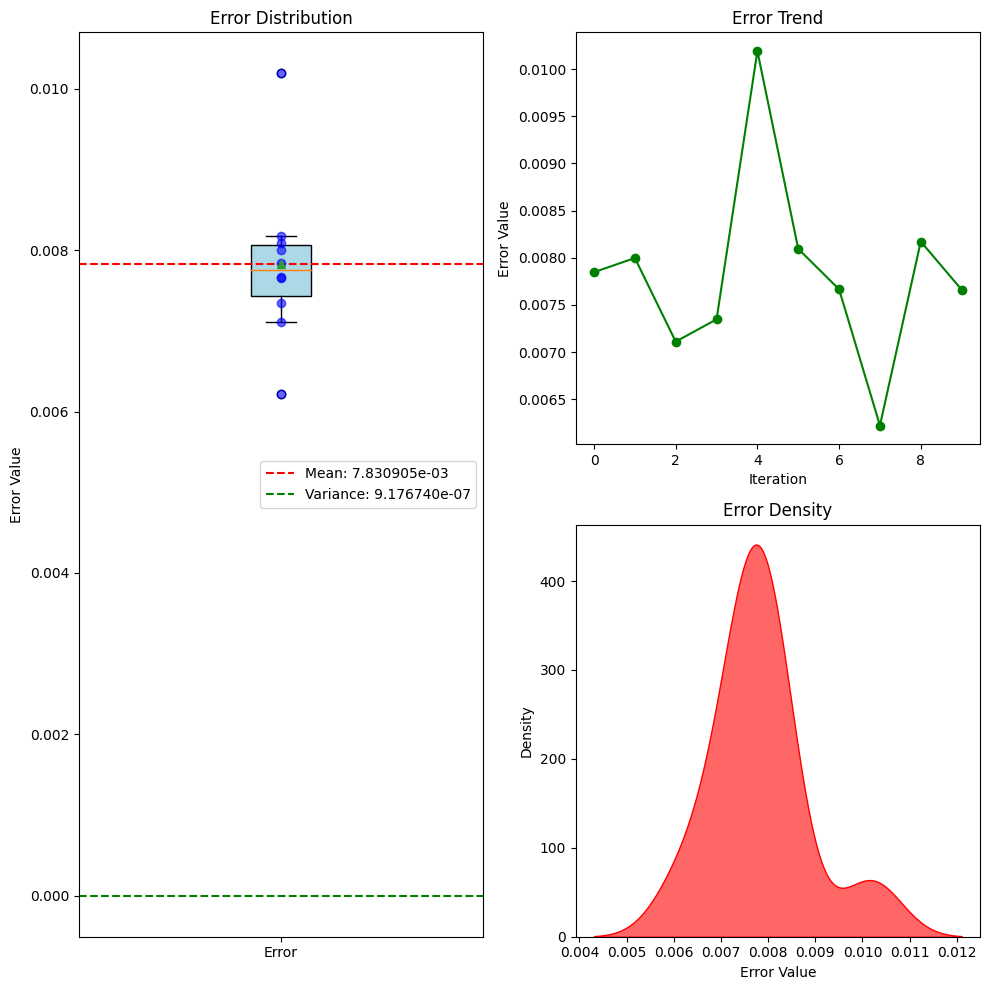

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = L1error

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [7]:
print('L1 error:', L1error)
print('L2 error:', L2error)

L1 error: [0.007847185762370234, 0.00799728238263929, 0.00711105945613124, 0.007347568728774992, 0.010190487810628614, 0.008094252504190807, 0.007665394818647705, 0.006222315610738077, 0.008172022187384016, 0.00766147947645681]
L2 error: [0.02331901754735852, 0.02010258623748251, 0.020038035877437185, 0.01904622350987866, 0.025269209972001768, 0.022823713737270986, 0.02593690227643516, 0.017690303642160423, 0.02207252202651917, 0.021606305541196334]
